In [ ]:
# Remove this
#! pip install torch==2.3 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install --upgrade torch torchvision==0.15.0+cu118 --index-url https://download.pytorch.org/whl/cu118

#! pip install stacchip
#! pip install geopandas

! pip install contextily

In [1]:
import warnings

import geoarrow.pyarrow as ga
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pystac_client
import requests
import torch
import yaml
from box import Box

import stacchip.indexer
from stacchip.chipper import Chipper
from stacchip.indexer import Sentinel2Indexer
from torchvision.transforms import v2

import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import math
import os
import random

import timm
import torch
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch import nn
from torchvision.transforms import v2

from src.backbone import Transformer
from src.factory import DynamicEmbedding
from src.utils import posemb_sincos_2d_with_gsd

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"

#from src.model import ClayMAEModule

import contextily as cx
import rasterio
from rasterio.plot import show

from shapely.geometry import box

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from shapely import wkb

import stackstac
import pystac_client
import numpy as np
import dask
from rasterio.enums import Resampling
from rasterstats import zonal_stats
import xarray as xr
import rioxarray as rxr

import torch.nn as nn

import shapely
from shapely.geometry import Polygon
from rasterio.features import rasterize

warnings.filterwarnings("ignore")

### Load mining data and visualize

In [ ]:
# Load mine polygons from Tang dataset and remove Z coordinate
mine_poly = gpd.read_file('data/mine_poly_shp').to_crs(epsg=4326)

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    From : https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
        else:
            print('no z')
    return new_geo

mine_poly.geometry = convert_3D_2D(mine_poly.geometry) 

print('Number of mine features:')
print(len(mine_poly))


In [2]:
# Load Aquarry QA'ed data
psql_bboxes = gpd.read_file('data/aquarry_psql_layer.csv')
psql_bboxes = gpd.GeoDataFrame(psql_bboxes,geometry = psql_bboxes['field_8'].apply(wkb.loads),crs='epsg:4326') # Convert WKB geometry

psql_bboxes.columns = ['cc', 'objectid', 'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry','field_9', 'category', 'field_11', 'geometry']

In [3]:
# Subset US QA data
US_QA = psql_bboxes[psql_bboxes['cc'] == 'US']
print(US_QA['category'].value_counts())

f"Number of confirmed mine features: {len(US_QA[US_QA['category']=='a'])}"

# Write to shapefile to inspect
#US_QA.to_file('data/US_QA')

category
\N    8512
a     1656
t      214
d      205
x      140
q       89
c       73
n       64
w       52
Name: count, dtype: int64


'Number of confirmed mine features: 1656'

In [491]:
US_QA_na = US_QA[~US_QA['category'].isin(['a','t','d','x','q','c','n','w'])]
print(f'Number of unlabeled features: {len(US_QA_na)}')

Number of unlabeled features: 8512


#### Filter QA'ed dataset

In [4]:
states = gpd.read_file('data/state_boundaries')

# Get only QA'ed pits that are 0.5 or greater (i.e. have been QA'ed and/or higher likelihood)
print(f'Number of features in US dataset: {len(US_QA)}')
US_QA['score'] = US_QA['score'].apply(lambda score: float(score))
US_QA_filtered = US_QA[US_QA['score'] > 0.5]
US_QA_filtered['feature_idx'] = US_QA_filtered.reset_index(drop=True).index # Use for dissolve on spatial joining
print(f'Number of features in US with > 50% probability: {len(US_QA_filtered)}')


# Get only states with pit lakes
states['geometry'] = states['geometry'].apply(lambda geom: gpd.GeoSeries([geom]).unary_union)
states = gpd.GeoDataFrame(states, geometry='geometry', crs=states.crs).to_crs(epsg = 4326)
states = states[~states['STUSPS'].isin(['VI','PR','GU','MP','AS'])]

states_with_pits = gpd.sjoin(states, US_QA_filtered, how = 'left', predicate = 'intersects')
states_with_pits = states_with_pits[~states_with_pits['score'].isna()]

# Take out states with less than 5 pit lakes
states_with_enough_pits = states_with_pits['STUSPS'].value_counts() > 5
states_list = states_with_enough_pits[states_with_enough_pits].index.to_list()

states_with_low_pits = states_with_pits['STUSPS'].value_counts() < 5
print(f'States to remove: {states_with_low_pits[states_with_low_pits].index}')

states_filtered = states_with_pits[states_with_pits['STUSPS'].isin(states_list)].drop_duplicates('geometry')[['STUSPS','geometry']]

states_geometries = states[states['STUSPS'].isin(states_list)]
print(f'# of states being used: {len(states_geometries)}')

Number of features in US dataset: 11005
Number of features in US with > 50% probability: 2491
States to remove: Index(['NJ', 'NY', 'OR', 'KS'], dtype='object', name='STUSPS')
# of states being used: 36


#### Get MN data and separate mines / other bodies of water

In [761]:
# Get pit lakes in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union

mn_qa = US_QA[US_QA.geometry.intersects(mn)]
print(f'MN QAed mines: {(mn_qa['category'] == 'a').sum()}')


# Get pit lakes in IL, IN, KY, MS

states = gpd.read_file('data/state_boundaries')
il_in_ky_ms = states[states['STUSPS'].isin(['IL','IN','KY','MS'])]
print(il_in_ky_ms)
il_in_ky_ms = il_in_ky_ms.to_crs(epsg = 4326).geometry.unary_union 

il_in_ky_ms_qa = US_QA[US_QA.geometry.intersects(il_in_ky_ms)]
print(f'IL IN KY MS QAed mines: {(il_in_ky_ms_qa['category'] == 'a').sum()}')


# Get pit lakes in GA

states = gpd.read_file('data/state_boundaries')
ga = states[states['STUSPS']=='GA']
ga = ga.to_crs(epsg = 4326).geometry.unary_union

ga_qa = US_QA[US_QA.geometry.intersects(ga)]
print(f'GA QAed mines: {(ga_qa['category'] == 'a').sum()}')


# Get pit lakes in TX

states = gpd.read_file('data/state_boundaries')
tx = states[states['STUSPS']=='TX']
tx = tx.to_crs(epsg = 4326).geometry.unary_union

tx_qa = US_QA[US_QA.geometry.intersects(tx)]
print(f'TX QAed mines: {(tx_qa['category'] == 'a').sum()}')


# Get pit lakes in AZ, NV

states = gpd.read_file('data/state_boundaries')
az_nv = states[states['STUSPS'].isin(['AZ','NV'])]
print(az_nv)
az_nv = az_nv.to_crs(epsg = 4326).geometry.unary_union 

az_nv_qa = US_QA[US_QA.geometry.intersects(az_nv)]
print(f'AZ, NV QAed mines: {(az_nv_qa['category'] == 'a').sum()}')


# Get pit lakes in MT, WY

states = gpd.read_file('data/state_boundaries')
mt_wy = states[states['STUSPS'].isin(['MT','WY'])]
print(mt_wy)
mt_wy = mt_wy.to_crs(epsg = 4326).geometry.unary_union 

mt_wy_qa = US_QA[US_QA.geometry.intersects(mt_wy)]
print(f'MT WY QAed mines: {(mt_wy_qa['category'] == 'a').sum()}')


MN QAed mines: 87
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS         NAME LSAD  \
3       21  01779786  0400000US21    21     KY     Kentucky   00   
15      18  00448508  0400000US18    18     IN      Indiana   00   
20      17  01779784  0400000US17    17     IL     Illinois   00   
51      28  01779790  0400000US28    28     MS  Mississippi   00   

           ALAND      AWATER  \
3   102266598312  2384223544   
15   92786613552  1543998356   
20  143778366814  6216688589   
51  121533540877  3914738613   

                                             geometry  
3   MULTIPOLYGON (((-89.40565 36.52816, -89.39868 ...  
15  POLYGON ((-88.09776 37.90403, -88.09448 37.905...  
20  POLYGON ((-91.51297 40.18106, -91.51107 40.188...  
51  MULTIPOLYGON (((-88.50502 30.21574, -88.49164 ...  
IL IN KY MS QAed mines: 293
GA QAed mines: 275
TX QAed mines: 128
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS     NAME LSAD         ALAND  \
19      32  01779793  0400000US32    32     NV   Nevada 

In [6]:
# Data source: https://gisdata.mn.gov/dataset/water-dnr-hydrography

mn_water_features = gpd.read_file('data/dnr_hydro_features')
mn_water_features = mn_water_features[['wb_class','shape_Area','geometry']]
mine_classes = ['Natural Ore Mine','Mine Pit Lake','Mine Pit Lake (NF)','Tac/Natural Ore Mine']

dnr_pit_lakes = mn_water_features.loc[mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

dnr_water = mn_water_features[~mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

print(len(dnr_pit_lakes))
print(len(dnr_water))

dnr_pit_lakes.head()


200
130746


,wb_class,shape_Area,geometry
411,Natural Ore Mine,1.069300e+05,"POLYGON ((-92.69807 47.51515, -92.69809 47.515..."
1089,Natural Ore Mine,1.319908e+04,"POLYGON ((-92.56445 47.4694, -92.56435 47.4693..."
1156,Mine Pit Lake (NF),1.886662e+05,"POLYGON ((-94.00199 46.48612, -94.00145 46.485..."
1228,Mine Pit Lake,1.145849e+07,"POLYGON ((-92.64102 47.55076, -92.64056 47.550..."
2000,Natural Ore Mine,3.979919e+04,"POLYGON ((-92.74355 47.51982, -92.74342 47.519..."


In [7]:
mn_qa_pits = mn_qa[mn_qa['category']=='a']
overlap_check = gpd.sjoin(mn_qa_pits, dnr_pit_lakes, how = 'inner', predicate = "intersects")
overlap_check = overlap_check.drop_duplicates(subset=["objectid"])
print(f"% of mine QA'ed data with overlapping polygon from MN DNR: {len(overlap_check)/len(mn_qa_pits)*100}")

overlap_check = gpd.sjoin(dnr_pit_lakes, mn_qa_pits, how = 'inner', predicate = "intersects")
overlap_check = overlap_check.drop_duplicates(subset=["geometry"])
print(f"% of DNR polygons with overlapping mine QA'ed data: {len(overlap_check)/len(dnr_pit_lakes)*100}")


% of mine QA'ed data with overlapping polygon from MN DNR: 63.2183908045977
% of DNR polygons with overlapping mine QA'ed data: 28.999999999999996


In [ ]:
# Hold out Crosby MN

crosby_mn = gpd.read_file('data/crosby_mn.geojson')
dnr_pit_lakes = dnr_pit_lakes[~dnr_pit_lakes.geometry.intersects(crosby_mn.geometry.iloc[0])]
mn_qa = mn_qa[~mn_qa.geometry.intersects(crosby_mn.geometry.iloc[0])]
dnr_water = dnr_water[~dnr_water.geometry.intersects(crosby_mn.geometry.iloc[0])]

print((mn_qa['category']=='a').sum())
print(len(dnr_water))

### Grab embeddings for mines and random embeddings

In [8]:
# Define function for getting embedding files that intersect with polygons of interest
# USE WHEN DON'T HAVE BIGGER GRID ZONES TO SEARCH THROUGH

def GetEmbeddingsFromIntersection1_5(folder_path, polygons, random_images = True, count = 35):
    """ Take a folder of embeddings as a string and a set of polygons and return 1) scene file names with intersecting 
    chips and 2) a random set of non-intersecting image files
    
    Parameters:
    folder_path (str): folder with embedding gpqs
    polygons (GeoDataFrame): positive polygon masks 
    random_images (bool): True if you want random negative images
    
    Returns:
    positive_embeddings, negative embeddings (list, list): one positive, one negative set of scenes  """

    positive_embeddings = []
    negatives_list = []
    negative_embeddings = []

    # Go through all embedding folders
    # Folder structure: Grid zone, year, month, embedding folder, parquet file
    grid_zone_folders = [os.path.join(folder_path, folder) for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for grid_zone_folder in grid_zone_folders:
        grid_zone = os.path.basename(grid_zone_folder)
        # Get list of year folders
        year_folders = [os.path.join(grid_zone_folder, year) for year in os.listdir(grid_zone_folder) if os.path.isdir(os.path.join(grid_zone_folder, year))]
    
        for year_folder in year_folders:
            year = os.path.basename(year_folder)
            # Get list of month folders
            month_folders = [os.path.join(year_folder, month) for month in os.listdir(year_folder) if os.path.isdir(os.path.join(year_folder, month))]
            
            for month_folder in month_folders:
                month = os.path.basename(month_folder)
                year_month = f"{year}_{month}"
                    
                # Get list of embedding folders
                embedding_folders = [os.path.join(month_folder, embedding) for embedding in os.listdir(month_folder) if os.path.isdir(os.path.join(month_folder, embedding))]
                
                for embedding_folder in embedding_folders:
                    # Get all parquet files in the embedding folder
                    parquet_files = [os.path.join(embedding_folder, f) for f in os.listdir(embedding_folder) if f.endswith(".parquet")]

                    parquet_files_details = []

                    # Append parquet file details with grid zone and year_month to the list
                    for parquet_file in parquet_files:
                        parquet_files_details.append({
                            "file_path": parquet_file,
                            "grid_zone": grid_zone,
                            "year_month": year_month
                        })

                    # In each folder, go through parquet files and add file to list if it contains mines
                    # Check if image has any intersecting chips
                    for file in parquet_files_details:
                        if os.path.getsize(file['file_path']) > 0:
                           pqs = gpd.read_parquet(file['file_path'], columns=["geometry"])
                        else:
                            print(f"Skipping empty file: {file['file_path']}")
                        if not gpd.sjoin(pqs, polygons, how="inner", predicate="intersects", rsuffix="_1").empty:
                            positive_embeddings.append(file)
                        else: 
                            if random_images == True: # If there is no intersection, choose X number of random images to grab embeddings
                                negatives_list.append(file)
                                            
                    if random_images == True:
                        # Set up to get random images
                        index = np.array(random.sample(range(1, len(negatives_list)), count))

                        for i in index:
                            negative_embeddings.append(negatives_list[i])           
                        print(f'Random images: {len(negative_embeddings)}')

    return positive_embeddings, negative_embeddings

In [286]:
# Define function for getting embedding files that intersect with polygons of interest
# USE WHEN HAVE BIGGER GRID ZONES TO SEARCH THROUGH, (i.e. 16T, 16S, etc.)

def GetEmbeddingsFromIntersection1_5(folder_path, polygons, random_images = True, count = 35):
    """ Take a folder of embeddings as a string and a set of polygons and return 1) scene file names with intersecting 
    chips and 2) a random set of non-intersecting image files
    
    Parameters:
    folder_path (str): folder with embedding gpqs
    polygons (GeoDataFrame): positive polygon masks 
    random_images (bool): True if you want random negative images
    
    Returns:
    positive_embeddings, negative embeddings (list, list): one positive, one negative set of scenes  """

    positive_embeddings = []
    negatives_list = []
    negative_embeddings = []

    # Go through all embedding folders
    # Folder structure: latitude grid, Grid zone, year, month, embedding folder, parquet file
    latitude_grid_folders = [os.path.join(folder_path, folder) for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for latitude_grid_folder in latitude_grid_folders:
        latitude_grid = os.path.basename(latitude_grid_folder)
        # Get list of grid zone folders
        grid_zone_folders = [os.path.join(latitude_grid_folder, folder) for folder in os.listdir(latitude_grid_folder) if os.path.isdir(os.path.join(latitude_grid_folder, folder))]

        for grid_zone_folder in grid_zone_folders:
            grid_zone = os.path.basename(grid_zone_folder)
            # Get list of year folders
            year_folders = [os.path.join(grid_zone_folder, year) for year in os.listdir(grid_zone_folder) if os.path.isdir(os.path.join(grid_zone_folder, year))]
    
            for year_folder in year_folders:
                year = os.path.basename(year_folder)
                # Get list of month folders
                month_folders = [os.path.join(year_folder, month) for month in os.listdir(year_folder) if os.path.isdir(os.path.join(year_folder, month))]
                
                for month_folder in month_folders:
                    month = os.path.basename(month_folder)
                    year_month = f"{year}_{month}"
                        
                    # Get list of embedding folders
                    embedding_folders = [os.path.join(month_folder, embedding) for embedding in os.listdir(month_folder) if os.path.isdir(os.path.join(month_folder, embedding))]
                    
                    for embedding_folder in embedding_folders:
                        # Get all parquet files in the embedding folder
                        parquet_files = [os.path.join(embedding_folder, f) for f in os.listdir(embedding_folder) if f.endswith(".parquet")]

                        parquet_files_details = []

                        # Append parquet file details with grid zone and year_month to the list
                        for parquet_file in parquet_files:
                            parquet_files_details.append({
                                "file_path": parquet_file,
                                "grid_zone": grid_zone,
                                "year_month": year_month
                            })

                        # In each folder, go through parquet files and add file to list if it contains mines
                        # Check if image has any intersecting chips
                        for file in parquet_files_details:
                            if os.path.getsize(file['file_path']) > 0:
                                pqs = gpd.read_parquet(file['file_path'], columns=["geometry"])
                            else:
                                print(f"Skipping empty file: {file['file_path']}")
                            if not gpd.sjoin(pqs, polygons, how="inner", predicate="intersects", rsuffix="_1").empty:
                                positive_embeddings.append(file)
                            else: 
                                if random_images == True: # If there is no intersection, choose X number of random images to grab embeddings
                                    negatives_list.append(file)
                                                
                        if random_images == True:
                            # Set up to get random images
                            index = np.array(random.sample(range(1, len(negatives_list)), count))

                            for i in index:
                                negative_embeddings.append(negatives_list[i])           
                            print(f'Random images: {len(negative_embeddings)}')

    return positive_embeddings, negative_embeddings

In [9]:
# Get monthly aggregates of chip embeddings for a given set of embedded images (not averaging)
# Use if chip geometries overlap substantially

def MonthlyComposite(embeddings_df, polygons = None):
    """ Take a dataframe of embedding geoparquet files and get corresponding chips with < 25% overlap

    Parameters:
    embeddings_df (DataFrame): dataframe with three columns, embeddings file paths, 
    polygons (GeoDataFrame): gdf containing geometries of features of intersect. If specified, returns only chips
    that intersect these
    
    """

    monthly_agg_embeddings = gpd.GeoDataFrame()
    if polygons is not None:
        polys_geometry = polygons.unary_union

    for zone in embeddings_df['grid_zone'].unique(): # For each UTM zone
        zone_embeddings = pd.DataFrame(embeddings_df[embeddings_df['grid_zone'] == str(zone)])
        count = 1

        for index, row in zone_embeddings.iterrows(): # For each date within UTM zone
             # Will need to adjust when more months are available, currently just goes through whole list
            chip_embeddings_agg_gdf = gpd.GeoDataFrame()
            non_intersecting_chips = gpd.GeoDataFrame()
            chip_embeddings = gpd.read_parquet(row['file_path'])
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)

            if len(chip_embeddings) > 2000: # If the image is not very cloudy
                if polygons is not None: # Don't include chips that don't correspond to the polygons
                    chip_embeddings = chip_embeddings[chip_embeddings.geometry.intersects(polys_geometry)]
                if not monthly_agg_embeddings.empty:
                    # Get all chips that aren't already in the aggregation
                    chips_intersection = chip_embeddings.geometry.intersects(monthly_agg_embeddings_unified)
                    non_intersecting_chips = chip_embeddings[~chips_intersection]
                    chip_embeddings_agg_gdf = non_intersecting_chips.rename(columns={'embeddings_left': 'embeddings'})
                    
                    # Add chips that intersect with aggregation that are less than 25% overlapping
                    intersecting_chips = chip_embeddings[chips_intersection]
                    intersecting_chips['chip_area'] = intersecting_chips.geometry.area
                    intersections = intersecting_chips.geometry.intersection(monthly_agg_embeddings_unified)
                    intersecting_chips['area_overlap'] = intersections.area
                    low_intersection_mask = (intersecting_chips['area_overlap'] / intersecting_chips['chip_area']) < 0.25
                    low_intersection_chips = intersecting_chips[low_intersection_mask].rename(columns={'embeddings_left': 'embeddings'})
                    # Add chips with small overlap to aggregated embeddings
                    chip_embeddings_agg_gdf = pd.concat([chip_embeddings_agg_gdf,low_intersection_chips])
                else:
                    non_intersecting_chips = chip_embeddings
                    chip_embeddings_agg_gdf = gpd.GeoDataFrame(non_intersecting_chips['embeddings'], columns = ['embeddings'], geometry=non_intersecting_chips['geometry'])
                chip_embeddings_agg_gdf['grid_zone'] = zone
                chip_embeddings_agg_gdf['year_month'] = zone_embeddings['year_month'].iloc[0]

                # Add additional chips
                monthly_agg_embeddings = pd.concat([monthly_agg_embeddings, chip_embeddings_agg_gdf])

                # Get geometries of aggregated chips to compare against
                chip_embeddings_agg_gdf_unified = chip_embeddings_agg_gdf.unary_union
                monthly_agg_embeddings_unified = monthly_agg_embeddings.union(chip_embeddings_agg_gdf_unified).unary_union
                #count = count + 1
                #if count == 3: # Check two images without clouds
                    #count = 1
                break
    
    monthly_agg_embeddings.to_crs(epsg=4326)
    monthly_agg_embeddings = monthly_agg_embeddings.drop_duplicates('geometry')

    return monthly_agg_embeddings

In [10]:
# Get embeddings by region
def RegionalData(region, zone, negatives = True):
    qa_pits = gpd.sjoin(US_QA_filtered, region, how = 'inner', predicate = 'intersects')
    qa_pits = qa_pits.dissolve(by = 'feature_idx')

    us_qa_pits = qa_pits[qa_pits['category'] == 'a']
    us_qa_nonlakes = qa_pits[~qa_pits['category'].isin(['a','q','\\N'])]

    print(f'Number of features identified as pit lakes in overlapping states in the region: {len(us_qa_pits)}')
    # Note: this number will exceed the actual amount in the region

    # Get embeddings for pit lakes and no pit lakes present in US zone from QA data
    print(f'data/US_v1_5/{zone}')
    mine_embeddings_us, non_mine_embeddings_us = GetEmbeddingsFromIntersection1_5(folder_path = f'data/US_v1_5/{zone}', polygons = us_qa_pits, random_images=False)
    print(f"Number of images with mines: {len(mine_embeddings_us)}")

    # Get monthly embeddings for pit lake embeddings in MN
    mine_embeddings_us_df = pd.DataFrame(mine_embeddings_us, columns = ['file_path','grid_zone','year_month'])

    us_positive_embs_avg = MonthlyComposite(mine_embeddings_us_df, us_qa_pits)
    print(f'Number of positive chips: {len(us_positive_embs_avg)}')
    
    us_negative_embs_avg = gpd.GeoDataFrame()
    if negatives == True:
        # Get embeddings for features identified as not lakes from QA
        qa_non_mine_embeddings_us, dummy = GetEmbeddingsFromIntersection1_5(folder_path = f'data/US_v1_5/{zone}', polygons = us_qa_nonlakes, random_images=False)
        print(f"Number of negative mine images: {len(qa_non_mine_embeddings_us)}")

        # Get monthly embeddings for water and non-pit lake embeddings in MN
        qa_non_mine_embeddings_us_df = pd.DataFrame(qa_non_mine_embeddings_us, columns = ['file_path','grid_zone','year_month'])

        us_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_us_df, us_qa_nonlakes)
        print(f'Number of negative chips: {len(us_negative_embs_avg)}')

    return us_positive_embs_avg, us_negative_embs_avg
    


In [11]:
# Get geometries for region 11
region11 = states_filtered[states_filtered['STUSPS'].isin(['CA', 'AZ', 'NV', 'WA', 'OR', 'ID', 'MT'])]

qa_pits_11 = gpd.sjoin(US_QA_filtered, region11, how = 'inner', predicate = 'intersects')
qa_pits_11['geometry'] = qa_pits_11.geometry
qa_pits_11 = qa_pits_11.dissolve(by = 'feature_idx')

us_qa_pits_11 = qa_pits_11[qa_pits_11['category'] == 'a']
us_qa_nonlakes_11 = qa_pits_11[~qa_pits_11['category'].isin(['a','q','\\N'])]

print(len(us_qa_pits_11))

# Get geometries for region 15
region15 = states_filtered[states_filtered['STUSPS'].isin(['MN', 'IA', 'MO', 'AR', 'LA', 'FL', 'TX', 'OK', 'KS', 'MS', 'IL','WI'])]

qa_pits_15 = gpd.sjoin(US_QA_filtered, region15, how = 'inner', predicate = 'intersects')
qa_pits_15['geometry'] = qa_pits_15.geometry
qa_pits_15 = qa_pits_15.dissolve(by = 'feature_idx')

us_qa_pits_15 = qa_pits_15[qa_pits_15['category'] == 'a']
us_qa_nonlakes_15 = qa_pits_15[~qa_pits_15['category'].isin(['a','q','\\N'])]

print(len(us_qa_pits_15))

# Get geometries for region 16 and 17
region16 = states_filtered[states_filtered['STUSPS'].isin(['MN', 'MI', 'IL', 'IN', 'OH', 'MS', 'AL', 'GA', 'LA', 'FL', 'MO'])]

qa_pits_16 = gpd.sjoin(US_QA_filtered, region16, how = 'inner', predicate = 'intersects')
qa_pits_16['geometry'] = qa_pits_16.geometry
qa_pits_16 = qa_pits_16.dissolve(by = 'feature_idx')

us_qa_pits_16 = qa_pits_16[qa_pits_16['category'] == 'a']
us_qa_nonlakes_16 = qa_pits_16[~qa_pits_16['category'].isin(['a','q','\\N'])]

print(len(us_qa_pits_16))

region17 = states_filtered[states_filtered['STUSPS'].isin(['MI', 'OH', 'NY', 'PA', 'WV', 'VA', 'NC', 'SC', 'KY', 'TN', 'GA','FL'])]

qa_pits_17 = gpd.sjoin(US_QA_filtered, region17, how = 'inner', predicate = 'intersects')
qa_pits_17['geometry'] = qa_pits_17.geometry
qa_pits_17 = qa_pits_17.dissolve(by = 'feature_idx')

us_qa_pits_17 = qa_pits_17[qa_pits_17['category'] == 'a']
us_qa_nonlakes_17 = qa_pits_17[~qa_pits_17['category'].isin(['a','q','\\N'])]

print(len(us_qa_pits_17))


162
507
921
729


In [518]:
# Get grid region geometries and get corresponding positive and negative embeddings from QA dataset
# 'CA', 'AZ', 'NV', 'WA', 'OR', 'ID'

region11S = states_filtered[states_filtered['STUSPS'].isin(['CA', 'NV', 'AZ'])]
region11T = states_filtered[states_filtered['STUSPS'].isin(['NV', 'ID', 'OR', 'WA', 'MT'])]
region11U = states_filtered[states_filtered['STUSPS'].isin(['MT', 'WA'])]

us11S_positive_embs_avg, us11S_negative_embs_avg = RegionalData(region11S, '11/S')
us11T_positive_embs_avg, us11T_negative_embs_avg = RegionalData(region11T, '11/T')
us11U_positive_embs_avg, us11U_negative_embs_avg = RegionalData(region11U, '11/U')


Number of features identified as pit lakes in overlapping states in the region: 121
data/US_v1_5/11/S
Number of images with mines: 897
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
Number of positive chips: 54
Number of negative mine images: 913
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
Number of negative chips: 81
Number of features identified as pit lakes in overlapping states in the region: 70
data/US_v1_5/11/T
Number of images with mines: 808
added
added
added
a

In [ ]:
# Get grid region geometries and get corresponding positive and negative embeddings from QA dataset

region15R = states_filtered[states_filtered['STUSPS'].isin(['TX', 'LA', 'MS'])]
region15S = states_filtered[states_filtered['STUSPS'].isin(['TX', 'LA', 'OK', 'KS', 'MS', 'AR', 'MO', 'IL'])]
region15T = states_filtered[states_filtered['STUSPS'].isin(['MN', 'WI', 'IL', 'IA', 'MO'])]
region15U = states_filtered[states_filtered['STUSPS'].isin(['MN'])]

us15R_positive_embs_avg, us15R_negative_embs_avg = RegionalData(region15R, '15/R')
us15S_positive_embs_avg, us15S_negative_embs_avg = RegionalData(region15S, '15/S')
us15T_positive_embs_avg, us15T_negative_embs_avg = RegionalData(region15T, '15/T')
us15U_positive_embs_avg, us15U_negative_embs_avg = RegionalData(region15U, '15/U')


Number of features identified as pit lakes in overlapping states in the region: 161
data/US_v1_5/15/R
Number of images with mines: 97
added
added
added
added
added
added
added
added
added
added
added
added
Number of positive chips: 5
Number of negative mine images: 78
added
added
added
added
added
added
added
added
added
added
added
added
Number of negative chips: 3
Number of features identified as pit lakes in overlapping states in the region: 276
data/US_v1_5/15/S
Number of images with mines: 740
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
Number of positive chips: 97
Number of negative mine images: 623
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added

In [10]:
# Get grid region geometries and get corresponding positive and negative embeddings from QA dataset

region16T = states_filtered[states_filtered['STUSPS'].isin(['MN', 'MI', 'IL', 'IN', 'OH'])]
region16S = states_filtered[states_filtered['STUSPS'].isin(['IL', 'IN', 'OH', 'MS', 'AL', 'GA', 'MO'])]
region16R = states_filtered[states_filtered['STUSPS'].isin(['MS', 'AL', 'GA','LA','FL'])]

us16T_positive_embs_avg, us16T_negative_embs_avg = RegionalData(region16T, '16/T')
us16R_positive_embs_avg, us16R_negative_embs_avg = RegionalData(region16R, '16/R')
us16S_positive_embs_avg, us16S_negative_embs_avg = RegionalData(region16S, '16/S')

Number of features identified as pit lakes in overlapping states in the region: 375
data/US_v1_5/16/T
Number of images with mines: 761
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
Number of positive chips: 111
Number of negative mine images: 711
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
Number of negative chips: 62
Number of features identified as pit lakes in overlapping states in the region: 528
data/US_v1_5/16/R
Number of images with mines: 179
added
added
added
added
added
added
added
added
added
added

In [11]:
# Get grid region geometries and get corresponding positive and negative embeddings from QA dataset

region17T = states_filtered[states_filtered['STUSPS'].isin(['MI', 'OH', 'PA','NY'])]
region17S = states_filtered[states_filtered['STUSPS'].isin(['OH', 'PA', 'WV', 'VA', 'NC', 'SC', 'KY', 'TN', 'GA'])]
region17R = states_filtered[states_filtered['STUSPS'].isin(['GA','FL'])]

us17S_positive_embs_avg, us17S_negative_embs_avg = RegionalData(region17S, '17/S')
us17T_positive_embs_avg, us17T_negative_embs_avg = RegionalData(region17T, '17/T')
us17R_positive_embs_avg, us17R_negative_embs_avg = RegionalData(region17R, '17/R')

Number of features identified as pit lakes in overlapping states in the region: 573
data/US_v1_5/17/S
Number of images with mines: 494
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
Number of positive chips: 146
Number of negative mine images: 462
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
Number of negative chips: 122
Number of features identified as pit lakes in overlapping states in the region: 123
data/US_v1_5/17/T
Skipping empty file: data/US_v1_5/17/T\MG\2024\9\S2B_17TMG_20240907_0_L2A\S2B_17TMG_20240907_0_L2A.parquet
Number of images with mines: 466
added
added
added
added
added

In [519]:
# Concatenate into UTM vertical zones
us11_positive_embs_avg = pd.concat([us11S_positive_embs_avg, us11T_positive_embs_avg, us11U_positive_embs_avg])
us11_negative_embs_avg = pd.concat([us11S_negative_embs_avg, us11T_negative_embs_avg, us11U_negative_embs_avg])

us15_positive_embs_avg = pd.concat([us15R_positive_embs_avg, us15S_positive_embs_avg, us15T_positive_embs_avg, us15U_positive_embs_avg])
us15_negative_embs_avg = pd.concat([us15R_negative_embs_avg, us15S_negative_embs_avg, us15T_negative_embs_avg, us15U_negative_embs_avg])

us16_positive_embs_avg = pd.concat([us16R_positive_embs_avg, us16S_positive_embs_avg, us16T_positive_embs_avg])
us16_negative_embs_avg = pd.concat([us16R_negative_embs_avg, us16S_negative_embs_avg, us16T_negative_embs_avg])

us17_positive_embs_avg = pd.concat([us17R_positive_embs_avg, us17S_positive_embs_avg, us17T_positive_embs_avg])
us17_negative_embs_avg = pd.concat([us17R_negative_embs_avg, us17S_negative_embs_avg, us17T_negative_embs_avg])

<Axes: >

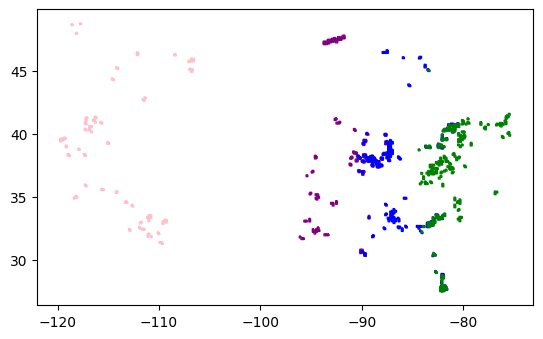

In [520]:
# Visualize pit lake chips
fig, ax = plt.subplots()
us11_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "pink")
us15_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "purple")
us16_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue")
us17_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "green")

In [15]:
mn256 = gpd.read_parquet('data/north_mn_256_2022-06-01_2022-08-31_tile_embeddings_final_9288.parquet')
il_in_ky_ms256 = gpd.read_parquet("data/ms_il_in_ky_256_2022-06-01_2022-08-31_tile_embeddings_final_16297.parquet")
ga256 = gpd.read_parquet("data/ga_256_2022-06-01_2022-08-31_tile_embeddings_final_1933.parquet")
mt_wy256 = gpd.read_parquet("data/mt_wy_256_2022-06-01_2022-08-31_tile_embeddings_final_3985.parquet")
az_nv256 = gpd.read_parquet('data/nv_az_256_2022-06-01_2022-08-31_tile_embeddings_final_10312.parquet')
tx256 = gpd.read_parquet('data/tx_256_2022-06-01_2022-08-31_tile_embeddings_final_2661.parquet')

print(len(mn256))
print(mn256.columns)
print(mn256.crs)
print(len(il_in_ky_ms256))
print(il_in_ky_ms256.columns)
print(il_in_ky_ms256.crs)
print(len(ga256))
print(ga256.columns)
print(ga256.crs)
print(len(mt_wy256))
print(mt_wy256.columns)
print(mt_wy256.crs)
print(len(az_nv256))
print(az_nv256.columns)
print(az_nv256.crs)
print(len(tx256))
print(tx256.columns)
print(tx256.crs)

9288
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt'],
      dtype='object')
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "

### State by state

In [1753]:
# Get Minnesota pit lakes from Aquarry and DNR
mn_qa_pits = mn_qa[mn_qa['category'].isin(['a','q','d'])] # QAed pit lakes 

mn_aggregated_pits = gpd.overlay(mn_qa_pits, dnr_pit_lakes, how="union")

mn_qa_nonlakes = mn_qa[~mn_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get embeddings for lakes/water in MN
dnr_water = dnr_water.to_crs(epsg=4326)

# Reduce sample size
random_idx = random.sample(range(1, len(dnr_water)), 1000)
dnr_water_cropped = dnr_water.iloc[random_idx]


# Get IL, IN, KY, MS pit lakes from Aquarry

il_in_ky_ms_qa_pits = il_in_ky_ms_qa[il_in_ky_ms_qa['category'].isin(['a','q','d'])] # QAed pit lakes
il_in_ky_ms_qa_nonlakes = il_in_ky_ms_qa[~il_in_ky_ms_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get GA pit lakes from Aquarry

ga_qa_pits = ga_qa[ga_qa['category'].isin(['a','q','d'])] # QAed pit lakes
ga_qa_nonlakes = ga_qa[~ga_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get MT WY pit lakes from Aquarry

mt_wy_qa_pits = mt_wy_qa[mt_wy_qa['category'].isin(['a','q','d'])] # QAed pit lakes
mt_wy_qa_nonlakes = mt_wy_qa[~mt_wy_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get TX pit lakes from Aquarry

tx_qa_pits = tx_qa[tx_qa['category'].isin(['a','q','d'])] # QAed pit lakes
tx_qa_nonlakes = tx_qa[~tx_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get AZ NV pit lakes from Aquarry

az_nv_qa_pits = az_nv_qa[az_nv_qa['category'].isin(['a','q','d'])] # QAed pit lakes
az_nv_qa_nonlakes = az_nv_qa[~az_nv_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

In [ ]:
# Get MN embeddings
# Combine Aquarry QA and DNR data to check for intersection

# Get embedding files for pit lakes in MN in DNR or Aquarry dataset
mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = mn_aggregated_pits, random_images = False)
print(f"Number of images with mines: {len(mine_embeddings_mn)}")

#dnr_water_cropped = dnr_water_cropped[~dnr_water_cropped.geometry.intersects(crosby_mn.geometry.iloc[0])] # Remove any Crosby lakes

lake_embeddings_mn, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = dnr_water_cropped, random_images = False)
print(f"Number of images with water that's not mines: {len(lake_embeddings_mn)}")


# Get embeddings for features identified as not lakes from QA
qa_non_mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection1_5(folder_path = 'data/MN_v1_5/', polygons = mn_qa_nonlakes, random_images = False)
print(f"Number of negative mine images: {len(qa_non_mine_embeddings_mn)}")

KeyboardInterrupt: 

In [ ]:
# Get monthly embeddings for pit lake embeddings in MN
mine_embeddings_mn_df = pd.DataFrame(mine_embeddings_mn, columns = ['file_path','grid_zone','year_month'])

mn_positive_embs_avg = MonthlyComposite(mine_embeddings_mn_df, mn_aggregated_pits)
print(len(mn_positive_embs_avg))

# Get monthly embeddings for water and non-pit lake embeddings in MN
lake_embeddings_mn_df = pd.DataFrame(lake_embeddings_mn, columns = ['file_path','grid_zone','year_month'])
qa_non_mine_embeddings_mn_df = pd.DataFrame(qa_non_mine_embeddings_mn, columns = ['file_path','grid_zone','year_month'])

mn_water_embs_avg = MonthlyComposite(lake_embeddings_mn_df, dnr_water_cropped)
mn_negative_embs_avg = MonthlyComposite(qa_non_mine_embeddings_mn_df, mn_qa_nonlakes)
print(len(mn_water_embs_avg))
print(len(mn_negative_embs_avg))

# Get embeddings for pit lakes in MN in DNR dataset
mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mn/rgbir_cog/mn/', polygons = dnr_pit_lakes, random_images = False)

print(f"Number of images with mines: {len(mine_embeddings_mn)}")

### Label embeddings with mine/no mine

In [24]:
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5(positive_embeddings, negative_embeddings, polygons = gpd.GeoDataFrame(), polygons2 = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    positive_chips = gpd.sjoin(positive_embeddings, polygons, predicate='intersects',how = 'inner',rsuffix="_1")
    positive_chips = positive_chips[~positive_chips['index_right'].isna()]

    data = pd.concat([data, positive_chips], ignore_index=True)
    data['mine'] = 1 # Assign 1 to mine column for chips with embeddings

    if polygons2.empty:
        for emb in negative_embeddings:
            negative_embeddings['mine'] = 0 # Assign 0 to mine column for chips without overlap
            data = pd.concat([data, negative_embeddings], ignore_index=True)
    else:
        for emb in negative_embeddings:
            negative_chips = gpd.sjoin(negative_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
            negative_chips = negative_chips[~negative_chips['index_right'].isna()]
            negative_chips['mine'] = 0
            data = pd.concat([data, negative_chips], ignore_index=True)

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    data = data.drop_duplicates(subset=['geometry'])
    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    return data

In [1755]:
# USE FOR MASON GENERATED EMBEDDINGS
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5(positive_embeddings, negative_embeddings, polygons = gpd.GeoDataFrame(), polygons2 = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    positive_chips = gpd.sjoin(positive_embeddings, polygons, predicate='intersects',how = 'inner',rsuffix="_1")
    positive_chips = positive_chips[~positive_chips['index__1'].isna()] # Drop chips without intersection

    data = pd.concat([data, positive_chips], ignore_index=True)
    data['mine'] = 1 # Assign 1 to mine column for chips with embeddings

    if polygons2.empty:
        for emb in negative_embeddings:
            negative_embeddings['mine'] = 0 # Assign 0 to mine column for chips without overlap
            data = pd.concat([data, negative_embeddings], ignore_index=True)
    else:
        for emb in negative_embeddings:
            negative_chips = gpd.sjoin(negative_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
            negative_chips = negative_chips[~negative_chips['index__1'].isna()] # Drop chips without intersection
            negative_chips['mine'] = 0
            data = pd.concat([data, negative_chips], ignore_index=True)

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    #data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    #data = data.drop_duplicates(subset=['geometry'])

    # Get max of mine and score for each chip
    # SWAP OUT THESE LINES FOR NORMAL CLASSIFICATION
    data.loc[data['category'].isin(['\\N', 't','x','c','n','w']), 'mine'] = 0

    data = data.groupby('geometry', as_index=False).agg({'mine': 'max','score': 'max','category': 'first','embedding':'first'})

    data.loc[data['mine'] == 1, 'category'] = 'a'

    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    datacrs = positive_embeddings.crs
    data = gpd.GeoDataFrame(data, geometry='geometry').set_crs(datacrs)

    return data

In [1020]:
# Adding scores
dataAZNV_scores = LabelEmbeddings1_5(az_nv256, az_nv256, az_nv_qa)
dataILINKYMS_scores = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms256, il_in_ky_ms_qa)
dataGA_scores = LabelEmbeddings1_5(ga256, ga256, ga_qa)
dataMN_scores = LabelEmbeddings1_5(mn256, mn256, mn_aggregated_pits)
dataMTWY_scores = LabelEmbeddings1_5(mt_wy256, mt_wy256, mt_wy_qa)
dataTX_scores = LabelEmbeddings1_5(tx256, tx256, tx_qa)


dataAZNV_scores.loc[dataAZNV_scores['category'].isna(), 'score'] = 0
dataILINKYMS_scores.loc[dataILINKYMS_scores['category'].isna(), 'score'] = 0
dataGA_scores.loc[dataGA_scores['category'].isna(), 'score'] = 0
dataMN_scores.loc[dataMN_scores['category'].isna(), 'score'] = 0
dataMTWY_scores.loc[dataMTWY_scores['category'].isna(), 'score'] = 0
dataTX_scores.loc[dataTX_scores['category'].isna(), 'score'] = 0

Number of positive samples: 60
Number of positive samples: 208
Number of positive samples: 159
Number of positive samples: 157
Number of positive samples: 78
Number of positive samples: 65


In [1021]:
print(len(dataAZNV_scores))
print(len(dataILINKYMS_scores))
print(len(dataGA_scores))
print(len(dataMN_scores))
print(len(dataMTWY_scores))
print(len(dataTX_scores))


10312
16297
1933
9288
3985
2661


In [1022]:
# Remove those without any score
dataAZNV_scores = dataAZNV_scores[~dataAZNV_scores['category'].isna()]
dataILINKYMS_scores = dataILINKYMS_scores[~dataILINKYMS_scores['category'].isna()]
dataGA_scores = dataGA_scores[~dataGA_scores['category'].isna()]
dataMN_scores = dataMN_scores[~dataMN_scores['category'].isna()]
dataMTWY_scores = dataMTWY_scores[~dataMTWY_scores['category'].isna()]
dataTX_scores = dataTX_scores[~dataTX_scores['category'].isna()]

print(len(dataAZNV_scores))
print(len(dataILINKYMS_scores))
print(len(dataGA_scores))
print(len(dataMN_scores))
print(len(dataMTWY_scores))
print(len(dataTX_scores))

427
494
231
157
178
180


In [941]:
#Assign 1 score to all confirmed
dataAZNV_scores.loc[dataAZNV_scores['category'] == 'a', 'score'] = 1
dataILINKYMS_scores.loc[dataILINKYMS_scores['category'] == 'a', 'score'] = 1
dataGA_scores.loc[dataGA_scores['category'] == 'a', 'score'] = 1
dataMN_scores.loc[dataMN_scores['category'] == 'a', 'score'] = 1
dataMTWY_scores.loc[dataMTWY_scores['category'] == 'a', 'score'] = 1
dataTX_scores.loc[dataTX_scores['category'] == 'a', 'score'] = 1


In [1439]:
# For normal labeling
dataAZNV = LabelEmbeddings1_5(az_nv256, az_nv256, az_nv_qa_pits)
dataILINKYMS = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms256, il_in_ky_ms_qa_pits)
dataGA = LabelEmbeddings1_5(ga256, ga256, ga_qa_pits)
dataMN = LabelEmbeddings1_5(mn256, mn256, mn_aggregated_pits)
dataMTWY = LabelEmbeddings1_5(mt_wy256, mt_wy256, mt_wy_qa_pits)
dataTX = LabelEmbeddings1_5(tx256, tx256, tx_qa_pits)

Number of positive samples: 58
Number of positive samples: 200
Number of positive samples: 158
Number of positive samples: 157
Number of positive samples: 72
Number of positive samples: 62


In [1440]:
# Get Minnesota pit lakes from Aquarry and DNR
#mn_qa_pits = mn_qa[mn_qa['category'] == 'a'] # QAed pit lakes 

mn_aggregated = gpd.overlay(mn_qa, dnr_pit_lakes, how="union")

In [1756]:
# Adding others
dataAZNV = LabelEmbeddings1_5(az_nv256, az_nv256, az_nv_qa)
dataILINKYMS = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms256, il_in_ky_ms_qa)
dataGA = LabelEmbeddings1_5(ga256, ga256, ga_qa)
dataMN = LabelEmbeddings1_5(mn256, mn256, mn_aggregated)
dataMTWY = LabelEmbeddings1_5(mt_wy256, mt_wy256, mt_wy_qa)
dataTX = LabelEmbeddings1_5(tx256, tx256, tx_qa)

Number of positive samples: 101
Number of positive samples: 216
Number of positive samples: 159
Number of positive samples: 159
Number of positive samples: 89
Number of positive samples: 66


In [1485]:
# Remove middle probability
print(len(dataAZNV))
unconfirmed_idx = (dataAZNV.loc[dataAZNV['category'] == '\\N', 'score'] > 0.35).index
dataAZNV = dataAZNV.drop(index = unconfirmed_idx)
print(len(dataAZNV))

print(len(dataILINKYMS))
unconfirmed_idx = (dataILINKYMS.loc[dataILINKYMS['category'] == '\\N', 'score'] > 0.35).index
dataILINKYMS = dataILINKYMS.drop(index = unconfirmed_idx)
print(len(dataILINKYMS))

print(len(dataGA))
unconfirmed_idx = (dataGA.loc[dataGA['category'] == '\\N', 'score'] > 0.35).index
dataGA = dataGA.drop(index = unconfirmed_idx)
print(len(dataGA))

print(len(dataMN))
unconfirmed_idx = (dataMN.loc[dataMN['category'] == '\\N', 'score'] > 0.35).index
dataMN = dataMN.drop(index = unconfirmed_idx)
print(len(dataMN))

print(len(dataMTWY))
unconfirmed_idx = (dataMTWY.loc[dataMTWY['category'] == '\\N', 'score'] > 0.35).index
dataMTWY = dataMTWY.drop(index = unconfirmed_idx)
print(len(dataMTWY))

print(len(dataTX))
unconfirmed_idx = (dataTX.loc[dataTX['category'] == '\\N', 'score'] > 0.35).index
dataTX = dataTX.drop(index = unconfirmed_idx)
print(len(dataTX))

10312
10028
16297
16046
1933
1866
9288
9247
3985
3897
2661
2552


<Axes: >

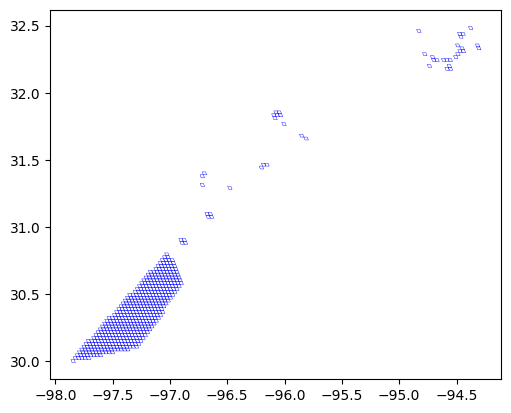

In [55]:
dataTX.geometry[0:500].plot(facecolor = 'None', edgecolor = 'Blue',linewidth = 0.3)

In [521]:
data11S = LabelEmbeddings1_5(us11S_positive_embs_avg, us11S_negative_embs_avg, us_qa_pits_11, us_qa_nonlakes_11)
data11T = LabelEmbeddings1_5(us11T_positive_embs_avg, us11T_negative_embs_avg, us_qa_pits_11, us_qa_nonlakes_11)
data11U = LabelEmbeddings1_5(us11U_positive_embs_avg, us11U_negative_embs_avg, us_qa_pits_11, us_qa_nonlakes_11)

Number of positive samples: 54
Number of positive samples: 47
Number of positive samples: 14


In [491]:
data15R = LabelEmbeddings1_5(us15R_positive_embs_avg, us15R_negative_embs_avg, us_qa_pits_15, us_qa_nonlakes_15)
data15S = LabelEmbeddings1_5(us15S_positive_embs_avg, us15S_negative_embs_avg, us_qa_pits_15, us_qa_nonlakes_15)
data15T = LabelEmbeddings1_5(us15T_positive_embs_avg, us15T_negative_embs_avg, us_qa_pits_15, us_qa_nonlakes_15)
data15U = LabelEmbeddings1_5(us15U_positive_embs_avg, us15U_negative_embs_avg, us_qa_pits_15, us_qa_nonlakes_15)

Number of positive samples: 5
Number of positive samples: 97
Number of positive samples: 81
Number of positive samples: 19


In [15]:
data16R = LabelEmbeddings1_5(us16R_positive_embs_avg, us16R_negative_embs_avg, us_qa_pits_16, us_qa_nonlakes_16)
data16S = LabelEmbeddings1_5(us16S_positive_embs_avg, us16S_negative_embs_avg, us_qa_pits_16, us_qa_nonlakes_16)
data16T = LabelEmbeddings1_5(us16T_positive_embs_avg, us16T_negative_embs_avg, us_qa_pits_16, us_qa_nonlakes_16)

Number of positive samples: 29
Number of positive samples: 152
Number of positive samples: 111


In [16]:
data17R = LabelEmbeddings1_5(us17R_positive_embs_avg, us17R_negative_embs_avg, us_qa_pits_17, us_qa_nonlakes_17)
data17S = LabelEmbeddings1_5(us17S_positive_embs_avg, us17S_negative_embs_avg, us_qa_pits_17, us_qa_nonlakes_17)
data17T = LabelEmbeddings1_5(us17T_positive_embs_avg, us17T_negative_embs_avg, us_qa_pits_17, us_qa_nonlakes_17)

Number of positive samples: 27
Number of positive samples: 146
Number of positive samples: 83


### Rasterize polygons

In [56]:
# Define function that assigns corresponding polygons to each chip
from shapely.ops import unary_union

def GetPolygonsforChips(embeddings, pit_lakes):
    """Get intersecting pit lakes for each embedding chip geometry
    """
    embeddings['pit_lake_poly'] = None
    embeddings = embeddings.reset_index(drop=True)

    for idx, chip in embeddings.iterrows():
            intersecting = pit_lakes[pit_lakes.intersects(chip['geometry'])]
            embeddings.at[idx, 'pit_lake_poly'] = intersecting['geometry'].tolist()     

    # CHANGE THIS LINE IF WANT TO KEEP EMPTY ROWS
    embeddings = embeddings[embeddings['pit_lake_poly'].apply(lambda x: len(x) > 0)] # drop empty rows
    embeddings['pit_lake_poly'] = embeddings['pit_lake_poly'].apply(lambda x: unary_union(x)) # Get multipolygons from a list
    
    #EDIT BASED ON ORIGINAL PROJECTION
    embeddings['pit_lake_poly'] = gpd.GeoSeries(embeddings['pit_lake_poly'], crs = 4326).to_crs(epsg=8857) # Convert geometries to epsg:5070
    embeddings = embeddings.to_crs(epsg=8857) # Convert geometries to epsg:5070

    return embeddings

In [61]:
# Define function to take chip embeddings with corresponding polygons and rasterize
from rasterio.features import rasterize
from shapely.geometry import Polygon

def RasterizePolygons(data_with_polys):
    """ Get rasterized polygons

    Parameters:
    data_with_polys (GeoDataFrame): Geodataframe with embedding geometries as geometry 
    and with multipolygons of pit lakes that intersect with each chip

    Outputs:
    rasters (list): list of numpy raster arrays for each chip
    """
    
    rasters = []

    for idx, chip in data_with_polys.iterrows():

        # Define raster dimensions based on chip's bounding box
        bounds = chip.geometry.bounds

        resolution = 10
        width = int((bounds[2] - bounds[0]) / resolution)
        height = int((bounds[3] - bounds[1]) / resolution)
        
        # Define raster transform
        transform = rasterio.transform.from_bounds(*bounds, width, height)
        
        # Create a list of geometries for rasterization
        geometries = [chip['pit_lake_poly']]
        
        # Rasterize the pit lakes
        chip_raster = rasterize(
            geometries,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype='uint8'
        )

        rasters.append(chip_raster)

    print(f'Last raster dimensions: {height, width}')

    return rasters

In [58]:
def Createxarray(rasters, embs_with_polys):
    """Convert list of chip rasters to xarrays
    """
    rasters_xr = []

    for i in range(len(rasters)):
        lon_min, lat_min, lon_max, lat_max = embs_with_polys.geometry[i].bounds

        # Generate latitude and longitude arrays
        latitudes = np.linspace(lat_max, lat_min, rasters[i].shape[0])
        longitudes = np.linspace(lon_min, lon_max, rasters[i].shape[1])

        # Create xarray DataArray
        data_array = xr.DataArray(
            rasters[i],
            dims=["lat", "lon"],
            coords={"lat": latitudes, "lon": longitudes},
            name="pit_lakes" 
        )

        # Create xarray Dataset
        dataset = xr.Dataset({"pit_lakes": data_array})
        rasters_xr.append(dataset)

    return rasters_xr

In [25]:
# Minnesota - deprecated
chips_with_polygons = mn_data[mn_data['mine']==1] # Ensure this is right mn_data
chips_with_polygons = chips_with_polygons.drop_duplicates('geometry')
mn_data_with_polys = GetPolygonsforChips(chips_with_polygons, dnr_pit_lakes)

embs_with_polys = pd.concat([mn_data_with_polys,az_data_with_polys]).reset_index(drop=True)

# Aquarry mine testing
chips_with_polygons = aquarry_mn_mines.drop_duplicates('geometry')
aq_data_with_polys = GetPolygonsforChips(chips_with_polygons, aquarry_only_pits)
embs_with_polys = aq_data_with_polys
rasters = RasterizePolygons(embs_with_polys)
rasters_xr = Createxarray(rasters, embs_with_polys)

NameError: name 'mn_data' is not defined

In [59]:
# Get intersecting pit lakes and rasterize
import xarray as xr
mn_data_mines = dataMN.drop_duplicates('geometry')

mn_chips_with_polygons = mn_data_mines
mn_embs_with_polys = GetPolygonsforChips(mn_chips_with_polygons, mn_aggregated_pits) # drops rows without intersection
mn_rasters = RasterizePolygons(mn_embs_with_polys)
mn_embs_with_polys = mn_embs_with_polys.reset_index(drop=True)
mn_rasters_xr = Createxarray(mn_rasters, mn_embs_with_polys)

Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dim

In [60]:
# Get intersecting pit lakes and rasterize - AZ NV
az_nv_data_mines = dataAZNV.drop_duplicates('geometry')

az_nv_chips_with_polygons = az_nv_data_mines
az_nv_embs_with_polys = GetPolygonsforChips(az_nv_chips_with_polygons, az_nv_qa_pits) # drops rows without intersection
az_nv_rasters = RasterizePolygons(az_nv_embs_with_polys)
az_nv_embs_with_polys = az_nv_embs_with_polys.reset_index(drop=True)
az_nv_rasters_xr = Createxarray(az_nv_rasters, az_nv_embs_with_polys)

Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dim

In [62]:
# Get intersecting pit lakes and rasterize - GA
ga_data_mines = dataGA.drop_duplicates('geometry')

ga_chips_with_polygons = ga_data_mines
ga_embs_with_polys = GetPolygonsforChips(ga_chips_with_polygons, ga_qa_pits) # drops rows without intersection
ga_rasters = RasterizePolygons(ga_embs_with_polys)
ga_embs_with_polys = ga_embs_with_polys.reset_index(drop=True)
ga_rasters_xr = Createxarray(ga_rasters, ga_embs_with_polys)

Last raster dimensions: (256, 256)


In [64]:
# Get intersecting pit lakes and rasterize - IL IN KY MS
il_in_ky_ms_data_mines = dataILINKYMS.drop_duplicates('geometry')

il_in_ky_ms_chips_with_polygons = il_in_ky_ms_data_mines
il_in_ky_ms_embs_with_polys = GetPolygonsforChips(il_in_ky_ms_chips_with_polygons, il_in_ky_ms_qa_pits) # drops rows without intersection
il_in_ky_ms_rasters = RasterizePolygons(il_in_ky_ms_embs_with_polys)
il_in_ky_ms_embs_with_polys = il_in_ky_ms_embs_with_polys.reset_index(drop=True)
il_in_ky_ms_rasters_xr = Createxarray(il_in_ky_ms_rasters, il_in_ky_ms_embs_with_polys)

Last raster dimensions: (256, 256)


In [66]:
# Get intersecting pit lakes and rasterize - MT WY
mt_wy_data_mines = dataMTWY.drop_duplicates('geometry')

mt_wy_chips_with_polygons = mt_wy_data_mines
mt_wy_embs_with_polys = GetPolygonsforChips(mt_wy_chips_with_polygons, mt_wy_qa_pits) # drops rows without intersection
mt_wy_rasters = RasterizePolygons(mt_wy_embs_with_polys)
mt_wy_embs_with_polys = mt_wy_embs_with_polys.reset_index(drop=True)
mt_wy_rasters_xr = Createxarray(mt_wy_rasters, mt_wy_embs_with_polys)

Last raster dimensions: (256, 256)


In [65]:
# Get intersecting pit lakes and rasterize - TX
tx_data_mines = dataTX.drop_duplicates('geometry')

tx_chips_with_polygons = tx_data_mines
tx_embs_with_polys = GetPolygonsforChips(tx_chips_with_polygons, tx_qa_pits) # drops rows without intersection
tx_rasters = RasterizePolygons(tx_embs_with_polys)
tx_embs_with_polys = tx_embs_with_polys.reset_index(drop=True)
tx_rasters_xr = Createxarray(tx_rasters, tx_embs_with_polys)

Last raster dimensions: (256, 256)


In [522]:
import xarray as xr

# Get intersecting pit lakes and rasterize
us_data_mines11 = pd.concat([data11S, data11T, data11U]).drop_duplicates('geometry')

us_chips_with_polygons11 = us_data_mines11
us_embs_with_polys11 = GetPolygonsforChips(us_chips_with_polygons11, us_qa_pits_11) # drops rows without intersection
us_rasters11 = RasterizePolygons(us_embs_with_polys11)
us_embs_with_polys11 = us_embs_with_polys11.reset_index(drop=True)
us_rasters_xr11 = Createxarray(us_rasters11, us_embs_with_polys11)

Raster dimensions: (1846, 1825)
Raster dimensions: (1846, 1824)
Raster dimensions: (1845, 1824)
Raster dimensions: (1844, 1822)
Raster dimensions: (1846, 1827)
Raster dimensions: (1845, 1827)
Raster dimensions: (1841, 1820)
Raster dimensions: (1846, 1824)
Raster dimensions: (1845, 1824)
Raster dimensions: (1847, 1824)
Raster dimensions: (1843, 1823)
Raster dimensions: (1842, 1823)
Raster dimensions: (1843, 1823)
Raster dimensions: (1848, 1824)
Raster dimensions: (1844, 1823)
Raster dimensions: (1839, 1818)
Raster dimensions: (1833, 1819)
Raster dimensions: (1846, 1827)
Raster dimensions: (1841, 1820)
Raster dimensions: (1845, 1824)
Raster dimensions: (1847, 1824)
Raster dimensions: (1846, 1825)
Raster dimensions: (1844, 1822)
Raster dimensions: (1832, 1816)
Raster dimensions: (1832, 1816)
Raster dimensions: (1830, 1815)
Raster dimensions: (1829, 1815)
Raster dimensions: (1841, 1820)
Raster dimensions: (1839, 1818)
Raster dimensions: (1834, 1820)
Raster dimensions: (1832, 1813)
Raster d

In [495]:
import xarray as xr

# Get intersecting pit lakes and rasterize
us_data_mines15 = pd.concat([data15R, data15S, data15T, data15U]).drop_duplicates('geometry')

us_chips_with_polygons15 = us_data_mines15
us_embs_with_polys15 = GetPolygonsforChips(us_chips_with_polygons15, us_qa_pits_15) # drops rows without intersection
us_rasters15 = RasterizePolygons(us_embs_with_polys15)
us_embs_with_polys15 = us_embs_with_polys15.reset_index(drop=True)
us_rasters_xr15 = Createxarray(us_rasters15, us_embs_with_polys15)

Raster dimensions: (1593, 1586)
Raster dimensions: (1593, 1587)
Raster dimensions: (1593, 1588)
Raster dimensions: (1593, 1586)
Raster dimensions: (1592, 1586)
Raster dimensions: (1593, 1587)
Raster dimensions: (1598, 1568)
Raster dimensions: (1596, 1569)
Raster dimensions: (1596, 1570)
Raster dimensions: (1598, 1568)
Raster dimensions: (1595, 1568)
Raster dimensions: (1596, 1569)
Raster dimensions: (1596, 1569)
Raster dimensions: (1596, 1570)
Raster dimensions: (1595, 1569)
Raster dimensions: (1596, 1572)
Raster dimensions: (1596, 1572)
Raster dimensions: (1596, 1572)
Raster dimensions: (1596, 1573)
Raster dimensions: (1596, 1572)
Raster dimensions: (1590, 1570)
Raster dimensions: (1589, 1569)
Raster dimensions: (1589, 1569)
Raster dimensions: (1590, 1570)
Raster dimensions: (1590, 1573)
Raster dimensions: (1588, 1572)
Raster dimensions: (1589, 1573)
Raster dimensions: (1590, 1573)
Raster dimensions: (1588, 1572)
Raster dimensions: (1588, 1572)
Raster dimensions: (1589, 1573)
Raster d

In [20]:
import xarray as xr

# Get intersecting pit lakes and rasterize
us_data_mines16 = pd.concat([data16R, data16S, data16T]).drop_duplicates('geometry')

us_chips_with_polygons16 = us_data_mines16
us_embs_with_polys16 = GetPolygonsforChips(us_chips_with_polygons16, us_qa_pits_16) # drops rows without intersection
us_rasters16 = RasterizePolygons(us_embs_with_polys16)
us_embs_with_polys16 = us_embs_with_polys16.reset_index(drop=True)
us_rasters_xr16 = Createxarray(us_rasters16, us_embs_with_polys16)

Raster dimensions: (1669, 1662)
Raster dimensions: (1670, 1663)
Raster dimensions: (1670, 1664)
Raster dimensions: (1669, 1664)
Raster dimensions: (1682, 1684)
Raster dimensions: (1683, 1678)
Raster dimensions: (1683, 1679)
Raster dimensions: (1682, 1686)
Raster dimensions: (1682, 1686)
Raster dimensions: (1682, 1686)
Raster dimensions: (1682, 1687)
Raster dimensions: (1682, 1687)
Raster dimensions: (1681, 1688)
Raster dimensions: (1681, 1689)
Raster dimensions: (1681, 1690)
Raster dimensions: (1681, 1690)
Raster dimensions: (1681, 1691)
Raster dimensions: (1681, 1691)
Raster dimensions: (1680, 1691)
Raster dimensions: (1681, 1691)
Raster dimensions: (1681, 1691)
Raster dimensions: (1680, 1692)
Raster dimensions: (1681, 1692)
Raster dimensions: (1683, 1679)
Raster dimensions: (1682, 1684)
Raster dimensions: (1681, 1691)
Raster dimensions: (1681, 1692)
Raster dimensions: (1680, 1692)
Raster dimensions: (1682, 1686)
Raster dimensions: (1681, 1692)
Raster dimensions: (1681, 1689)
Raster d

In [66]:
# Get intersecting pit lakes and rasterize
import xarray as xr

us_data_mines17 = pd.concat([data17R, data17S, data17T])

us_chips_with_polygons17 = us_data_mines17.drop_duplicates('geometry')
us_embs_with_polys17 = GetPolygonsforChips(us_chips_with_polygons17, us_qa_pits_17) # drops empty rows
us_rasters17 = RasterizePolygons(us_embs_with_polys17)
us_embs_with_polys17 = us_embs_with_polys17.reset_index(drop=True)
us_rasters_xr17 = Createxarray(us_rasters17, us_embs_with_polys17) 

Raster dimensions: (1750, 1760)
Raster dimensions: (1751, 1760)
Raster dimensions: (1751, 1761)
Raster dimensions: (1749, 1760)
Raster dimensions: (1750, 1760)
Raster dimensions: (1750, 1761)
Raster dimensions: (1751, 1761)
Raster dimensions: (1749, 1760)
Raster dimensions: (1749, 1761)
Raster dimensions: (1750, 1761)
Raster dimensions: (1750, 1762)
Raster dimensions: (1751, 1762)
Raster dimensions: (1748, 1761)
Raster dimensions: (1749, 1761)
Raster dimensions: (1749, 1762)
Raster dimensions: (1753, 1758)
Raster dimensions: (1753, 1758)
Raster dimensions: (1752, 1758)
Raster dimensions: (1753, 1759)
Raster dimensions: (1751, 1759)
Raster dimensions: (1751, 1759)
Raster dimensions: (1752, 1755)
Raster dimensions: (1757, 1751)
Raster dimensions: (1756, 1751)
Raster dimensions: (1757, 1752)
Raster dimensions: (1752, 1758)
Raster dimensions: (1752, 1755)
Raster dimensions: (1751, 1762)
Raster dimensions: (1750, 1762)
Raster dimensions: (1770, 1746)
Raster dimensions: (1769, 1748)
Raster d

### NDWI Filtering

In [67]:
# Optimize GDAL settings for cloud optimized reading
def SearchSTAC(aoi, start, end):
    os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
    os.environ["AWS_REQUEST_PAYER"] = "requester"

    STAC_API = "https://earth-search.aws.element84.com/v1"
    COLLECTION = "sentinel-2-l2a"

    # Search the catalogue
    catalog = pystac_client.Client.open(STAC_API)
    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start}/{end}",
        intersects=aoi,
        #max_items=,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    all_items = search.get_all_items()

    # Reduce to one per date (there might be some duplicates
    # based on the location)
    items = []
    dates = []
    for item in all_items:
        if item.datetime.date() not in dates:
            items.append(item)
            dates.append(item.datetime.date())

    print(f"Found {len(items)} items")

    return items, dates

In [68]:
# CHANGE TARGET PROJECTION AS NEEDED
# Retrieve the pixel values for the bounding box in the target projection.
def RetrievePixels(items,aoi_bounds):
    dask.config.set({"array.slicing.split_large_chunks": True})
    stack = None

    if len(items) != 0:
        epsg = items[0].properties["proj:epsg"]
        gsd = 10
        valid_stacks = []
        bounds_gdf = gpd.GeoDataFrame(geometry=[aoi_bounds], crs='EPSG:8857')
        transformed_bbox = bounds_gdf.geometry[0].bounds

    if len(items) > 5:
        rand_idx = random.sample(range(0, len(items)), 5)
        items = [items[id] for id in rand_idx]
        print(f'Reduced items to {len(items)}')

    for item in items:
        try:
            # Attempt to create the stack for the current item
            stack = stackstac.stack(
                [item],  # Process one item at a time
                snap_bounds=True,
                epsg=8857,
                resolution=gsd,
                dtype="float32",
                rescale=False,
                fill_value=np.float32(0),
                assets=["green", "nir"],
                resampling=Resampling.nearest,
                chunksize=512,
                bounds=transformed_bbox
            )
            valid_stacks.append(stack)
        except RuntimeError as e:
            # Log and skip the problematic item
            print(f'Error creating stack for item {item.id}: {e}')
            continue

        if len(valid_stacks) != 0:
            combined_stack = dask.array.concatenate(valid_stacks, axis=0).compute()
            stack = stack.compute()
        
    return stack

In [69]:
# Calculate NDWI and create water mask 
def CalculateNDWI(image):
    ndwi = image
    green = image.sel(band="green")
    nir = image.sel(band="nir")

    ndwi = (green - nir) / (green + nir)
    return ndwi

In [71]:
def FilterRasters(rasters, embs_with_polys):
    # Date range
    start = "2022-06-01"    
    end = "2022-08-31"
    unfiltered_rasters_idx = []

    for i in range(len(rasters)):
        
        #Get NDWI
        aoi_epsg4326 = embs_with_polys['geometry'].to_crs(epsg=4326)[i] 
        bounds = embs_with_polys['geometry'][i]    # Should be in epsg:5070

        ndwiimages, ndwidates = SearchSTAC(aoi_epsg4326, start, end) 

        try: 
            ndwistack = RetrievePixels(ndwiimages, bounds)
            summer_composite = ndwistack.groupby('band').median(dim = 'time')
            ndwi_summer = CalculateNDWI(summer_composite)

            # Compute mask
            water_mask = xr.where(ndwi_summer > 0.05, 1, 0)

            # Ensure water mask is a square
            # Create new evenly spaced coordinates and interploate
            if water_mask.x.shape[0] != water_mask.y.shape[0]:
                new_coords = np.linspace(water_mask.coords['x'][0], water_mask.coords['x'][-2], water_mask.x.shape[0])

                water_mask_resampled = water_mask.interp(x=new_coords)
            else:
                water_mask_resampled = water_mask

            # Rename coords to match
            water_mask_resampled = water_mask_resampled.rename({'y': 'lat', 'x': 'lon'})
            print(f'Water mask positive pixels: {water_mask_resampled.sum().values}')

            # Resample to make water mask match pit lake rasters
            water_mask_resampled = water_mask_resampled.interp(lat=rasters[i]['pit_lakes']['lat'].values,lon=rasters[i]['pit_lakes']['lon'].values, method='nearest')

            print(f'Water mask positive pixels after resampling: {water_mask_resampled.sum().values}')
    
            mask = (rasters[i]['pit_lakes'] == 1).compute()
            print(f'Positive pit lake pixels: {mask.sum().values}')

            rasters[i]['filtered_pit_lakes'] = rasters[i]['pit_lakes']
            rasters[i]['filtered_pit_lakes'] = xr.where(mask, water_mask_resampled, rasters[i]['pit_lakes'])
            print(f'Filtered raster shape: {rasters[i]['filtered_pit_lakes'].shape}')
            print(f'Positive pit lake pixels after filtering: {rasters[i]['filtered_pit_lakes'].sum().values}')

        except RuntimeError as e:
            print(f'Error filtering raster {i}')
            unfiltered_rasters_idx.append(i)
            continue
        
        except AttributeError:
            print(f'No images found for {i}')
            unfiltered_rasters_idx.append(i)
            continue

    return rasters

In [74]:
# Get filtered polygons for MN
us_resultsmn = FilterRasters(mn_rasters_xr, mn_embs_with_polys)

# Note: any chips that images were not found have no filter

Found 7 items
Reduced items to 5
Water mask positive pixels: 75
Water mask positive pixels after resampling: 73.0
Positive pit lake pixels: 246
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 20.0
Found 5 items
Water mask positive pixels: 6479
Water mask positive pixels after resampling: 6437.0
Positive pit lake pixels: 214
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 9.0
Found 5 items
Water mask positive pixels: 800
Water mask positive pixels after resampling: 764.0
Positive pit lake pixels: 5254
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 749.0
Found 5 items
Water mask positive pixels: 5953
Water mask positive pixels after resampling: 5814.0
Positive pit lake pixels: 1530
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 576.0
Found 5 items
Water mask positive pixels: 1559
Water mask positive pixels after resampling: 1537.0
Positive pit lake pixels: 1136
Filtered raste

In [75]:
# Get filtered polygons for AZ NV
us_resultsaznv = FilterRasters(az_nv_rasters_xr, az_nv_embs_with_polys)

# Get filtered polygons for GA
us_resultsga = FilterRasters(ga_rasters_xr, ga_embs_with_polys)

Found 20 items
Reduced items to 5
Water mask positive pixels: 6388
Water mask positive pixels after resampling: 6388.0
Positive pit lake pixels: 15039
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 6388.0
Found 19 items
Reduced items to 5
Water mask positive pixels: 636
Water mask positive pixels after resampling: 631.0
Positive pit lake pixels: 1537
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 483.0
Found 17 items
Reduced items to 5
Water mask positive pixels: 269
Water mask positive pixels after resampling: 269.0
Positive pit lake pixels: 1703
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 269.0
Found 22 items
Reduced items to 5
Water mask positive pixels: 44
Water mask positive pixels after resampling: 42.0
Positive pit lake pixels: 825
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 0.0
Found 22 items
Reduced items to 5
Water mask positive pixels: 2776
Water mask pos

In [76]:
# Get filtered polygons for IL IN KY MS
us_resultsilinkyms = FilterRasters(il_in_ky_ms_rasters_xr, il_in_ky_ms_embs_with_polys)

# Get filtered polygons for MT WY
us_resultsmtwy = FilterRasters(mt_wy_rasters_xr, mt_wy_embs_with_polys)

# Get filtered polygons for TX
us_resultstx = FilterRasters(tx_rasters_xr, tx_embs_with_polys)

Found 12 items
Reduced items to 5
Water mask positive pixels: 3101
Water mask positive pixels after resampling: 3082.0
Positive pit lake pixels: 9475
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 1437.0
Found 12 items
Reduced items to 5
Water mask positive pixels: 186
Water mask positive pixels after resampling: 177.0
Positive pit lake pixels: 1237
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 155.0
Found 6 items
Reduced items to 5
Water mask positive pixels: 2761
Water mask positive pixels after resampling: 2710.0
Positive pit lake pixels: 3969
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 453.0
Found 6 items
Reduced items to 5
Water mask positive pixels: 443
Water mask positive pixels after resampling: 408.0
Positive pit lake pixels: 2013
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 71.0
Found 6 items
Reduced items to 5
Water mask positive pixels: 1720
Water mask p

In [523]:
# Get filtered polygons for US 16
us_results11 = FilterRasters(us_rasters_xr11, us_embs_with_polys11)

# Note: any chips that images were not found have no filter

Found 14 items
Reduced items to 5
Water mask positive pixels: 176.09638554200066
Water mask positive pixels after resampling: 176.0963855420007
Positive pit lake pixels: 542
Filtered raster shape: (1846, 1825)
Positive pit lake pixels after filtering: 76.04162102947012
Found 9 items
Reduced items to 5
Water mask positive pixels: 94.05153508770745
Water mask positive pixels after resampling: 94.05153508770744
Positive pit lake pixels: 2776
Filtered raster shape: (1846, 1824)
Positive pit lake pixels after filtering: 94.05153508770746
Found 9 items
Reduced items to 5
Water mask positive pixels: 488.26739726036317
Water mask positive pixels after resampling: 488.2673972603631
Positive pit lake pixels: 2773
Filtered raster shape: (1845, 1824)
Positive pit lake pixels after filtering: 98.05369863016531
Found 18 items
Reduced items to 5
Water mask positive pixels: 1957.073545554443
Water mask positive pixels after resampling: 1957.073545554443
Positive pit lake pixels: 7531
Filtered raster s

In [500]:
# Get filtered polygons for US 16
us_results15 = FilterRasters(us_rasters_xr15, us_embs_with_polys15)

# Note: any chips that images were not found have no filter

Found 7 items
Reduced items to 5
Water mask positive pixels: 36774.15752993038
Water mask positive pixels after resampling: 36614.354127283856
Positive pit lake pixels: 38322
Filtered raster shape: (1593, 1586)
Positive pit lake pixels after filtering: 9152.204788909956
Found 2 items
Water mask positive pixels: 47502.894836272215
Water mask positive pixels after resampling: 47298.1977329977
Positive pit lake pixels: 82106
Filtered raster shape: (1593, 1587)
Positive pit lake pixels after filtering: 23913.85642317437
Found 2 items
Water mask positive pixels: 25544.075566749805
Water mask positive pixels after resampling: 25495.061083122633
Positive pit lake pixels: 12790
Filtered raster shape: (1593, 1588)
Positive pit lake pixels after filtering: 1328.8362720402536
Found 7 items
Reduced items to 5
Water mask positive pixels: 23662.910466582773
Water mask positive pixels after resampling: 23650.906052963608
Positive pit lake pixels: 34728
Filtered raster shape: (1593, 1586)
Positive pit

In [ ]:
# Get filtered polygons for US 16
us_results16 = FilterRasters(us_rasters_xr16, us_embs_with_polys16)

# Note: any chips that images were not found have no filter

Found 7 items
Reduced items to 4
Water mask positive pixels: 26388.858689115805
Water mask positive pixels after resampling: 26107.915814792235
Positive pit lake pixels: 37099
Filtered raster shape: (1669, 1662)
Positive pit lake pixels after filtering: 3264.5622369214425
Found 7 items
Reduced items to 4
Water mask positive pixels: 27568.557692307906
Water mask positive pixels after resampling: 27465.21935096171
Positive pit lake pixels: 20823
Filtered raster shape: (1670, 1663)
Positive pit lake pixels after filtering: 5416.7836538463125
Found 5 items
Water mask positive pixels: 73240.98858173085
Water mask positive pixels after resampling: 73055.24278846153
Positive pit lake pixels: 74783
Filtered raster shape: (1670, 1664)
Positive pit lake pixels after filtering: 22661.709735576977
Found 5 items
Water mask positive pixels: 42279.37777777849
Water mask positive pixels after resampling: 42037.701501502284
Positive pit lake pixels: 38323
Filtered raster shape: (1669, 1664)
Positive pi

In [67]:
# Get filtered polygons for US 17
us_results17 = FilterRasters(us_rasters_xr17, us_embs_with_polys17)

# Note: any chips that images were not found have no filter

Found 0 items
No images found for 0
Found 1 items
Water mask positive pixels: 81911.4877910269
Water mask positive pixels after resampling: 81181.5792163534
Positive pit lake pixels: 32599
Filtered raster shape: (1751, 1760)
Positive pit lake pixels after filtering: 0.0
Found 1 items
Water mask positive pixels: 319713.44917660387
Water mask positive pixels after resampling: 318919.57126632583
Positive pit lake pixels: 10985
Filtered raster shape: (1751, 1761)
Positive pit lake pixels after filtering: 0.0
Found 0 items
No images found for 3
Found 0 items
No images found for 4
Found 0 items
No images found for 5
Found 0 items
No images found for 6
Found 0 items
No images found for 7
Found 0 items
No images found for 8
Found 0 items
No images found for 9
Found 0 items
No images found for 10
Found 0 items
No images found for 11
Found 0 items
No images found for 12
Found 0 items
No images found for 13
Found 0 items
No images found for 14
Found 0 items
No images found for 15
Found 1 items
Wa

In [ ]:
#Attempt to store, unfinished

combined1 = xr.concat(us_results[0:150], dim="band")  # Combine along a new dimension "band"
combined1 = combined1.assign_coords(band=range(1, 150 + 1))  # Assign band numbers

# Write to a multi-band GeoTIFF
combined1.rio.write_crs("EPSG:32615", inplace=True)  # Set CRS
combined1.rio.to_raster("data/us_rasters_xr16_1.tif")

combined2 = xr.concat(us_results[150:300], dim="band")  # Combine along a new dimension "band"
combined2 = combined2.assign_coords(band=range(151, 300 + 1))  # Assign band numbers

# Write to a multi-band GeoTIFF
combined2.rio.write_crs("EPSG:32615", inplace=True)  # Set CRS
combined2.rio.to_raster("data/us_rasters_xr16_2.tif")


combined1 = xr.concat(us_results17[0:130], dim="band")  # Combine along a new dimension "band"
combined1 = combined1.assign_coords(band=range(1, 130 + 1))  # Assign band numbers
combined1.rio.write_crs("EPSG:32615", inplace=True)  # Set CRS
combined1.rio.to_raster("data/us_rasters_xr17_1.tif")

combined2 = xr.concat(us_results17[130:267], dim="band")  # Combine along a new dimension "band"
combined2 = combined2.assign_coords(band=range(131, 267 + 1))  # Assign band numbers
combined2.rio.write_crs("EPSG:32615", inplace=True)  # Set CRS
combined2.rio.to_raster("data/us_rasters_xr17_2.tif")



In [62]:
# Visually inspect NDWI filters
us_results_inspection = us_results16

for i in range(0,4):
    #us_results_inspection[i] = us_results_inspection[i].rename({'lon': 'x', 'lat': 'y'})
    us_results_inspection[i]['filtered_pit_lakes'].rio.write_crs("EPSG:5070", inplace=True)  # Set CRS
    us_results_inspection[i]['filtered_pit_lakes'].rio.to_raster(f"data/filtered_lakes_{i + 1}.tif")

In [72]:
# Resample to 256 x 256
def TrainingResample(rasters):
    rasters_list = []

    for i in range(len(rasters)):
        lat_min = float(rasters[i]['filtered_pit_lakes']['lat'].min().values)
        lat_max = float(rasters[i]['filtered_pit_lakes']['lat'].max().values)
        lon_min = float(rasters[i]['filtered_pit_lakes']['lon'].min().values)
        lon_max = float(rasters[i]['filtered_pit_lakes']['lon'].max().values)
        new_lat = np.linspace(lat_min, lat_max, 256)
        new_lon = np.linspace(lon_min, lon_max, 256)

        # Interpolate to the new grid
        resampled = rasters[i]['filtered_pit_lakes'].interp(lat=new_lat, lon=new_lon, method='nearest')
        rasters_list.append(resampled)

    return rasters_list

In [441]:
# Resample to 256 x 256 - USE IF NOT FILTERING
def TrainingResample(rasters):
    rasters_list = []

    for i in range(len(rasters)):
        lat_min = float(rasters[i]['pit_lakes']['lat'].min().values)
        lat_max = float(rasters[i]['pit_lakes']['lat'].max().values)
        lon_min = float(rasters[i]['pit_lakes']['lon'].min().values)
        lon_max = float(rasters[i]['pit_lakes']['lon'].max().values)
        new_lat = np.linspace(lat_min, lat_max, 256)
        new_lon = np.linspace(lon_min, lon_max, 256)

        # Interpolate to the new grid
        resampled = rasters[i]['pit_lakes'].interp(lat=new_lat, lon=new_lon, method='nearest')
        rasters_list.append(resampled)

    return rasters_list

In [494]:
# Drop any rasters without any pit lake intersections - MN
final_indices = []
mn_embs_with_polys_reset = mn_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsmn):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

mn_results_clean = [xr for i, xr in enumerate(us_resultsmn) if i in final_indices]

resampled_mn = TrainingResample(mn_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
mn_embs_with_polys_dropped = mn_embs_with_polys_reset.loc[final_indices]
print(len(mn_embs_with_polys_dropped))
print(len(resampled_mn))

150
150


In [442]:
# Drop any rasters without any pit lake intersections - MN
final_indices = []
mn_embs_with_polys_reset = mn_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsmn):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

mn_results_clean = [xr for i, xr in enumerate(us_resultsmn) if i in final_indices]

resampled_mn = TrainingResample(mn_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
mn_embs_with_polys_dropped = mn_embs_with_polys_reset.loc[final_indices]
print(len(mn_embs_with_polys_dropped))
print(len(resampled_mn))

156
156


In [498]:
# Drop any rasters without any pit lake intersections - AZ NV
final_indices = []
az_nv_embs_with_polys_reset = az_nv_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsaznv):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

aznv_results_clean = [xr for i, xr in enumerate(us_resultsaznv) if i in final_indices]

resampled_aznv = TrainingResample(aznv_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
az_nv_embs_with_polys_dropped = az_nv_embs_with_polys_reset.loc[final_indices]
print(len(az_nv_embs_with_polys_dropped))
print(len(resampled_aznv))

48
48


In [443]:
# Drop any rasters without any pit lake intersections - AZ NV
final_indices = []
az_nv_embs_with_polys_reset = az_nv_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsaznv):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

aznv_results_clean = [xr for i, xr in enumerate(us_resultsaznv) if i in final_indices]

resampled_aznv = TrainingResample(aznv_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
az_nv_embs_with_polys_dropped = az_nv_embs_with_polys_reset.loc[final_indices]
print(len(az_nv_embs_with_polys_dropped))
print(len(resampled_aznv))

56
56


In [400]:
# Drop any rasters without any pit lake intersections - GA
final_indices = []
ga_embs_with_polys_reset = ga_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsga):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

ga_results_clean = [xr for i, xr in enumerate(us_resultsga) if i in final_indices]

resampled_ga = TrainingResample(ga_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
ga_embs_with_polys_dropped = ga_embs_with_polys_reset.loc[final_indices]
print(len(ga_embs_with_polys_dropped))
print(len(resampled_ga))

79
79


In [444]:
# Drop any rasters without any pit lake intersections - GA
final_indices = []
ga_embs_with_polys_reset = ga_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsga):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

ga_results_clean = [xr for i, xr in enumerate(us_resultsga) if i in final_indices]

resampled_ga = TrainingResample(ga_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
ga_embs_with_polys_dropped = ga_embs_with_polys_reset.loc[final_indices]
print(len(ga_embs_with_polys_dropped))
print(len(resampled_ga))

158
158


In [401]:
# Drop any rasters without any pit lake intersections - IL IN KY MS
final_indices = []
il_in_ky_ms_embs_with_polys_reset = il_in_ky_ms_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsilinkyms):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

ilinkyms_results_clean = [xr for i, xr in enumerate(us_resultsilinkyms) if i in final_indices]

resampled_ilinkyms = TrainingResample(ilinkyms_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
il_in_ky_ms_embs_with_polys_dropped = il_in_ky_ms_embs_with_polys_reset.loc[final_indices]
print(len(il_in_ky_ms_embs_with_polys_dropped))
print(len(resampled_ilinkyms))

188
188


In [445]:
# Drop any rasters without any pit lake intersections - IL IN KY MS
final_indices = []
il_in_ky_ms_embs_with_polys_reset = il_in_ky_ms_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsilinkyms):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

ilinkyms_results_clean = [xr for i, xr in enumerate(us_resultsilinkyms) if i in final_indices]

resampled_ilinkyms = TrainingResample(ilinkyms_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
il_in_ky_ms_embs_with_polys_dropped = il_in_ky_ms_embs_with_polys_reset.loc[final_indices]
print(len(il_in_ky_ms_embs_with_polys_dropped))
print(len(resampled_ilinkyms))

200
200


In [402]:
# Drop any rasters without any pit lake intersections - MT WY
final_indices = []
mt_wy_embs_with_polys_reset = mt_wy_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsmtwy):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

mtwy_results_clean = [xr for i, xr in enumerate(us_resultsmtwy) if i in final_indices]

resampled_mtwy = TrainingResample(mtwy_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
mt_wy_embs_with_polys_dropped = mt_wy_embs_with_polys_reset.loc[final_indices]
print(len(mt_wy_embs_with_polys_dropped))
print(len(resampled_mtwy))

57
57


In [446]:
# Drop any rasters without any pit lake intersections - MT WY
final_indices = []
mt_wy_embs_with_polys_reset = mt_wy_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsmtwy):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

mtwy_results_clean = [xr for i, xr in enumerate(us_resultsmtwy) if i in final_indices]

resampled_mtwy = TrainingResample(mtwy_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
mt_wy_embs_with_polys_dropped = mt_wy_embs_with_polys_reset.loc[final_indices]
print(len(mt_wy_embs_with_polys_dropped))
print(len(resampled_mtwy))

72
72


In [403]:
# Drop any rasters without any pit lake intersections - TX
final_indices = []
tx_embs_with_polys_reset = tx_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultstx):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

tx_results_clean = [xr for i, xr in enumerate(us_resultstx) if i in final_indices]

resampled_tx = TrainingResample(tx_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
tx_embs_with_polys_dropped = tx_embs_with_polys_reset.loc[final_indices]
print(len(tx_embs_with_polys_dropped))
print(len(resampled_tx))

58
58


In [447]:
# Drop any rasters without any pit lake intersections - TX
final_indices = []
tx_embs_with_polys_reset = tx_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultstx):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

tx_results_clean = [xr for i, xr in enumerate(us_resultstx) if i in final_indices]

resampled_tx = TrainingResample(tx_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
tx_embs_with_polys_dropped = tx_embs_with_polys_reset.loc[final_indices]
print(len(tx_embs_with_polys_dropped))
print(len(resampled_tx))

61
61


#### By UTM region

In [524]:
# Drop any rasters without any pit lake intersections - 11
final_indices = []
us_embs_with_polys_reset11 = us_embs_with_polys11.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_results11):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

us_results11_clean = [xr for i, xr in enumerate(us_results11) if i in final_indices]

resampled_us11 = TrainingResample(us_results11_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped11 = us_embs_with_polys_reset11.loc[final_indices]
print(len(us_embs_with_polys_dropped11))
print(len(resampled_us11))

88
88


In [990]:
# Drop any rasters without any pit lake intersections - 11
final_indices = []
us_embs_with_polys_reset11 = us_embs_with_polys11.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_rasters_xr11):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

us_results11_clean = [xr for i, xr in enumerate(us_rasters_xr11) if i in final_indices]

resampled_us11 = TrainingResample(us_results11_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped11 = us_embs_with_polys_reset11.loc[final_indices]
print(len(us_embs_with_polys_dropped11))
print(len(resampled_us11))

117
117


In [502]:
# Drop any rasters without any pit lake intersections - 15
final_indices = []
us_embs_with_polys_reset15 = us_embs_with_polys15.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_results15):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

us_results15_clean = [xr for i, xr in enumerate(us_results15) if i in final_indices]

resampled_us15 = TrainingResample(us_results15_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped15 = us_embs_with_polys_reset15.loc[final_indices]
print(len(us_embs_with_polys_dropped15))
print(len(resampled_us15))

168
168


In [991]:
# Drop any rasters without any pit lake intersections - 15
final_indices = []
us_embs_with_polys_reset15 = us_embs_with_polys15.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_rasters_xr15):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

us_results15_clean = [xr for i, xr in enumerate(us_rasters_xr15) if i in final_indices]

resampled_us15 = TrainingResample(us_results15_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped15 = us_embs_with_polys_reset15.loc[final_indices]
print(len(us_embs_with_polys_dropped15))
print(len(resampled_us15))

214
214


In [37]:
# Drop any rasters without any pit lake intersections - 16
final_indices = []
us_embs_with_polys_reset16 = us_embs_with_polys16.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_results16):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

us_results16_clean = [xr for i, xr in enumerate(us_results16) if i in final_indices]

resampled_us16 = TrainingResample(us_results16_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped16 = us_embs_with_polys_reset16.loc[final_indices]
print(len(us_embs_with_polys_dropped16))
print(len(resampled_us16))

231
231


In [673]:
for i in range(len(us_rasters_xr16)):
    us_rasters_xr16[i]['pit_lakes'] = us_rasters_xr16[i]['pit_lakes'].rename({'x': 'lon', 'y': 'lat'})

ValueError: cannot rename 'x' because it is not a variable or dimension in this dataset

In [992]:
# Drop any rasters without any pit lake intersections - 16
final_indices = []
us_embs_with_polys_reset16 = us_embs_with_polys16.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_rasters_xr16):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

us_results16_clean = [xr for i, xr in enumerate(us_rasters_xr16) if i in final_indices]

resampled_us16 = TrainingResample(us_results16_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped16 = us_embs_with_polys_reset16.loc[final_indices]
print(len(us_embs_with_polys_dropped16))
print(len(resampled_us16))

323
323


In [68]:
# Drop any rasters without any pit lake intersections - 17
final_indices = []
us_embs_with_polys_reset17 = us_embs_with_polys17.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_results17):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

us_results17_clean = [xr for i, xr in enumerate(us_results17) if i in final_indices]

resampled_us17 = TrainingResample(us_results17_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped17 = us_embs_with_polys_reset17.loc[final_indices]
print(len(us_embs_with_polys_dropped17))
print(len(resampled_us17))

175
175


In [993]:
# Drop any rasters without any pit lake intersections - 17
final_indices = []
us_embs_with_polys_reset17 = us_embs_with_polys17.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_rasters_xr17):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

us_results17_clean = [xr for i, xr in enumerate(us_rasters_xr17) if i in final_indices]

resampled_us17 = TrainingResample(us_results17_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped17 = us_embs_with_polys_reset17.loc[final_indices]
print(len(us_embs_with_polys_dropped17))
print(len(resampled_us17))

267
267


### Train a CNN to predict pixel masks

In [305]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(256, 256), dropout_prob=0.5):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a larger feature map
        self.fc = nn.Linear(embedding_dim, 8 * 8 * 256)  # Start with a larger 256 channels feature map

        # Dropout for fully connected layer
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        # Dropout for convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.3)

        # Transpose convolution layers to upsample the feature map progressively
        # Adding Batch Normalization after each convolutional layer
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.bn1 = nn.BatchNorm2d(128)
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # 16x16 -> 32x32
        self.bn2 = nn.BatchNorm2d(64)
        
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # 32x32 -> 64x64
        self.bn3 = nn.BatchNorm2d(32)
        
        self.deconv4 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)    # 64x64 -> 128x128
        self.bn4 = nn.BatchNorm2d(16)
        
        self.deconv5 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)     # 128x128 -> 256x256

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout_fc(x)  # Apply dropout to fully connected layer
        x = x.view(-1, 256, 8, 8)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions
        x = F.relu(self.bn1(self.deconv1(x)))  # 16x16 with batch normalization
        x = self.dropout_conv(x)  # Apply dropout to convolutional layers
        
        x = F.relu(self.bn2(self.deconv2(x)))  # 32x32 with batch normalization
        x = self.dropout_conv(x)
        
        x = F.relu(self.bn3(self.deconv3(x)))  # 64x64 with batch normalization
        x = self.dropout_conv(x)
        
        x = F.relu(self.bn4(self.deconv4(x)))  # 128x128 with batch normalization
        x = self.dropout_conv(x)
        
        x = self.deconv5(x)  # Final output (256x256)

        return x


In [644]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(256, 256), dropout_prob=0.5):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 8 * 8 * 128)  # 8x8 feature map with 128 channels

        # Dropout for fully connected layer
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        # Dropout for convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.1)

        # Transpose convolution layers to upsample the feature map progressively
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   # 16x16 -> 32x32
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)   # 32x32 -> 64x64
        self.deconv4 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)    # 64x64 -> 128x128
        self.deconv5 = nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1)     # 128x128 -> 256x256

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout_fc(x)  # Apply dropout to fully connected layer
        x = x.view(-1, 128, 8, 8)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions
        x = F.relu(self.deconv1(x))  # 16x16
        x = self.dropout_conv(x)  # Apply dropout to convolutional layers
        x = F.relu(self.deconv2(x))  # 32x32
        x = self.dropout_conv(x)
        x = F.relu(self.deconv3(x))  # 64x64
        x = self.dropout_conv(x)
        x = F.relu(self.deconv4(x))  # 128x128
        x = self.deconv5(x) 
        
        return x


In [1303]:
# USING THIS ONE
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(256, 256), dropout_prob=0.5):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 4 * 4 * 32)  # 4x4 feature map with 32 channels

        # Dropout for fully connected layer
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        # Dropout for convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.1)

        # Transpose convolution layers to upsample the feature map progressively
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)  # 4x4 -> 8x8
        self.bn1 = nn.BatchNorm2d(16)

        self.deconv2 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)   # 8x8 -> 16x16
        self.bn2 = nn.BatchNorm2d(8)

        self.deconv3 = nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1)    # 16x16 -> 32x32
        self.bn3 = nn.BatchNorm2d(4)

        self.deconv4 = nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1)    # 32x32 -> 64x64
        self.bn4 = nn.BatchNorm2d(1)

        self.deconv5 = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1)    # 64x64 -> 128x128
        self.bn5 = nn.BatchNorm2d(1)

        self.deconv6 = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1)    # 128x128 -> 256x256

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout_fc(x)  # Apply dropout to fully connected layer
        x = x.view(-1, 32, 4, 4)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions with batch normalization
        x = F.relu(self.bn1(self.deconv1(x)))  # 8x8
        x = self.dropout_conv(x)  # Apply dropout to convolutional layers

        x = F.relu(self.bn2(self.deconv2(x)))  # 16x16
        x = self.dropout_conv(x)

        x = F.relu(self.bn3(self.deconv3(x)))  # 32x32

        x = F.relu(self.bn4(self.deconv4(x)))  # 64x64

        x = F.relu(self.bn5(self.deconv5(x)))  # 128x128

        x = self.deconv6(x)  # 256x256 (final layer does not need batch normalization)

        return x


In [615]:
import torch
import torch.nn as nn

class EmbeddingToRasterSimplifiedCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(256, 256)):
        super(EmbeddingToRasterSimplifiedCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size
        self.dropout_fc = nn.Dropout(p=0.5)

        # Fully connected layer to project embedding to an initial feature map
        self.fc = nn.Linear(embedding_dim, 8 * 8 * 16)  # Smaller feature map (8x8, 16 channels)

        # Transpose convolution layers with fewer parameters
        self.deconv1 = nn.ConvTranspose2d(16, 8, kernel_size=8, stride=4, padding=2)  # 8x8 -> 32x32
        self.deconv2 = nn.ConvTranspose2d(8, 1, kernel_size=8, stride=4, padding=2)   # 32x32 -> 256x256

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = self.dropout_fc(x) 
        x = x.view(-1, 16, 8, 8)  # Reshape to (batch_size, channels, height, width)

        # Upsample using fewer transposed convolutions
        x = torch.relu(self.deconv1(x))  # 32x32
        x = self.deconv2(x)              # 256x256
        return x


In [866]:
#32x32
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(32, 32), dropout_prob=0.3):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 4 * 4 * 32)  # 4x4 feature map with 32 channels

        # Dropout for fully connected layer
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        # Dropout for convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.1)

        # Transpose convolution layers to upsample the feature map progressively
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)  # 4x4 -> 8x8
        self.bn1 = nn.BatchNorm2d(16)

        self.deconv2 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)   # 8x8 -> 16x16
        self.bn2 = nn.BatchNorm2d(8)

        self.deconv3 = nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1)    # 16x16 -> 32x32

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout_fc(x)  # Apply dropout to fully connected layer
        x = x.view(-1, 32, 4, 4)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions with batch normalization
        x = F.relu(self.bn1(self.deconv1(x)))  # 8x8
        x = self.dropout_conv(x)  # Apply dropout to convolutional layers

        x = F.relu(self.bn2(self.deconv2(x)))  # 16x16
        x = self.dropout_conv(x)

        x = self.deconv3(x)  # 32x32 (final layer does not need batch normalization)

        return x


In [84]:
#32x32 - USE 
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(32, 32), dropout_prob=0.5):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 4 * 4 * 32)  # 4x4 feature map with 32 channels

        # Dropout for fully connected layer
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        # Additional convolution layers for feature extraction
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # Keep 4x4 resolution
        self.bn1_conv = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # Keep 4x4 resolution
        self.bn2_conv = nn.BatchNorm2d(32)

        # Dropout for convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.1)

        # Transpose convolution layers to upsample the feature map progressively
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)  # 4x4 -> 8x8
        self.bn1 = nn.BatchNorm2d(16)

        self.deconv2 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)   # 8x8 -> 16x16
        self.bn2 = nn.BatchNorm2d(8)

        self.deconv3 = nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1)    # 16x16 -> 32x32

        # Additional convolution layers after upsampling
        self.conv3 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)  # Keep 32x32 resolution
        self.bn3_conv = nn.BatchNorm2d(1)

        self.conv4 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)  # Keep 32x32 resolution

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout_fc(x)  # Apply dropout to fully connected layer
        x = x.view(-1, 32, 4, 4)  # Reshape to (batch_size, channels, height, width)

        # Additional convolutions for feature extraction
        x = F.relu(self.bn1_conv(self.conv1(x)))
        x = F.relu(self.bn2_conv(self.conv2(x)))

        # Upsample using transposed convolutions with batch normalization
        x = F.relu(self.bn1(self.deconv1(x)))  # 8x8
        x = self.dropout_conv(x)  # Apply dropout to convolutional layers

        x = F.relu(self.bn2(self.deconv2(x)))  # 16x16
        x = self.dropout_conv(x)

        x = self.deconv3(x)  # 32x32 (final transpose convolution layer)

        # Additional convolutions for refining the output
        x = F.relu(self.bn3_conv(self.conv3(x)))
        x = self.conv4(x)  # Final output, no activation applied

        return x


In [325]:
# 64 x 64

import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(64, 64), dropout_prob=0.5):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 4 * 4 * 64)  # 4x4 feature map with 64 channels

        # Dropout for fully connected layer
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        # Dropout for convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.1)

        # Transpose convolution layers to progressively upsample the feature map
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 4x4 -> 8x8
        self.bn1 = nn.BatchNorm2d(32)

        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.bn2 = nn.BatchNorm2d(16)

        self.deconv3 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)   # 16x16 -> 32x32
        self.bn3 = nn.BatchNorm2d(8)

        self.deconv4 = nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1)    # 32x32 -> 64x64
        self.bn4 = nn.BatchNorm2d(4)

        self.deconv5 = nn.ConvTranspose2d(4, 1, kernel_size=3, stride=1, padding=1)    # 64x64 (final layer)

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout_fc(x)  # Apply dropout to fully connected layer
        x = x.view(-1, 64, 4, 4)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions with batch normalization
        x = F.relu(self.bn1(self.deconv1(x)))  # 8x8
        x = self.dropout_conv(x)  # Apply dropout to convolutional layers

        x = F.relu(self.bn2(self.deconv2(x)))  # 16x16
        x = self.dropout_conv(x)

        x = F.relu(self.bn3(self.deconv3(x)))  # 32x32
        x = self.dropout_conv(x)

        x = F.relu(self.bn4(self.deconv4(x)))  # 64x64

        x = self.deconv5(x)  # Final layer (no activation, raw logits)

        return x

In [419]:
#16 x 16
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(16, 16), dropout_prob=0.5):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 4 * 4 * 128)  # 4x4 feature map with 128 channels

        # Dropout for fully connected layer
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        # Dropout for convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.1)

        # Transpose convolution layers to progressively upsample the feature map
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 4x4 -> 8x8
        self.bn1 = nn.BatchNorm2d(64)

        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   # 8x8 -> 16x16
        self.bn2 = nn.BatchNorm2d(32)

        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)    # 16x16 (final layer)

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout_fc(x)  # Apply dropout to fully connected layer
        x = x.view(-1, 128, 4, 4)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions with batch normalization
        x = F.relu(self.bn1(self.deconv1(x)))  # 8x8
        x = self.dropout_conv(x)  # Apply dropout to convolutional layers

        x = F.relu(self.bn2(self.deconv2(x)))  # 16x16

        x = self.deconv3(x)  # Final layer (no activation, raw logits)

        return x


In [349]:
#8 x 8 
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingToRasterCNN(nn.Module):
    def __init__(self, embedding_dim=1024, output_size=(8, 8), dropout_prob=0.5):
        super(EmbeddingToRasterCNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_size = output_size

        # Fully connected layer to project embedding to a smaller feature map
        self.fc = nn.Linear(embedding_dim, 4 * 4 * 64)  # 4x4 feature map with 64 channels

        # Dropout for fully connected layer
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        # Dropout for convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.1)

        # Transpose convolution layers to progressively upsample the feature map
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 4x4 -> 8x8
        self.bn1 = nn.BatchNorm2d(32)

        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)    # 8x8 (final layer)

    def forward(self, x):
        # Fully connected layer to create an initial feature map
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout_fc(x)  # Apply dropout to fully connected layer
        x = x.view(-1, 64, 4, 4)  # Reshape to (batch_size, channels, height, width)

        # Upsample using transposed convolutions with batch normalization
        x = F.relu(self.bn1(self.deconv1(x)))  # 8x8
        x = self.dropout_conv(x)  # Apply dropout to convolutional layers

        x = self.deconv2(x)  # Final layer (no activation, raw logits)

        return x


In [85]:
from torch.utils.data import Dataset

class EmbeddingRasterDataset(Dataset):
    """
        Initializes the dataset with inputs (embeddings) and targets (rasters).

        Args:
            embeddings (numpy.ndarray or torch.Tensor): Input embeddings, shape (num_samples, 1024).
            rasters (numpy.ndarray or torch.Tensor): Target rasters, shape (num_samples, 256, 256).
    """
    def __init__(self, embeddings, rasters):
        self.embeddings = embeddings
        self.rasters = rasters

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        raster = self.rasters[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(raster, dtype=torch.float32)


In [ ]:
# 16
#resampled_us_256 = TrainingResample(filtered_results)

index_to_drop = us_embs_with_polys_dropped_aug[us_embs_with_polys_dropped_aug['embeddings_array'].isna() == True].index[0]
us_embs_with_polys_dropped_aug = us_embs_with_polys_dropped_aug.drop(index = index_to_drop)

resampled_us_dropped_256 = resampled_us_256[:index_to_drop] + resampled_us_256[index_to_drop+1:]

print(len(resampled_us_dropped_256))
print(len(us_embs_with_polys_dropped_aug))


In [448]:
targetdim = 16
patchsize = int(256/targetdim)

In [ ]:
# AZ NV Clean training data and convert list of arrays to array
resampled_aznv_np = resampled_aznv
for i in range(len(resampled_aznv)):
    resampled_aznv_np[i] = np.array(resampled_aznv[i])

resampled_aznv_np = np.where(np.isnan(resampled_aznv_np), 0, resampled_aznv_np) 
resampled_aznv_np = np.round_(resampled_aznv_np) # Account for interpolation differences
resampled_aznv_np = np.int_(resampled_aznv_np)

# Flip numpy arrays so it aligns with image
resampled_aznv_np = np.flip(resampled_aznv_np, axis=1) 

# Save pixels per 256 after filtering to DF for classification
aznv_data = az_nv_embs_with_polys_dropped.reset_index(drop = True)
aznv_data['pixel_pct'] = 0
for i in range(len(az_nv_embs_with_polys_dropped)):
    aznv_data.at[i, 'pixel_pct'] = (resampled_aznv_np[i].sum() / (256*256))

samples = len(resampled_aznv_np)
resampled_aznv_np_32 = resampled_aznv_np.reshape(samples, targetdim, patchsize, targetdim, patchsize).max(axis=(2, 4))  # Max along the 8-row and 8-column axes
print(resampled_aznv_np_32.shape)


# GA Clean training data and convert list of arrays to array
resampled_ga_np = resampled_ga
for i in range(len(resampled_ga)):
    resampled_ga_np[i] = np.array(resampled_ga[i])

resampled_ga_np = np.where(np.isnan(resampled_ga_np), 0, resampled_ga_np) 
resampled_ga_np = np.round_(resampled_ga_np) # Account for interpolation differences
resampled_ga_np = np.int_(resampled_ga_np)

# Flip numpy arrays so it aligns with image
resampled_ga_np = np.flip(resampled_ga_np, axis=1) 

# Save pixels per 256 after filtering to DF for classification
ga_data = ga_embs_with_polys_dropped.reset_index(drop = True)
ga_data['pixel_pct'] = 0
for i in range(len(ga_embs_with_polys_dropped)):
    ga_data.at[i, 'pixel_pct'] = (resampled_ga_np[i].sum() / (256*256))

samples = len(resampled_ga_np)
resampled_ga_np_32 = resampled_ga_np.reshape(samples, targetdim, patchsize, targetdim, patchsize).max(axis=(2, 4))  # Max along the 8-row and 8-column axes
print(resampled_ga_np_32.shape)


# IL IN KY MS Clean training data and convert list of arrays to array
resampled_ilinkyms_np = resampled_ilinkyms
for i in range(len(resampled_ilinkyms)):
    resampled_ilinkyms_np[i] = np.array(resampled_ilinkyms[i])

resampled_ilinkyms_np = np.where(np.isnan(resampled_ilinkyms_np), 0, resampled_ilinkyms_np) 
resampled_ilinkyms_np = np.round_(resampled_ilinkyms_np) # Account for interpolation differences
resampled_ilinkyms_np = np.int_(resampled_ilinkyms_np)

# Flip numpy arrays so it aligns with image
resampled_ilinkyms_np = np.flip(resampled_ilinkyms_np, axis=1) 

# Save pixels per 256 after filtering to DF for classification
ilinkyms_data = il_in_ky_ms_embs_with_polys_dropped.reset_index(drop = True)
ilinkyms_data['pixel_pct'] = 0
for i in range(len(il_in_ky_ms_embs_with_polys_dropped)):
    ilinkyms_data.at[i, 'pixel_pct'] = (resampled_ilinkyms_np[i].sum() / (256*256))


samples = len(resampled_ilinkyms_np)
resampled_ilinkyms_np_32 = resampled_ilinkyms_np.reshape(samples, targetdim, patchsize, targetdim, patchsize).max(axis=(2, 4))  # Max along the 8-row and 8-column axes
print(resampled_ilinkyms_np_32.shape)


(48, 16, 16)
(158, 16, 16)
(200, 16, 16)


In [519]:
# MN Clean training data and convert list of arrays to array
resampled_mn_np = resampled_mn
for i in range(len(resampled_mn)):
    resampled_mn_np[i] = np.array(resampled_mn[i])

resampled_mn_np = np.where(np.isnan(resampled_mn_np), 0, resampled_mn_np) 
resampled_mn_np = np.round_(resampled_mn_np) # Account for interpolation differences
resampled_mn_np = np.int_(resampled_mn_np)

# Flip numpy arrays so it aligns with image
resampled_mn_np = np.flip(resampled_mn_np, axis=1) 

# Save pixels per 256 after filtering to DF for classification
mn_data = mn_embs_with_polys_dropped.reset_index(drop = True)
mn_data['pixel_pct'] = 0
for i in range(len(mn_embs_with_polys_dropped)):
    mn_data.at[i, 'pixel_pct'] = (resampled_mn_np[i].sum() / (256*256))


samples = len(resampled_mn_np)
resampled_mn_np_32 = resampled_mn_np.reshape(samples, targetdim, patchsize, targetdim, patchsize).max(axis=(2, 4))  # Max along the 8-row and 8-column axes
print(resampled_mn_np_32.shape)


# MT WY Clean training data and convert list of arrays to array
resampled_mtwy_np = resampled_mtwy
for i in range(len(resampled_mtwy)):
    resampled_mtwy_np[i] = np.array(resampled_mtwy[i])

resampled_mtwy_np = np.where(np.isnan(resampled_mtwy_np), 0, resampled_mtwy_np) 
resampled_mtwy_np = np.round_(resampled_mtwy_np) # Account for interpolation differences
resampled_mtwy_np = np.int_(resampled_mtwy_np)

# Flip numpy arrays so it aligns with image
resampled_mtwy_np = np.flip(resampled_mtwy_np, axis=1) 

# Save pixels per 256 after filtering to DF for classification
mtwy_data = mt_wy_embs_with_polys_dropped.reset_index(drop = True)
mtwy_data['pixel_pct'] = 0
for i in range(len(mt_wy_embs_with_polys_dropped)):
    mtwy_data.at[i, 'pixel_pct'] = (resampled_mtwy_np[i].sum() / (256*256))

samples = len(resampled_mtwy_np)
resampled_mtwy_np_32 = resampled_mtwy_np.reshape(samples, targetdim, patchsize, targetdim, patchsize).max(axis=(2, 4))  # Max along the 8-row and 8-column axes
print(resampled_mtwy_np_32.shape)


# TX Clean training data and convert list of arrays to array
resampled_tx_np = resampled_tx
for i in range(len(resampled_tx)):
    resampled_tx_np[i] = np.array(resampled_tx[i])

resampled_tx_np = np.where(np.isnan(resampled_tx_np), 0, resampled_tx_np) 
resampled_tx_np = np.round_(resampled_tx_np) # Account for interpolation differences
resampled_tx_np = np.int_(resampled_tx_np)

# Flip numpy arrays so it aligns with image
resampled_tx_np = np.flip(resampled_tx_np, axis=1) 

# Save pixels per 256 after filtering to DF for classification
tx_data = tx_embs_with_polys_dropped.reset_index(drop = True)
tx_data['pixel_pct'] = 0
for i in range(len(tx_embs_with_polys_dropped)):
    tx_data.at[i, 'pixel_pct'] = (resampled_tx_np[i].sum() / (256*256))

samples = len(resampled_tx_np)
resampled_tx_np_32 = resampled_tx_np.reshape(samples, targetdim, patchsize, targetdim, patchsize).max(axis=(2, 4))  # Max along the 8-row and 8-column axes
print(resampled_tx_np_32.shape)

(150, 16, 16)
(72, 16, 16)
(61, 16, 16)


In [451]:
def FilterZeros(rasters, dataframe):
    all_zero_indices = np.where(np.all(rasters == 0, axis=(1, 2)))[0]
    rasters = np.delete(rasters, all_zero_indices, axis=0)
    dataframe = dataframe.reset_index(drop = True).drop(index = all_zero_indices)

    return rasters, dataframe

In [452]:
# Filter all zero rasters
# AZ NV
resampled_aznv_np_32, az_nv_embs_with_polys_dropped = FilterZeros(resampled_aznv_np_32, az_nv_embs_with_polys_dropped)
print(resampled_aznv_np_32.shape)

# GA
resampled_ga_np_32, ga_embs_with_polys_dropped = FilterZeros(resampled_ga_np_32, ga_embs_with_polys_dropped)
print(resampled_ga_np_32.shape)

# IL IN KY MS
resampled_ilinkyms_np_32, il_in_ky_ms_embs_with_polys_dropped = FilterZeros(resampled_ilinkyms_np_32, il_in_ky_ms_embs_with_polys_dropped)
print(resampled_ilinkyms_np_32.shape)

# MN
resampled_mn_np_32, mn_embs_with_polys_dropped = FilterZeros(resampled_mn_np_32, mn_embs_with_polys_dropped)
print(resampled_mn_np_32.shape)

# MT WY
resampled_mtwy_np_32, mt_wy_embs_with_polys_dropped = FilterZeros(resampled_mtwy_np_32, mt_wy_embs_with_polys_dropped)
print(resampled_mtwy_np_32.shape)

# TX
resampled_tx_np_32, tx_embs_with_polys_dropped = FilterZeros(resampled_tx_np_32, tx_embs_with_polys_dropped)
print(resampled_tx_np_32.shape)

(56, 16, 16)
(158, 16, 16)
(200, 16, 16)
(156, 16, 16)
(72, 16, 16)
(61, 16, 16)


In [995]:
# 11 Clean training data and convert list of arrays to array
resampled_us11_np = resampled_us11
for i in range(len(resampled_us11)):
    resampled_us11_np[i] = np.array(resampled_us11[i])

resampled_us11_np = np.where(np.isnan(resampled_us11_np), 0, resampled_us11_np) 
resampled_us11_np = np.round_(resampled_us11_np) # Account for interpolation differences
resampled_us11_np = np.int_(resampled_us11_np)

# Flip numpy arrays so it aligns with image
resampled_us11_np = np.flip(resampled_us11_np, axis=1) 

In [999]:
samples = len(resampled_us11_np)
resampled_us11_np_32 = resampled_us11_np.reshape(samples, 32, 8, 32, 8).max(axis=(2, 4))  # Max along the 8-row and 8-column axes
resampled_us11_np_32.shape

(117, 32, 32)

In [1000]:
# 15 Clean training data and convert list of arrays to array
resampled_us15_np = resampled_us15
for i in range(len(resampled_us15)):
    resampled_us15_np[i] = np.array(resampled_us15[i])

resampled_us15_np = np.where(np.isnan(resampled_us15_np), 0, resampled_us15_np) 
resampled_us15_np = np.round_(resampled_us15_np) # Account for interpolation differences
resampled_us15_np = np.int_(resampled_us15_np)

# Flip numpy arrays so it aligns with image
resampled_us15_np = np.flip(resampled_us15_np, axis=1) 

In [1001]:
samples = len(resampled_us15_np)
resampled_us15_np_32 = resampled_us15_np.reshape(samples, 32, 8, 32, 8).max(axis=(2, 4))  # Max along the 8-row and 8-column axes
resampled_us15_np_32.shape

(214, 32, 32)

In [1002]:
# 16 Clean training data and convert list of arrays to array
resampled_us16_np = resampled_us16
for i in range(len(resampled_us16)):
    resampled_us16_np[i] = np.array(resampled_us16[i])

resampled_us16_np = np.where(np.isnan(resampled_us16_np), 0, resampled_us16_np) 
resampled_us16_np = np.round_(resampled_us16_np) # Account for interpolation differences
resampled_us16_np = np.int_(resampled_us16_np)

# Flip numpy arrays so it aligns with image
resampled_us16_np = np.flip(resampled_us16_np, axis=1) 

In [156]:
#MN Prep training data

mn_embs_with_polys_dropped_flat = mn_embs_with_polys_dropped.reset_index(drop=True)

for idx in mn_embs_with_polys_dropped_flat.index:
    mn_embs_with_polys_dropped_flat.at[idx,'embedding'] = mn_embs_with_polys_dropped_flat.loc[idx,'embedding'][0]

index = sorted(random.sample(range(0, len(resampled_mn_np_32)), 25))

train_embs_with_polysmn = mn_embs_with_polys_dropped_flat.drop(index = index)
train_embs_arraymn = np.vstack(train_embs_with_polysmn['embedding'])
train_raster_arraymn = np.stack([item for idx, item in enumerate(resampled_mn_np_32) if idx not in index])

test_embs_with_polysmn = mn_embs_with_polys_dropped_flat.iloc[index]
test_embs_arraymn = np.vstack(test_embs_with_polysmn['embedding'])
test_raster_arraymn = np.stack([item for idx, item in enumerate(resampled_mn_np_32) if idx in index])

In [453]:
# Create function to prep training and test data

def PrepTrainTest(embs_with_polys, resampled_rasters, testsamples = 20):

    embs_with_polys_flat = embs_with_polys.reset_index(drop=True)

    for idx in embs_with_polys_flat.index: # Unwrap layered arrays
        embs_with_polys_flat.at[idx,'embedding'] = embs_with_polys_flat.loc[idx,'embedding'][0]

    index = sorted(random.sample(range(0, len(resampled_rasters)), testsamples)) # Get random indices to sample

    # Create training and test sets
    train_embs_with_polys = embs_with_polys_flat.drop(index = index)
    train_embs_array = np.vstack(train_embs_with_polys['embedding'])
    train_raster_array = np.stack([item for idx, item in enumerate(resampled_rasters) if idx not in index])

    test_embs_with_polys = embs_with_polys_flat.iloc[index]
    test_embs_array = np.vstack(test_embs_with_polys['embedding'])
    test_raster_array = np.stack([item for idx, item in enumerate(resampled_rasters) if idx in index])

    return train_embs_with_polys, train_embs_array, train_raster_array, test_embs_with_polys, test_embs_array, test_raster_array

In [459]:
train_embs_with_polysaznv, train_embs_arrayaznv, train_raster_arrayaznv, test_embs_with_polysaznv, test_embs_arrayaznv, test_raster_arrayaznv = PrepTrainTest(az_nv_embs_with_polys_dropped, resampled_aznv_np_32)

train_embs_with_polysga, train_embs_arrayga, train_raster_arrayga, test_embs_with_polysga, test_embs_arrayga, test_raster_arrayga = PrepTrainTest(ga_embs_with_polys_dropped, resampled_ga_np_32)

train_embs_with_polysilinkyms, train_embs_arrayilinkyms, train_raster_arrayilinkyms, test_embs_with_polysilinkyms, test_embs_arrayilinkyms, test_raster_arrayilinkyms = PrepTrainTest(il_in_ky_ms_embs_with_polys_dropped, resampled_ilinkyms_np_32)

train_embs_with_polysmn, train_embs_arraymn, train_raster_arraymn, test_embs_with_polysmn, test_embs_arraymn, test_raster_arraymn = PrepTrainTest(mn_embs_with_polys_dropped, resampled_mn_np_32)

train_embs_with_polysmtwy, train_embs_arraymtwy, train_raster_arraymtwy, test_embs_with_polysmtwy, test_embs_arraymtwy, test_raster_arraymtwy = PrepTrainTest(mt_wy_embs_with_polys_dropped, resampled_mtwy_np_32)

train_embs_with_polystx, train_embs_arraytx, train_raster_arraytx, test_embs_with_polystx, test_embs_arraytx, test_raster_arraytx = PrepTrainTest(tx_embs_with_polys_dropped, resampled_tx_np_32)

#### By UTM region

In [1006]:
#11 Prep training data

us_embs_with_polys_dropped11 = us_embs_with_polys_dropped11.reset_index(drop=True)

index = sorted(random.sample(range(0, len(resampled_us11_np_32)), 25))

train_embs_with_polys11 = us_embs_with_polys_dropped11.drop(index = index)
train_embs_array11 = np.vstack(train_embs_with_polys11['embeddings'])
train_raster_array11 = np.stack([item for idx, item in enumerate(resampled_us11_np_32) if idx not in index])

test_embs_with_polys11 = us_embs_with_polys_dropped11.iloc[index]
test_embs_array11 = np.vstack(test_embs_with_polys11['embeddings'])
test_raster_array11 = np.stack([item for idx, item in enumerate(resampled_us11_np_32) if idx in index])

In [1031]:
#15 Prep training data

us_embs_with_polys_dropped15 = us_embs_with_polys_dropped15.reset_index(drop=True)

index = sorted(random.sample(range(0, len(resampled_us15_np_32)), 50))

train_embs_with_polys15 = us_embs_with_polys_dropped15.drop(index = index)
train_embs_array15 = np.vstack(train_embs_with_polys15['embeddings'])
train_raster_array15 = np.stack([item for idx, item in enumerate(resampled_us15_np_32) if idx not in index])

test_embs_with_polys15 = us_embs_with_polys_dropped15.iloc[index]
test_embs_array15 = np.vstack(test_embs_with_polys15['embeddings'])
test_raster_array15 = np.stack([item for idx, item in enumerate(resampled_us15_np_32) if idx in index])

In [1032]:
#16 Prep training data

us_embs_with_polys_dropped16 = us_embs_with_polys_dropped16.reset_index(drop=True)

index = sorted(random.sample(range(0, len(resampled_us16_np_32)), 1))

train_embs_with_polys16 = us_embs_with_polys_dropped16.drop(index = index)
train_embs_array16 = np.vstack(train_embs_with_polys16['embeddings'])
train_raster_array16 = np.stack([item for idx, item in enumerate(resampled_us16_np_32) if idx not in index])

test_embs_with_polys16 = us_embs_with_polys_dropped16.iloc[index]
test_embs_array16 = np.vstack(test_embs_with_polys16['embeddings'])
test_raster_array16 = np.stack([item for idx, item in enumerate(resampled_us16_np_32) if idx in index])

# Check for overlapping pits between train and test for 15 and 16
test_embs_with_polys15 = test_embs_with_polys15.reset_index(drop = True)
overlap1516 = gpd.sjoin(test_embs_with_polys15[['geometry','grid_zone', 'mine']], train_embs_with_polys16[['geometry','grid_zone']], how = 'inner', rsuffix = '1').drop_duplicates('geometry')
print(f'Overlap on 15 and 16: {len(overlap1516)}')

# Drop overlap from 15
test_embs_with_polys15 = test_embs_with_polys15.drop(index = overlap1516.index)
idx_to_drop = overlap1516.index
test_raster_array15 = np.delete(test_raster_array15, idx_to_drop, axis=0)
test_embs_array15 = np.delete(test_embs_array15, idx_to_drop, axis = 0)

print(test_embs_with_polys15.shape)
print(test_raster_array15.shape)
print(test_embs_array15.shape)


Overlap on 15 and 16: 26
(24, 22)
(24, 32, 32)
(24, 1024)


In [148]:
#17 Prep training data for only overlapping
us_embs_with_polys_dropped17 = us_embs_with_polys_dropped17.reset_index(drop=True)

us_embs_with_polys_17_test = us_embs_with_polys_17_test.reset_index(drop=True)

index = sorted(random.sample(range(0, len(us_embs_with_polys_17_test)), len(us_embs_with_polys_17_test)))

test_embs_with_polys17 = us_embs_with_polys_17_test.iloc[index]
test_embs_array17 = np.vstack(test_embs_with_polys17['embeddings'][index])
test_raster_array17 = np.stack([item for idx, item in enumerate(resampled_us17_np) if idx in index])
print(len(test_raster_array17))
print(len(test_embs_array17))

34
34


In [1033]:
#17 Prep training data
us_embs_with_polys_dropped17 = us_embs_with_polys_dropped17.reset_index(drop=True)

index = sorted(random.sample(range(0, len(resampled_us17_np_32)), 50))

train_embs_with_polys17 = us_embs_with_polys_dropped17.drop(index = index)
train_embs_array17 = np.vstack(train_embs_with_polys17['embeddings'])
train_raster_array17 = np.stack([item for idx, item in enumerate(resampled_us17_np_32) if idx not in index])

test_embs_with_polys17 = us_embs_with_polys_dropped17.iloc[index]
test_embs_array17 = np.vstack(test_embs_with_polys17['embeddings'])
test_raster_array17 = np.stack([item for idx, item in enumerate(resampled_us17_np_32) if idx in index])

# Check for overlapping pits between train and test for 16 and 17
test_embs_with_polys17 = test_embs_with_polys17.reset_index(drop = True)
overlap1617 = gpd.sjoin(test_embs_with_polys17[['geometry','grid_zone', 'mine']], train_embs_with_polys16[['geometry','grid_zone']], how = 'inner', rsuffix = '1').drop_duplicates('geometry')
print(f'Overlap on 16 and 17: {len(overlap1617)}')

# Drop overlap from 17
test_embs_with_polys17 = test_embs_with_polys17.drop(index = overlap1617.index)
idx_to_drop = overlap1617.index
test_raster_array17 = np.delete(test_raster_array17, idx_to_drop, axis=0)
test_embs_array17 = np.delete(test_embs_array17, idx_to_drop, axis = 0)

print(test_embs_with_polys17.shape)
print(test_raster_array17.shape)
print(test_embs_array17.shape)


Overlap on 16 and 17: 15
(35, 22)
(35, 32, 32)
(35, 1024)


In [1034]:
# Check for errors
#test_raster_array16 = np.where(test_raster_array16 == -2147483648, 0, test_raster_array16) 

print(np.unique(train_raster_array11, return_counts = True))
print(np.unique(test_raster_array11, return_counts = True))
print(np.unique(train_raster_array15, return_counts = True))
print(np.unique(test_raster_array15, return_counts = True))
print(np.unique(train_raster_array16, return_counts = True))
print(np.unique(test_raster_array16, return_counts = True))
print(np.unique(train_raster_array17, return_counts = True))
print(np.unique(test_raster_array17, return_counts = True))

(array([0, 1]), array([93472,   736], dtype=int64))
(array([0, 1]), array([25433,   167], dtype=int64))
(array([0, 1]), array([165453,   2483], dtype=int64))
(array([0, 1]), array([24016,   560], dtype=int64))
(array([0, 1]), array([325079,   4649], dtype=int64))
(array([0, 1]), array([1018,    6], dtype=int64))
(array([0, 1]), array([219835,   2373], dtype=int64))
(array([0, 1]), array([35591,   249], dtype=int64))


<Axes: >

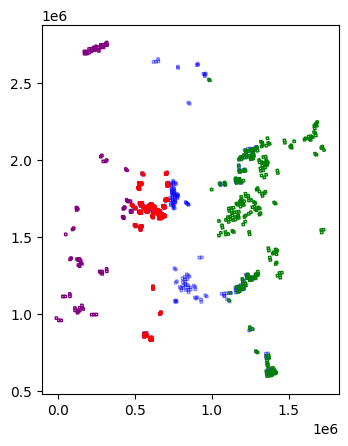

In [537]:
# Visualize pit lake chips
fig, ax = plt.subplots()
#us11_positive_embs_avg['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "pink")
us_embs_with_polys15['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "purple")
us_embs_with_polys16['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "blue", alpha = 0.5)
us_embs_with_polys17['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "green")
overlap1516['geometry'].plot(ax = ax, facecolor = "none", edgecolor = "red")

In [784]:
train_embs_array15_17 = np.concatenate((train_embs_array15, train_embs_array16, train_embs_array17), axis = 0)
train_raster_array15_17 = np.concatenate((train_raster_array15, train_raster_array16, train_raster_array17), axis = 0)

test_raster_array15_17 = np.concatenate((test_raster_array15, test_raster_array16, test_raster_array17), axis = 0)
test_embs_array15_17 = np.concatenate((test_embs_array15, test_embs_array16, test_embs_array17), axis = 0)

train_embs_with_polys15_17 = pd.concat([train_embs_with_polys15, train_embs_with_polys16, train_embs_with_polys17])
test_embs_with_polys15_17 = pd.concat([test_embs_with_polys15, test_embs_with_polys16, test_embs_with_polys17])

print(train_embs_array15_17.shape)
print(test_raster_array15_17.shape)
print(len(train_embs_with_polys15_17))

(703, 1024)
(50, 256, 256)
703


In [1035]:
train_embs_array15_17 = np.concatenate((train_embs_array11, train_embs_array15, train_embs_array16, train_embs_array17), axis = 0)
train_raster_array15_17 = np.concatenate((train_raster_array11, train_raster_array15, train_raster_array16, train_raster_array17), axis = 0)

test_raster_array15_17 = np.concatenate((test_raster_array11, test_raster_array15, test_raster_array16, test_raster_array17), axis = 0)
test_embs_array15_17 = np.concatenate((test_embs_array11, test_embs_array15, test_embs_array16, test_embs_array17), axis = 0)

train_embs_with_polys15_17 = pd.concat([train_embs_with_polys11, train_embs_with_polys15, train_embs_with_polys16, train_embs_with_polys17])
test_embs_with_polys15_17 = pd.concat([test_embs_with_polys11, test_embs_with_polys15, test_embs_with_polys16, test_embs_with_polys17])

print(train_embs_array15_17.shape)
print(test_raster_array15_17.shape)
print(len(train_embs_with_polys15_17))

(795, 1024)
(85, 32, 32)
795


In [409]:
# Drop any duplicates out of training data
#train_embs_array1617 = train_embs_array1617.reset_index(drop = True)
#train_embs_with_polys1617 = train_embs_with_polys1617.reset_index(drop = True)
duplicates_mask = train_embs_with_polys1617.duplicated('geometry', keep = 'first')
print(f'{duplicates_mask.sum()}')
train_embs_array1617 = train_embs_array1617[~duplicates_mask]
train_raster_array1617 = train_raster_array1617[~duplicates_mask]
train_embs_with_polys1617 = train_embs_with_polys1617[~duplicates_mask]

print(train_embs_array1617.shape)
print(train_raster_array1617.shape)
print(len(train_embs_with_polys1617))
print(test_raster_array117.shape)

0
(356, 1024)
(356, 256, 256)
356
(50, 256, 256)


In [62]:
duplicates_mask = mn_embs_with_polys_dropped.duplicated('geometry', keep = 'first')
print(f'{duplicates_mask.sum()}')

0


#### Create model data class

In [460]:
train_embs_with_polys_us = pd.concat([train_embs_with_polysaznv, train_embs_with_polysga, train_embs_with_polysilinkyms, train_embs_with_polysmn, train_embs_with_polysmtwy, train_embs_with_polystx])
train_embs_us = np.vstack([train_embs_arrayaznv, train_embs_arrayga, train_embs_arrayilinkyms, train_embs_arraymn, train_embs_arraymtwy, train_embs_arraytx])
train_rasters_us = np.vstack([train_raster_arrayaznv, train_raster_arrayga, train_raster_arrayilinkyms, train_raster_arraymn, train_raster_arraymtwy, train_raster_arraytx])

test_embs_with_polys_us = pd.concat([test_embs_with_polysaznv, test_embs_with_polysga, test_embs_with_polysilinkyms, test_embs_with_polysmn, test_embs_with_polysmtwy, test_embs_with_polystx])
test_embs_us = np.vstack([test_embs_arrayaznv, test_embs_arrayga, test_embs_arrayilinkyms, test_embs_arraymn, test_embs_arraymtwy, test_embs_arraytx])
test_rasters_us = np.vstack([test_raster_arrayaznv, test_raster_arrayga, test_raster_arrayilinkyms, test_raster_arraymn, test_raster_arraymtwy, test_raster_arraytx])

cnn_train_data = EmbeddingRasterDataset(train_embs_us, train_rasters_us)
cnn_val_data = EmbeddingRasterDataset(test_embs_us, test_rasters_us)

print(train_embs_us.shape)
print(train_rasters_us.shape)
print(test_embs_us.shape)
print(test_rasters_us.shape)

(583, 1024)
(583, 16, 16)
(120, 1024)
(120, 16, 16)


In [464]:
train_embs_with_polys_us = pd.concat([train_embs_with_polysaznv, train_embs_with_polysga, train_embs_with_polysmn])
train_embs_us = np.vstack([train_embs_arrayaznv, train_embs_arrayga, train_embs_arraymn])
train_rasters_us = np.vstack([train_raster_arrayaznv, train_raster_arrayga, train_raster_arraymn])

test_embs_with_polys_us = pd.concat([test_embs_with_polysaznv, test_embs_with_polysga, test_embs_with_polysmn])
test_embs_us = np.vstack([test_embs_arrayaznv, test_embs_arrayga, test_embs_arraymn])
test_rasters_us = np.vstack([test_raster_arrayaznv, test_raster_arrayga, test_raster_arraymn])

cnn_train_data = EmbeddingRasterDataset(train_embs_us, train_rasters_us)
cnn_val_data = EmbeddingRasterDataset(test_embs_us, test_rasters_us)

print(train_embs_us.shape)
print(train_rasters_us.shape)
print(test_embs_us.shape)
print(test_rasters_us.shape)

(310, 1024)
(310, 16, 16)
(60, 1024)
(60, 16, 16)


In [157]:
# MN
cnn_train_data = EmbeddingRasterDataset(train_embs_arraymn, train_raster_arraymn)

print(cnn_train_data.embeddings.shape)
print(cnn_train_data.rasters.shape)
print(test_raster_arraymn.shape)

cnn_val_data = EmbeddingRasterDataset(test_embs_arraymn, test_raster_arraymn)

(105, 1024)
(105, 64, 64)
(25, 64, 64)


In [1036]:
cnn_train_data = EmbeddingRasterDataset(train_embs_array15_17, train_raster_array15_17)

print(cnn_train_data.embeddings.shape)
print(cnn_train_data.rasters.shape)
print(test_raster_array15_17.shape)

cnn_val_data = EmbeddingRasterDataset(test_embs_array15_17, test_raster_array15_17)

(795, 1024)
(795, 32, 32)
(85, 32, 32)


In [382]:
# Drop out samples for 16 and 17 for ablation study

# Indexing from training embeddings, holding test embeddings constant
index = sorted(random.sample(range(0, len(train_embs_array1617)), 256))
train_embs_array1617_dropped = train_embs_with_polys1617.reset_index(drop = True)

train_embs_with_polys1617_dropped = train_embs_array1617_dropped.drop(index = index)
train_embs_array1617_dropped = train_embs_array1617[index]
train_raster_array1617_dropped = train_raster_array1617[index]

cnn_train_data = EmbeddingRasterDataset(train_embs_array1617_dropped, train_raster_array1617_dropped)

print(cnn_train_data.embeddings.shape)
print(cnn_train_data.rasters.shape)
print(test_raster_array1617.shape)

(256, 1024)
(256, 256, 256)
(50, 256, 256)


In [627]:
# Filter out rasters with less than 65 positive pixels

valid_indices = []

# Iterate through each 256x256 slice in 'array'
for i in range(train_raster_array15_17.shape[0]):
    if np.sum(train_raster_array15_17[i]) >= 40:
        valid_indices.append(i)

# Convert valid_indices to numpy array (optional)
valid_indices = np.array(valid_indices)

# Filter 'array' and 'train_embs_array' using valid_indices
filtered_raster_array = train_raster_array15_17[valid_indices]
filtered_train_embs_array = train_embs_array15_17[valid_indices]
filtered_train_embs_with_polys = train_embs_with_polys15_17.iloc[valid_indices]

print("Shape of filtered array:", filtered_raster_array.shape)
print("Shape of filtered train_embs_array:", filtered_train_embs_array.shape)

cnn_train_data = EmbeddingRasterDataset(filtered_train_embs_array, filtered_raster_array)


print(cnn_train_data.embeddings.shape)
print(cnn_train_data.rasters.shape)
print(test_raster_array15_17.shape)


Shape of filtered array: (157, 256, 256)
Shape of filtered train_embs_array: (157, 1024)
(157, 1024)
(157, 256, 256)
(72, 256, 256)


#### Training

3.096483277440406
Epoch 1/100, Avg Loss: 1.1423309246699016
Epoch 1/100, Avg Validation Loss: 1.0429
Epoch 2/100, Avg Loss: 0.9512852323360932
Epoch 2/100, Avg Validation Loss: 0.8761
Epoch 3/100, Avg Loss: 0.8430936367083819
Epoch 3/100, Avg Validation Loss: 0.8039
Epoch 4/100, Avg Loss: 0.7899543199783716
Epoch 4/100, Avg Validation Loss: 0.7618
Epoch 5/100, Avg Loss: 0.7672157776661408
Epoch 5/100, Avg Validation Loss: 0.7524
Epoch 6/100, Avg Loss: 0.7347261538872352
Epoch 6/100, Avg Validation Loss: 0.7386
Epoch 7/100, Avg Loss: 0.7129502388147207
Epoch 7/100, Avg Validation Loss: 0.7506
No improvement in validation loss for 1 epoch(s).
Epoch 8/100, Avg Loss: 0.7078804343174665
Epoch 8/100, Avg Validation Loss: 0.7423
No improvement in validation loss for 2 epoch(s).
Epoch 9/100, Avg Loss: 0.6982040313573984
Epoch 9/100, Avg Validation Loss: 0.7373
Epoch 10/100, Avg Loss: 0.6843884510871692
Epoch 10/100, Avg Validation Loss: 0.7423
No improvement in validation loss for 1 epoch(s).


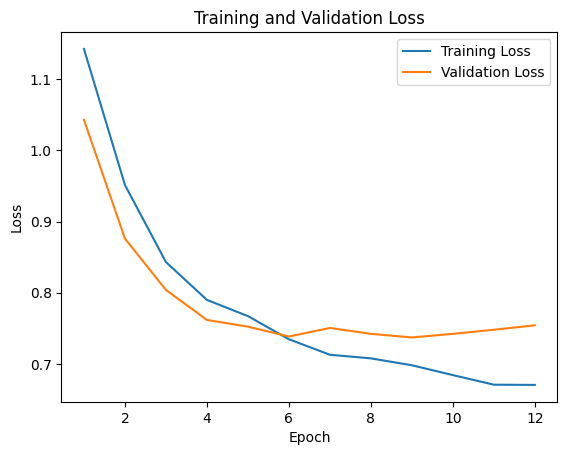

In [465]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming embeddings and rasters are numpy arrays of shape (num_samples, 1024) and (num_samples, 256, 256)
dataloader = DataLoader(cnn_train_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(cnn_val_data, batch_size=16, shuffle=False)

# Initialize model, loss, and optimizer
model = EmbeddingToRasterCNN().to(device)
num_positives = cnn_train_data.rasters.sum()
num_negatives = cnn_train_data.rasters.size - num_positives  # Total pixels - positives
#class_weight = min(num_negatives / num_positives, 200)  # Cap the weight
class_weight = num_negatives / num_positives / 2
print(class_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

def init_weights(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # He initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)  # Initialize biases to zero

model.apply(init_weights)

# Debugging
torch.autograd.set_detect_anomaly(False)
def check_for_nans(module, input, output):
    print(f"Checking {module}")
    print(f"Output has NaNs? {torch.isnan(output).any()}")
hooks = []
for layer in model.modules():
    hook = layer.register_forward_hook(check_for_nans)
    hooks.append(hook)  # Keep track of the hooks
# Remove all hooks
for hook in hooks:
    hook.remove()


# Early stopping parameters
patience = 3 # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# Training loop
losses = []
val_losses = []
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (embeddings_batch, rasters_batch) in enumerate(dataloader):
        optimizer.zero_grad()

        #print(torch.isnan(rasters_batch).any())  # Check if rasters have NaN
        #print(torch.isnan(embeddings_batch).any())

        # Move data to device
        embeddings_batch = embeddings_batch.to(device)
        rasters_batch = rasters_batch.to(device)

        # Forward pass
        outputs = model(embeddings_batch)

        # Compute loss
        outputs = torch.clamp(outputs, min=-3, max=3)  # Prevent extreme values
        loss = criterion(outputs, rasters_batch.unsqueeze(1))  # Add channel dimension to targets
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Logging batch loss
        #print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item()}")
    # Logging epoch loss
    print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {total_loss / len(dataloader)}")
    losses.append(total_loss/len(dataloader))

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for val_embeddings_batch, val_rasters_batch in validation_dataloader:
            # Move data to device
            val_embeddings_batch = val_embeddings_batch.to(device)
            val_rasters_batch = val_rasters_batch.to(device)

            # Forward pass
            val_outputs = model(val_embeddings_batch)

            # Compute loss
            val_outputs = torch.clamp(val_outputs, min=-3, max=3)  # Prevent extreme values
            val_loss = criterion(val_outputs, val_rasters_batch.unsqueeze(1))  # Add channel dimension
            total_val_loss += val_loss.item()

    # Calculate and log validation loss
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Avg Validation Loss: {avg_val_loss:.4f}")

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Stop training at epoch {epoch + 1}.")
            epochs = epoch + 1
            break 


import matplotlib.pyplot as plt
epochs_x = np.arange(1, epochs + 1)
plt.plot(epochs_x, losses, label='Training Loss')
plt.plot(epochs_x, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Evaluation

In [160]:
# Set the model to evaluation mode for one sample
model.eval()
criterion = nn.BCEWithLogitsLoss(reduction = 'mean')
prediction_losses = []

for i in range(0,2):
    sample_embedding = torch.tensor(test_embs_arraymn[i], dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    ground_truth = test_raster_arraymn[i].flatten()

    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_raster = model(sample_embedding)  # Shape of predicted_raster will be [1, 1, 256, 256]
        predictions = torch.sigmoid(predicted_raster) > 0.5
        actuals = torch.tensor(test_raster_arraymn[i].reshape(1, 1, 32, 32))
        loss = criterion(predicted_raster, actuals.float())
        print(loss)
        prediction_losses.append(loss)
        print(test_embs_with_polysmn.to_crs(epsg=4326)['geometry'].iloc[i].centroid)


    rasterio.plot.show(np.array(predictions))
    rasterio.plot.show(test_raster_arraymn[i])

ValueError: cannot reshape array of size 4096 into shape (1,1,32,32)

In [211]:
# Set the model to evaluation mode for train set
model.eval()
criterion = nn.BCEWithLogitsLoss(reduction = 'mean')
train_prediction_losses = []
train_all_ground_truths = []
train_all_predictions = []
train_embeddings = train_embs_array1617
train_rasters = train_raster_array1617
train_embeddings_and_polys = train_embs_with_polys16

for i in range(len(train_embeddings)):
    sample_embedding = torch.tensor(train_embeddings[i], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_raster = model(sample_embedding)  # Shape of predicted_raster will be [1, 1, 256, 256]
        predictions = torch.sigmoid(predicted_raster) > 0.5
        actuals = torch.tensor(train_rasters[i].reshape(1, 1, 256, 256))
        ground_truth = actuals.squeeze(1).numpy()
        loss = criterion(predicted_raster, actuals.float())
        print(loss)
        prediction_losses.append(loss)
        predictions_np = predictions.squeeze(1).numpy()

    train_all_predictions.extend(predictions_np)
    train_all_ground_truths.extend(ground_truth)

    #rasterio.plot.show(np.array(predictions))
    #rasterio.plot.show(train_rasters[i])

    #print(train_embs_with_polys1617.to_crs(epsg=4326)['geometry'].iloc[i].centroid)

# Now `predicted_raster` is your predicted raster output
#print(predicted_raster.shape)

train_all_predictions = np.array(train_all_predictions)
train_all_ground_truths = np.array(train_all_ground_truths)

tensor(0.2586)
tensor(0.2596)
tensor(0.2668)
tensor(0.2611)
tensor(0.2575)
tensor(0.2580)
tensor(0.2583)
tensor(0.2579)
tensor(0.2572)
tensor(0.2604)
tensor(0.2574)
tensor(0.2576)
tensor(0.2578)
tensor(0.2574)
tensor(0.2575)
tensor(0.2572)
tensor(0.2573)
tensor(0.2577)
tensor(0.2572)
tensor(0.2573)
tensor(0.2573)
tensor(0.2574)
tensor(0.2587)
tensor(0.2581)
tensor(0.2594)
tensor(0.2642)
tensor(0.2574)
tensor(0.2578)
tensor(0.2581)
tensor(0.2575)
tensor(0.2573)
tensor(0.2573)
tensor(0.2577)
tensor(0.2684)
tensor(0.2572)
tensor(0.2574)
tensor(0.2573)
tensor(0.2574)
tensor(0.2572)
tensor(0.2573)
tensor(0.2574)
tensor(0.2572)
tensor(0.2572)
tensor(0.2573)
tensor(0.2575)
tensor(0.2573)
tensor(0.2581)
tensor(0.2574)
tensor(0.2573)
tensor(0.2575)
tensor(0.2579)
tensor(0.2581)
tensor(0.2586)
tensor(0.2573)
tensor(0.2580)
tensor(0.2592)
tensor(0.2573)
tensor(0.2579)
tensor(0.2575)
tensor(0.2601)
tensor(0.2573)
tensor(0.2596)
tensor(0.2596)
tensor(0.2578)
tensor(0.2572)
tensor(0.2573)
tensor(0.2

In [212]:
# Training Predictions Metrics
from sklearn.metrics import precision_score, recall_score, f1_score
flattened_ground_truths = train_all_ground_truths.flatten().astype(int)  # Convert to 1D and numpy
flattened_predictions = train_all_predictions.flatten().astype(int)  # Convert to 1D and numpy

precision = precision_score(flattened_ground_truths, flattened_predictions, average='binary')
recall = recall_score(flattened_ground_truths, flattened_predictions, average='binary')
f1 = f1_score(flattened_ground_truths, flattened_predictions, average='binary')

print(f'precision on training: {precision}')
print(f'recall on training: {recall}')
print(f'f1 on training: {f1}')

precision on training: 0.0
recall on training: 0.0
f1 on training: 0.0


tensor(0.5256)


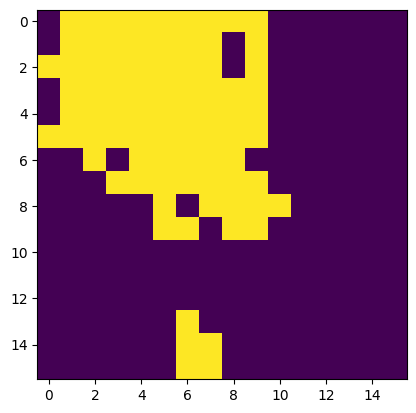

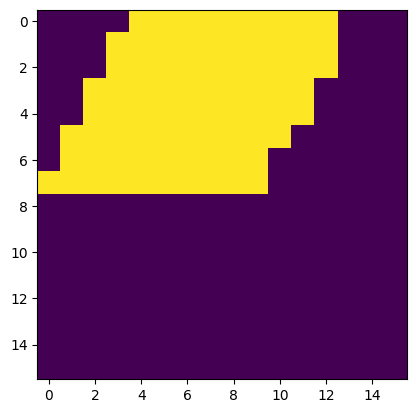

POINT (-117.1952780490015 40.33271959324513)
tensor(0.1877)


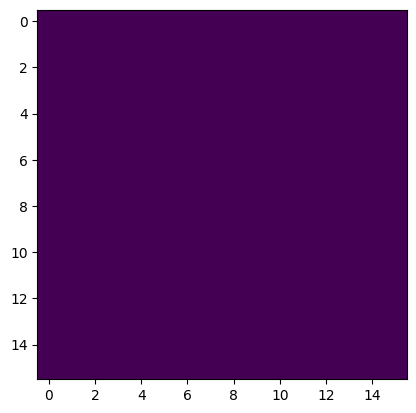

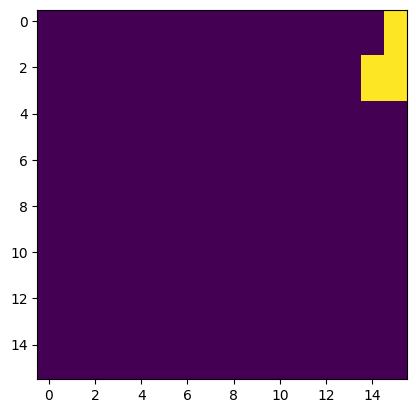

POINT (-117.22208500772321 40.81681809159145)
tensor(0.6202)


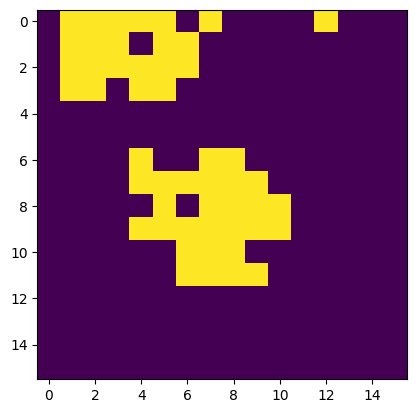

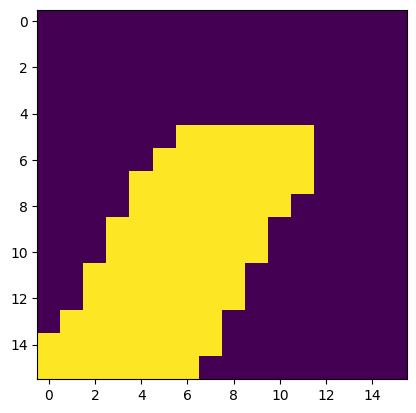

POINT (-117.20907701811429 40.839919640849)
tensor(0.2915)


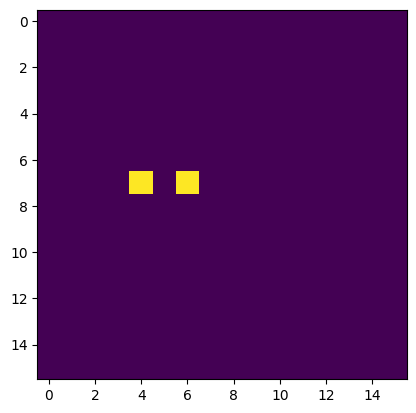

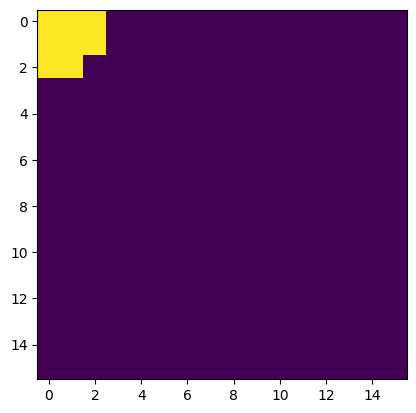

POINT (-116.64137572996704 40.1947638290294)
tensor(0.2283)


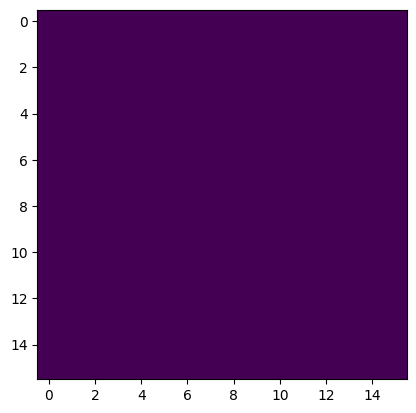

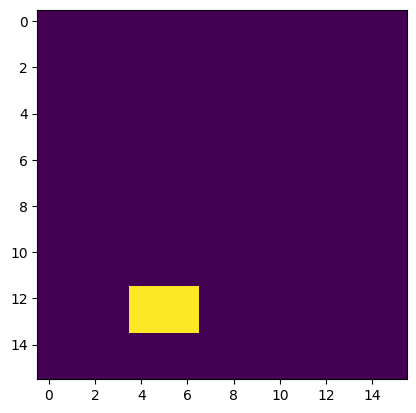

POINT (-116.65817755794684 40.21774553133668)
tensor(0.1621)


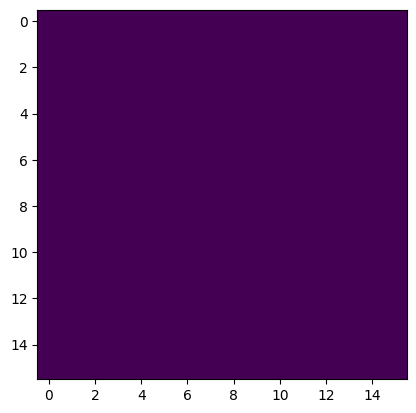

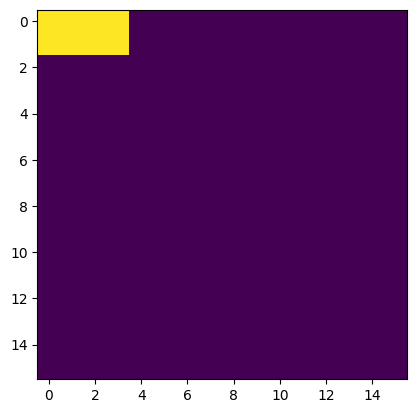

POINT (-111.49383666771541 32.382889399318074)
tensor(0.4005)


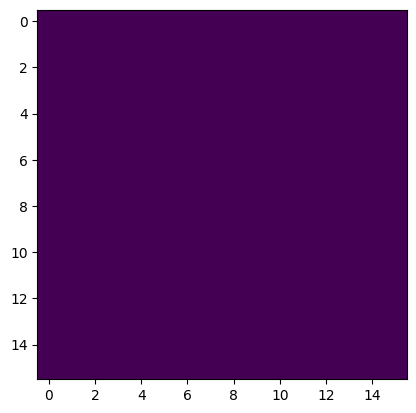

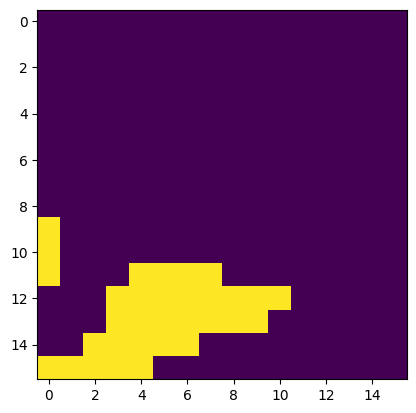

POINT (-111.50574869426838 32.40463993018472)
tensor(0.2655)


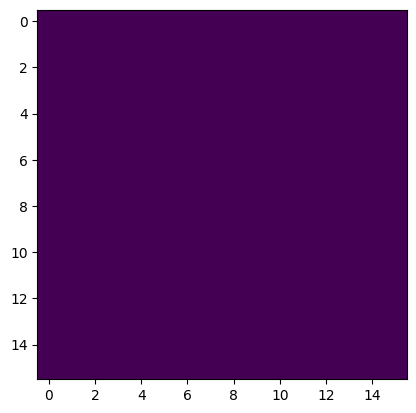

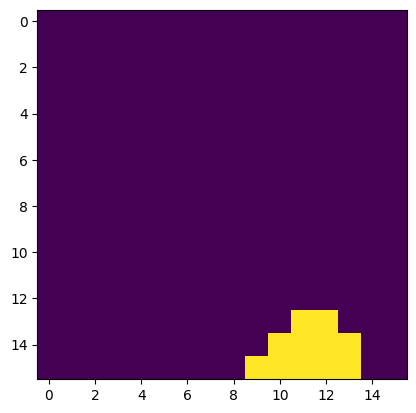

POINT (-116.70444847497166 40.60910666198709)
tensor(0.5633)


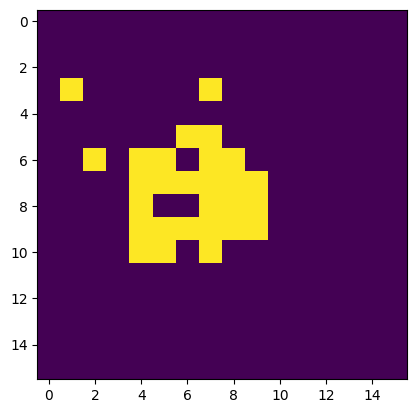

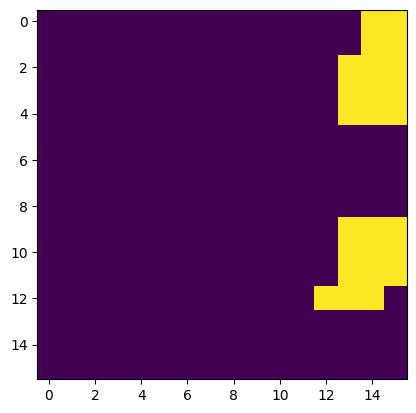

POINT (-111.0796443661446 31.99185764471523)
tensor(0.4107)


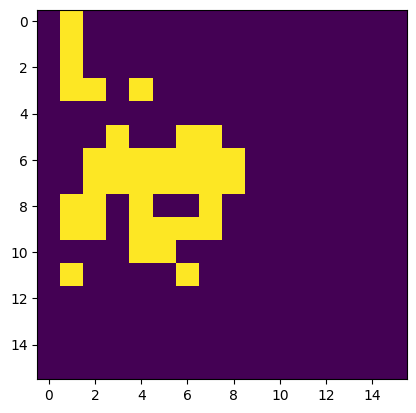

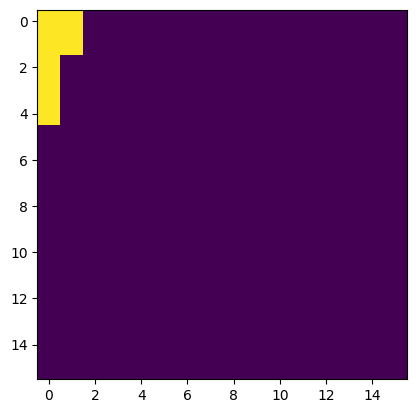

POINT (-111.05082252895302 31.99185764471522)
tensor(0.3588)


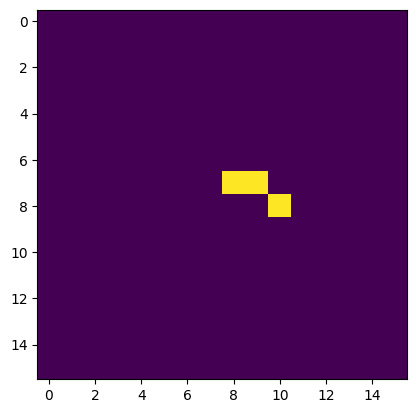

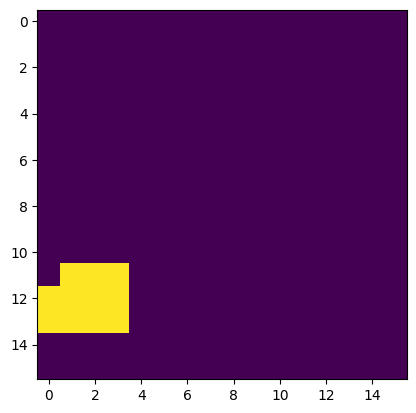

POINT (-111.07419433336014 32.0352612129189)
tensor(0.1766)


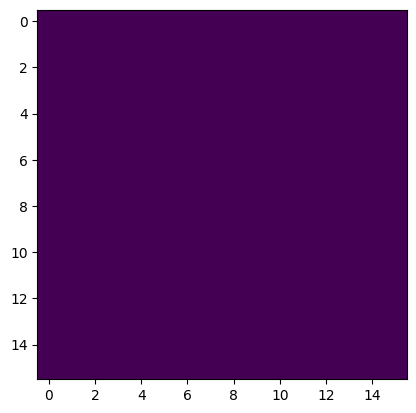

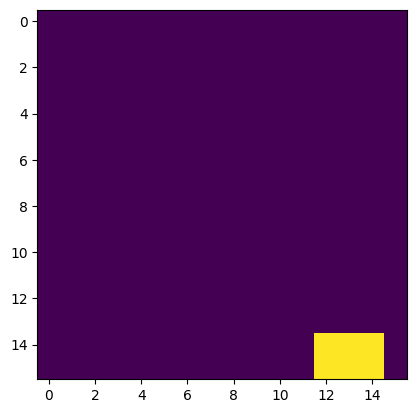

POINT (-110.79094546993112 31.88339684831564)
tensor(0.1847)


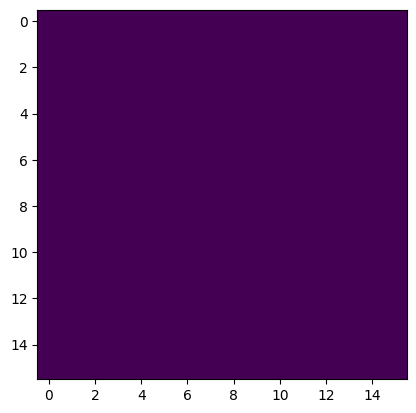

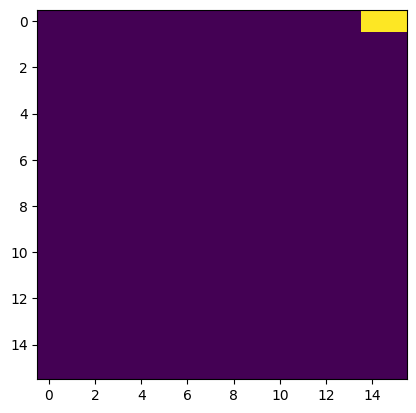

POINT (-116.30451817579885 40.886136312937275)
tensor(0.2559)


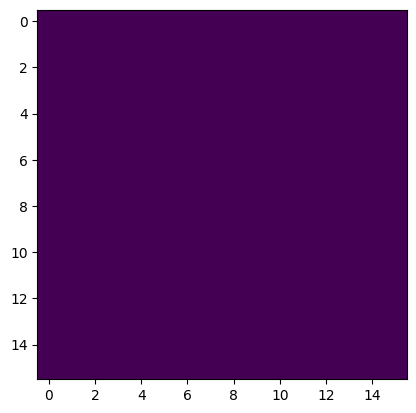

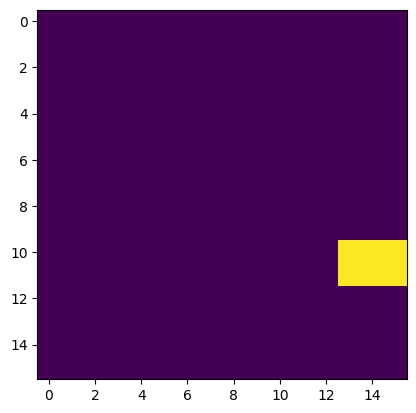

POINT (-116.44249905063339 41.071184878446296)
tensor(0.5387)


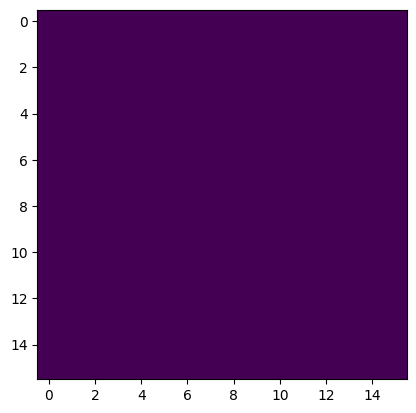

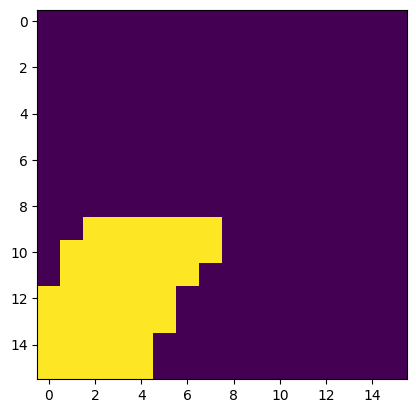

POINT (-116.2914054591066 40.90925144794955)
tensor(0.2235)


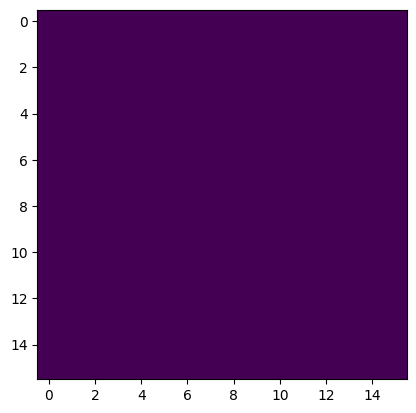

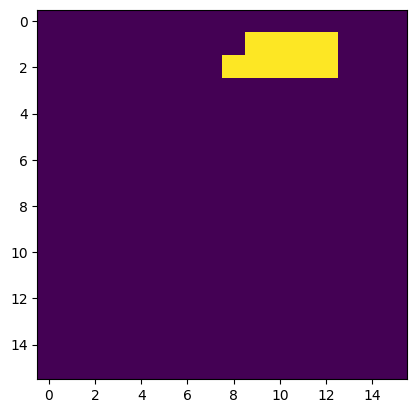

POINT (-116.22164163532908 41.30290851061536)
tensor(0.5628)


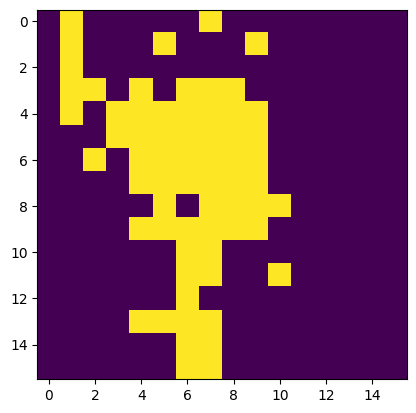

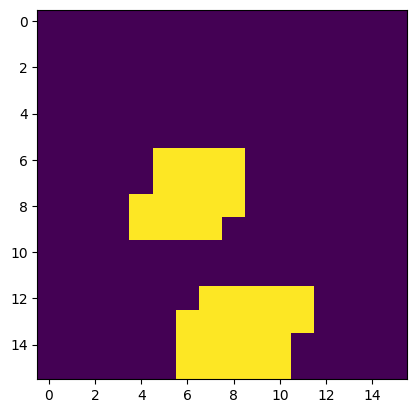

POINT (-110.92213433368202 33.38638086854058)
tensor(0.2407)


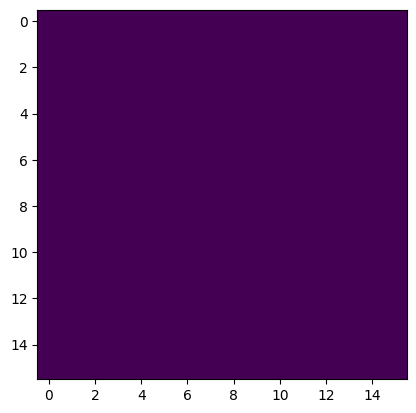

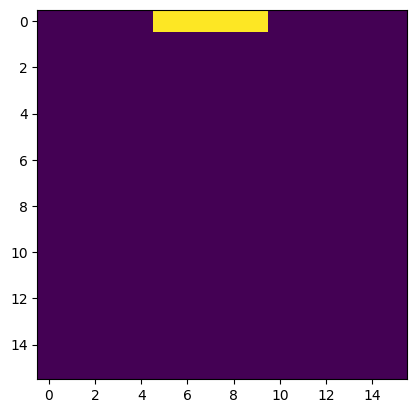

POINT (-110.90981399889559 33.364500188992885)
tensor(0.5514)


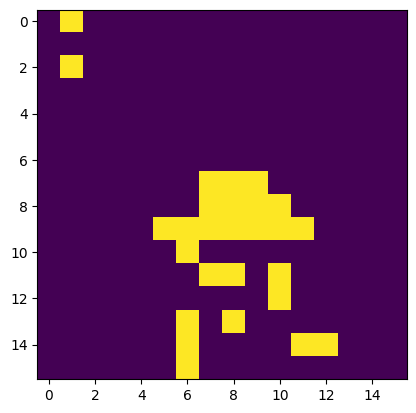

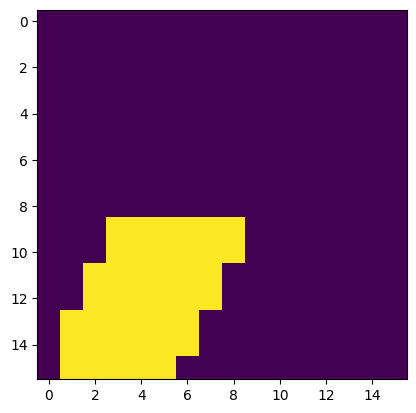

POINT (-110.87207248948216 33.45204075932817)
tensor(0.2011)


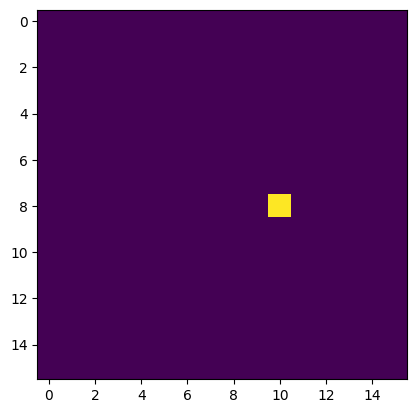

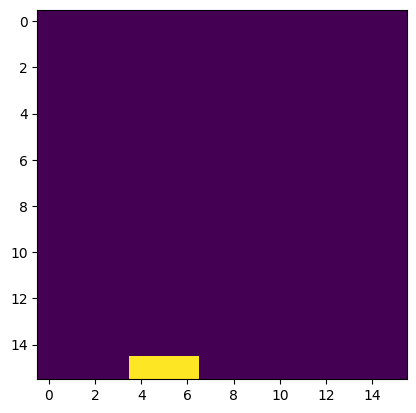

POINT (-109.67644415227647 32.97115227341166)
tensor(0.4165)


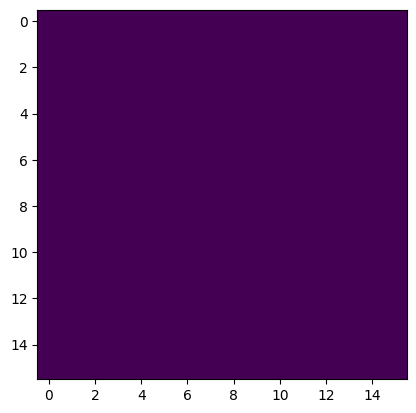

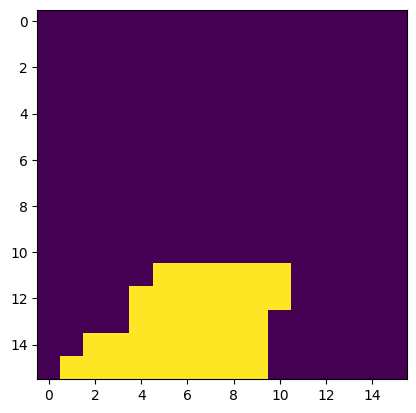

POINT (-84.43382019540005 32.589203324378836)
tensor(0.3897)


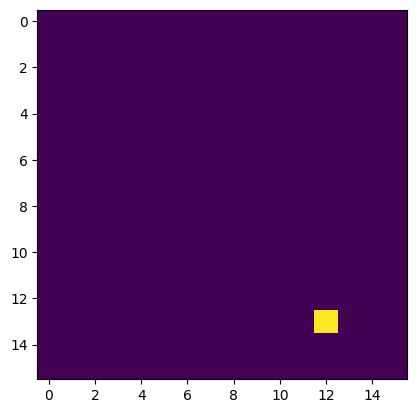

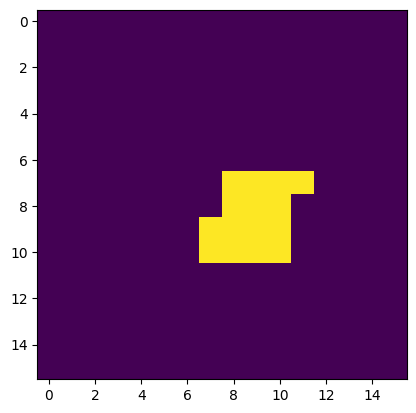

POINT (-84.17406537064936 32.24115008366899)
tensor(0.6795)


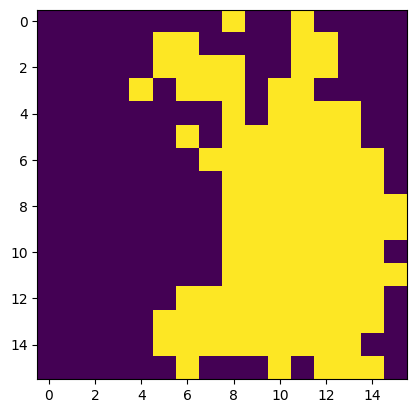

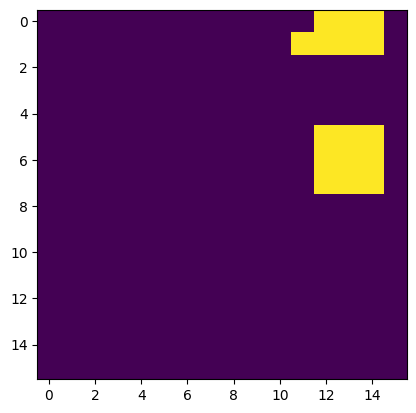

POINT (-83.98942071640236 32.63276090913884)
tensor(0.1655)


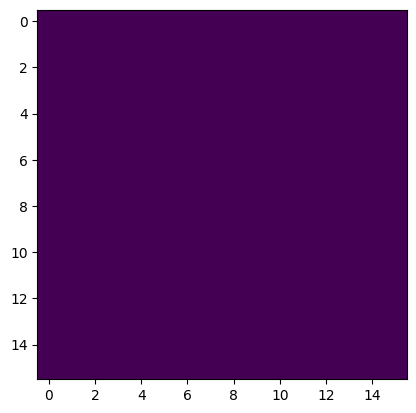

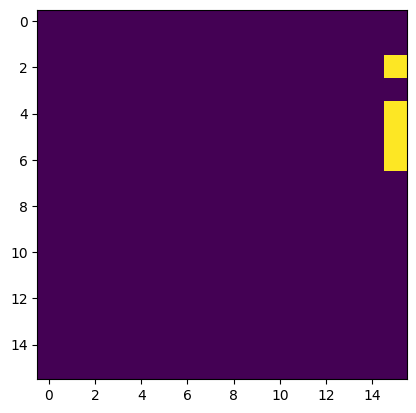

POINT (-83.41830304337596 32.719910331119074)
tensor(0.3171)


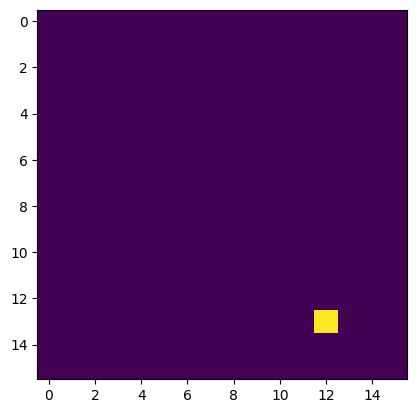

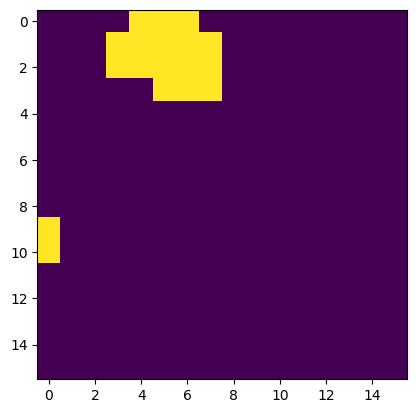

POINT (-83.27367825472054 32.719910331119074)
tensor(0.3437)


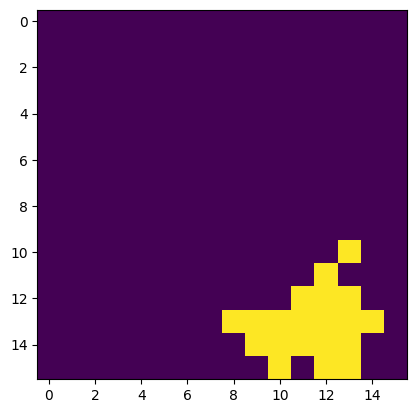

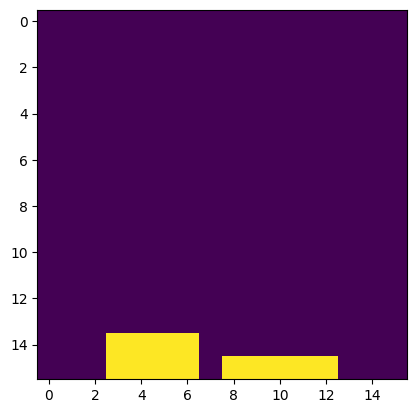

POINT (-83.30980033618305 32.807105606063516)
tensor(0.3408)


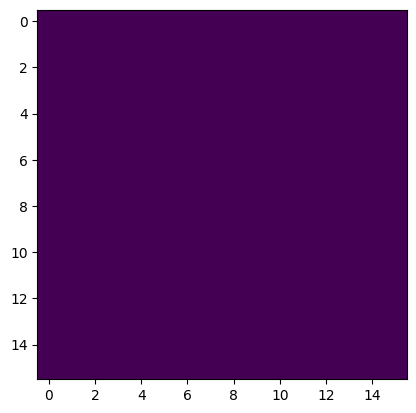

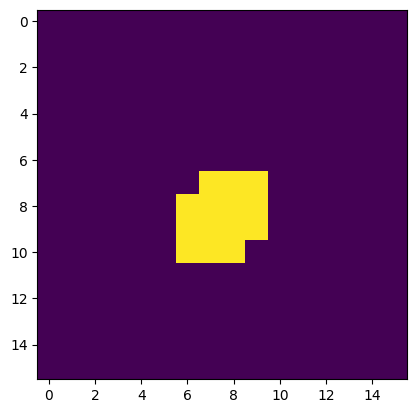

POINT (-83.34606352451378 32.89434695463683)
tensor(0.7271)


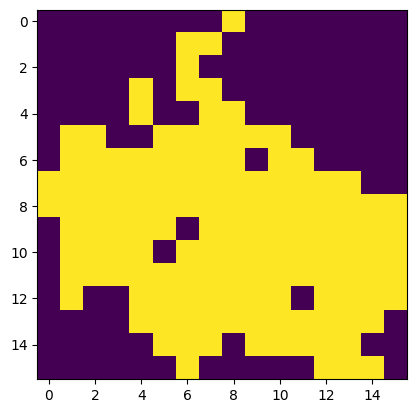

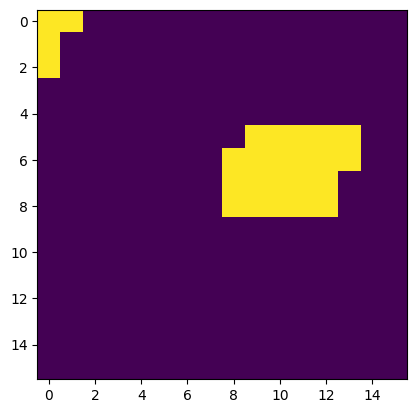

POINT (-83.21213907369717 32.850720507308196)
tensor(0.1862)


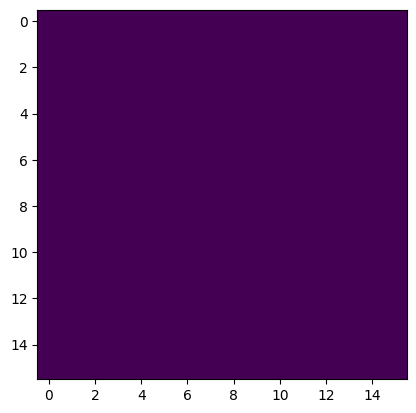

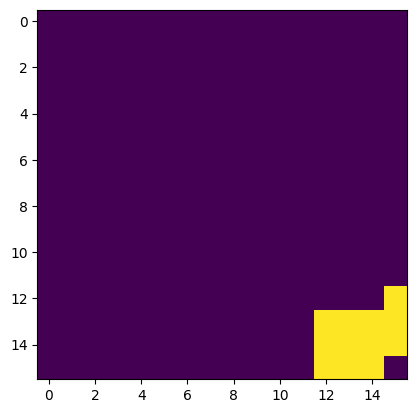

POINT (-83.2393384009699 32.916164516758144)
tensor(0.3676)


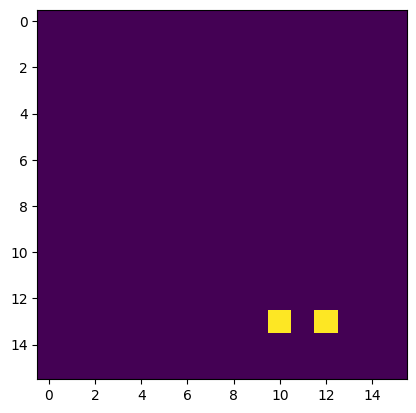

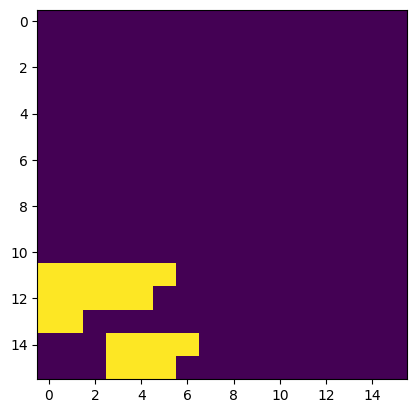

POINT (-83.21038514368239 32.91616451675814)
tensor(0.7441)


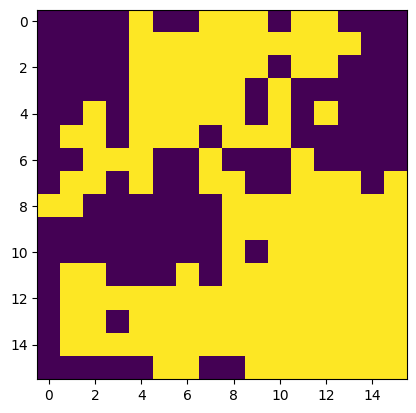

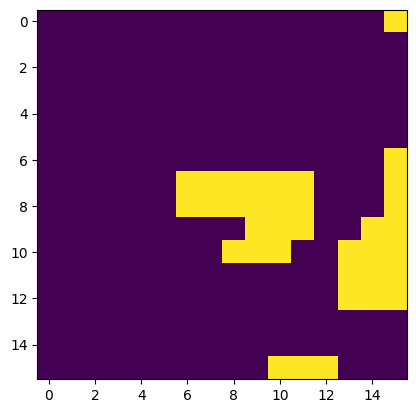

POINT (-83.11446271955118 32.89434695463682)
tensor(0.2960)


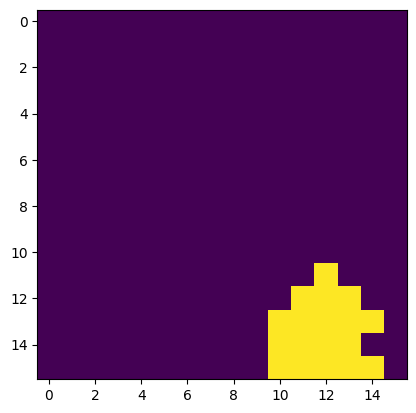

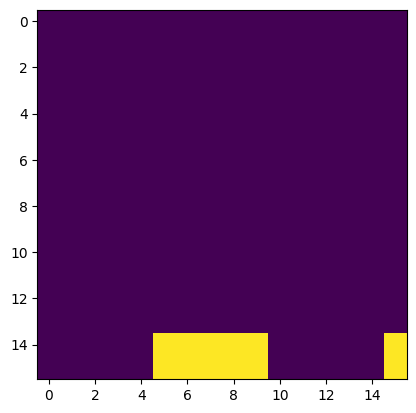

POINT (-83.0674200911629 32.85072050730819)
tensor(0.7541)


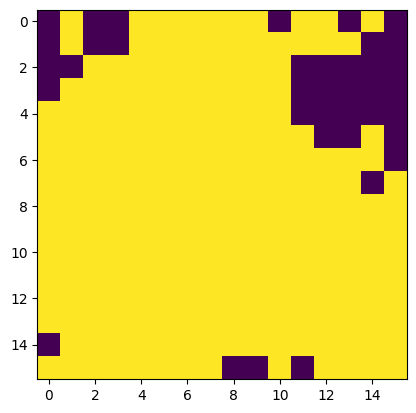

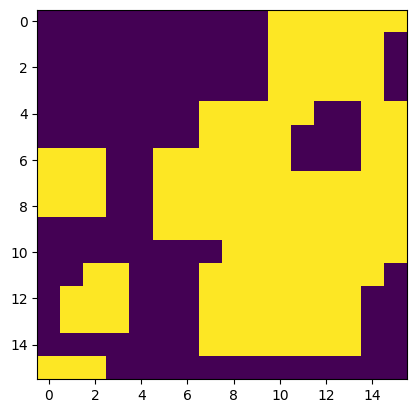

POINT (-83.05479844993907 32.9598083353072)
tensor(0.3920)


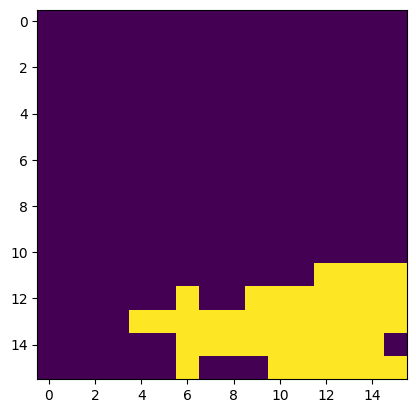

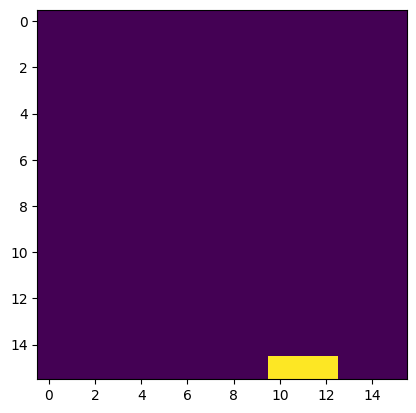

POINT (-83.01503483843362 33.00346376951011)
tensor(0.3204)


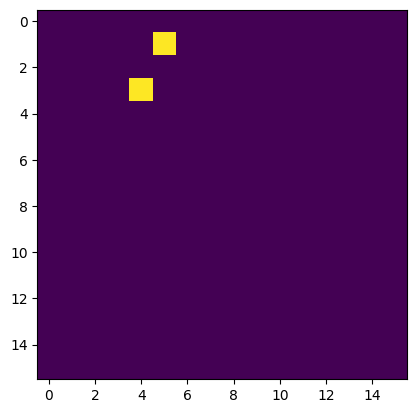

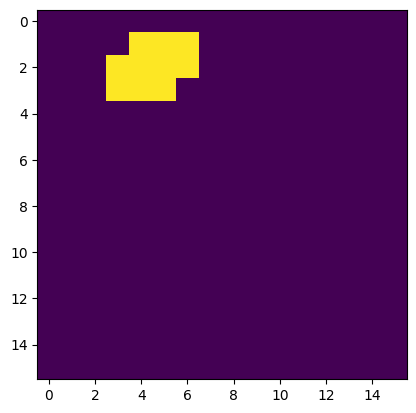

POINT (-82.8991711794009 33.00346376951011)
tensor(0.7388)


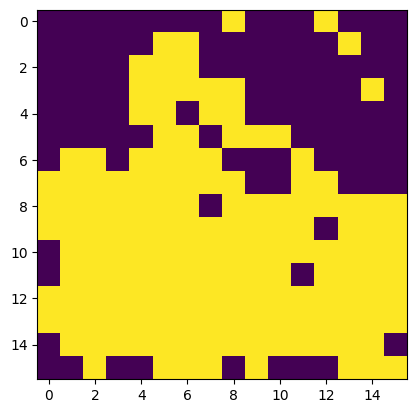

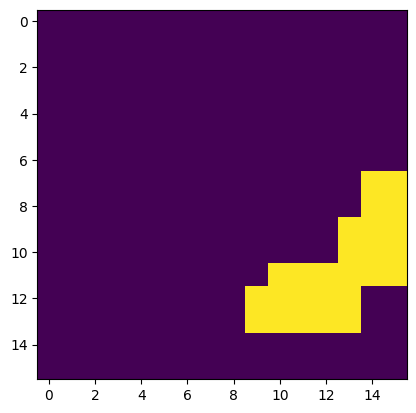

POINT (-82.47587483968903 33.30937940567126)
tensor(0.2312)


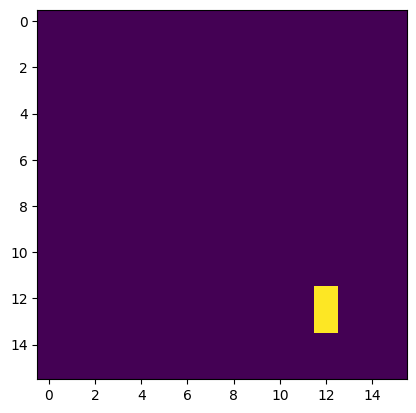

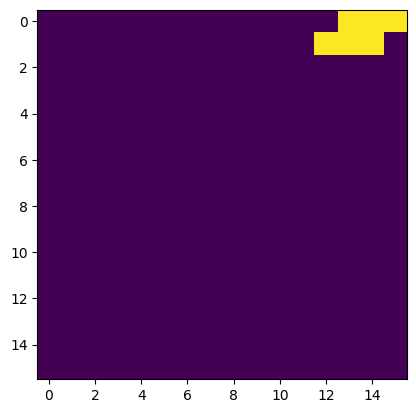

POINT (-82.44528667728135 33.37500791393565)
tensor(0.8050)


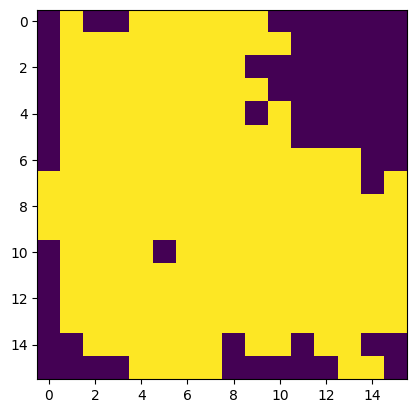

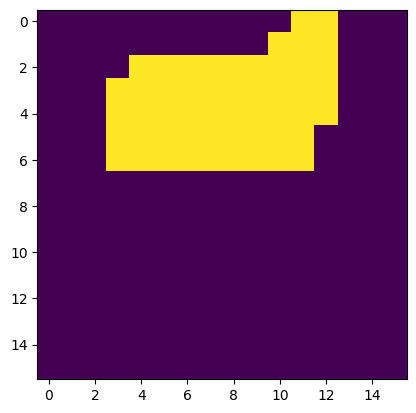

POINT (-82.12774756426899 33.30937940567127)
tensor(0.9434)


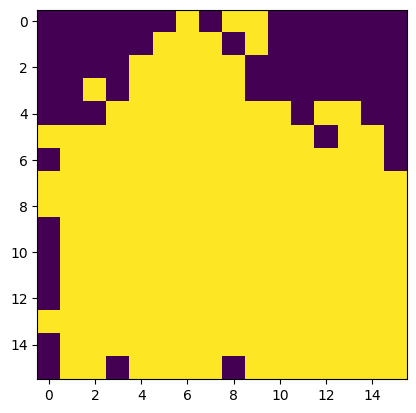

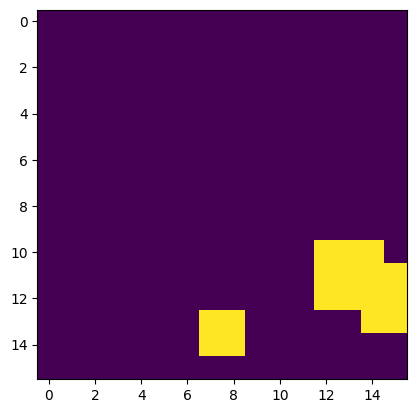

POINT (-82.13685085769504 33.33125260995494)
tensor(0.4144)


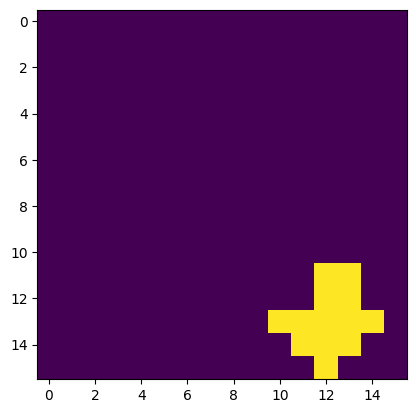

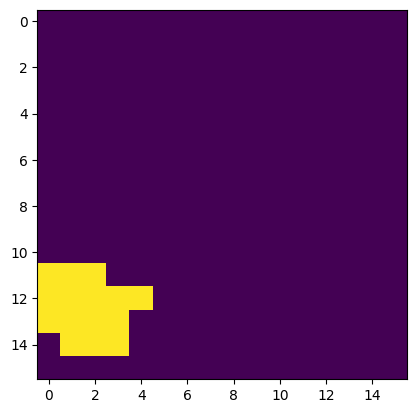

POINT (-82.10783703578475 33.33125260995493)
tensor(0.3319)


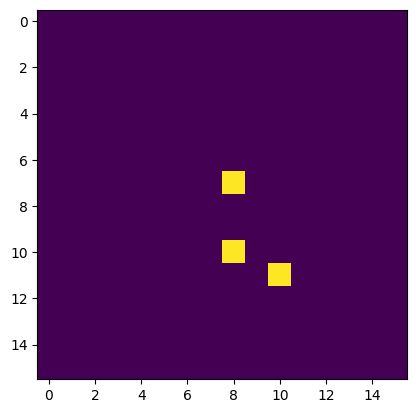

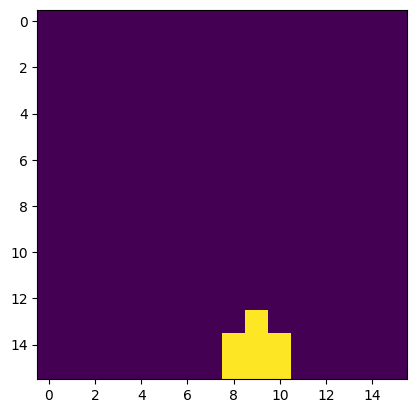

POINT (-93.1762134280427 45.029463012804676)
tensor(0.9832)


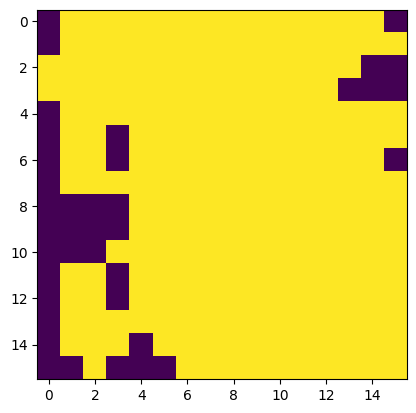

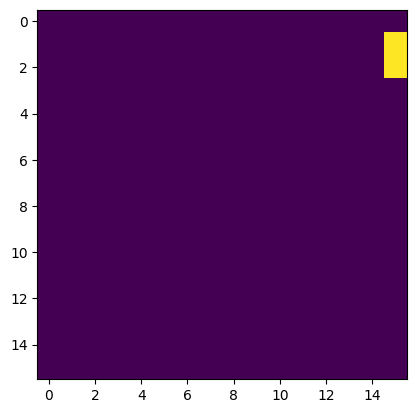

POINT (-93.11389834176335 45.02946301280466)
tensor(0.6738)


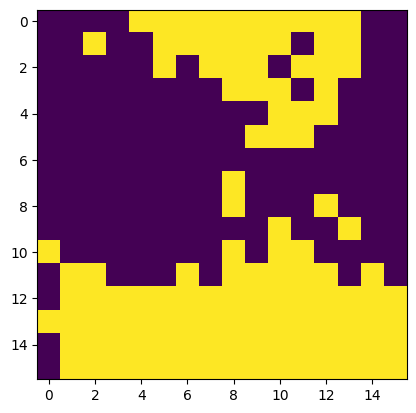

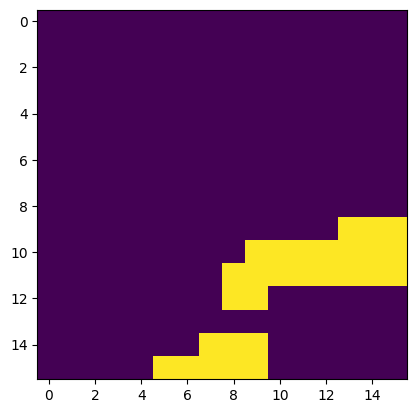

POINT (-94.02805139844372 46.505639759413995)
tensor(0.9197)


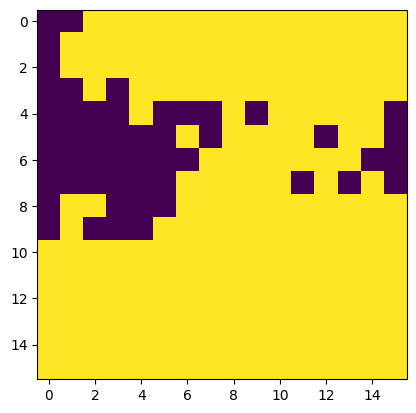

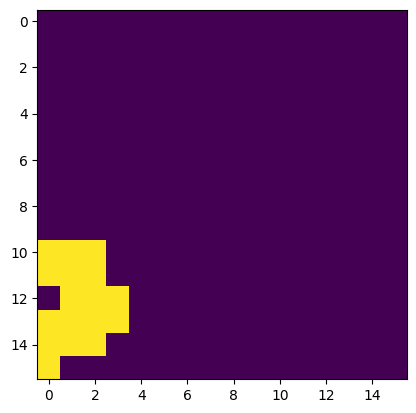

POINT (-93.9335662449298 46.505639759413995)
tensor(0.9647)


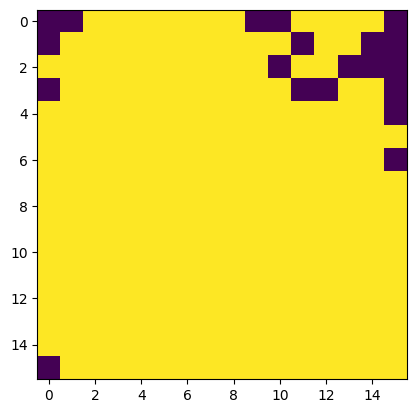

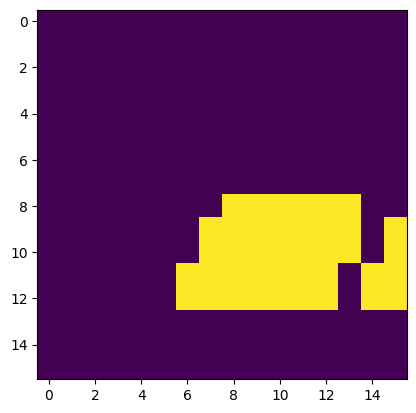

POINT (-93.67887896008091 47.264788281100245)
tensor(0.7125)


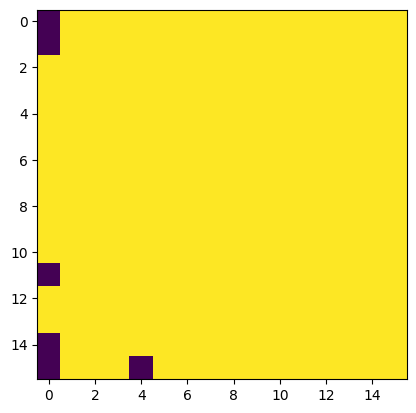

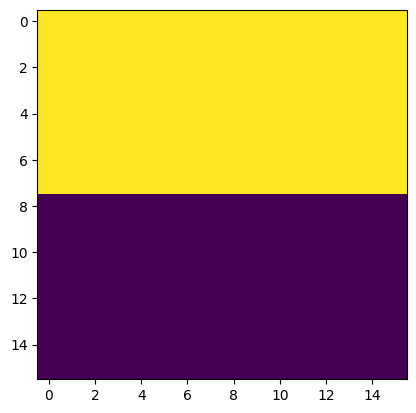

POINT (-93.41123075034724 47.28938239967018)
tensor(0.5833)


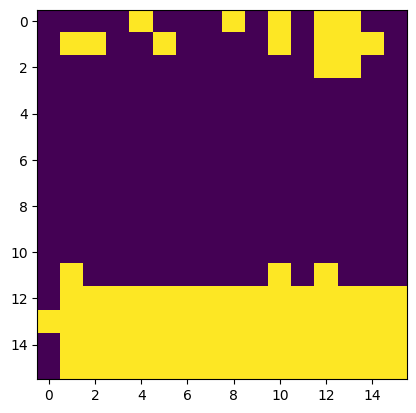

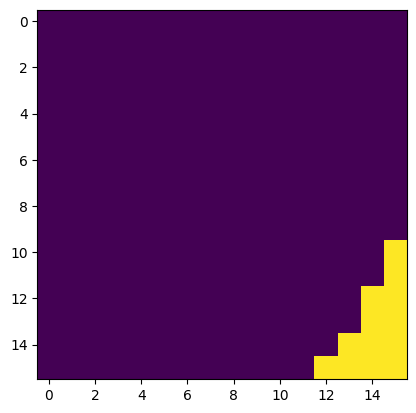

POINT (-93.35106519011815 47.33859076590858)
tensor(1.1222)


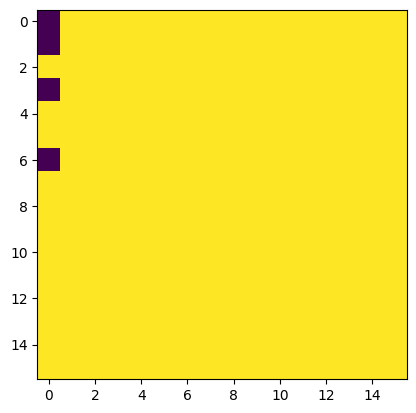

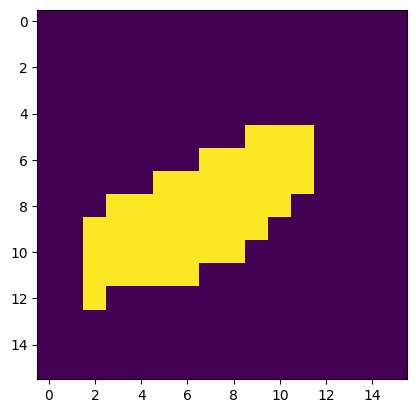

POINT (-93.08324272165355 47.36320503495048)
tensor(0.8797)


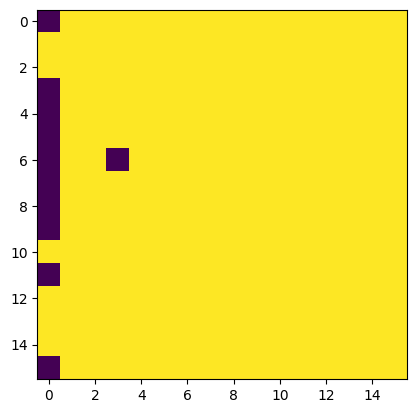

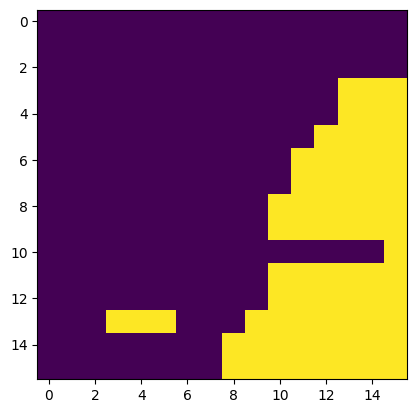

POINT (-93.08641622319179 47.41245379850331)
tensor(0.7726)


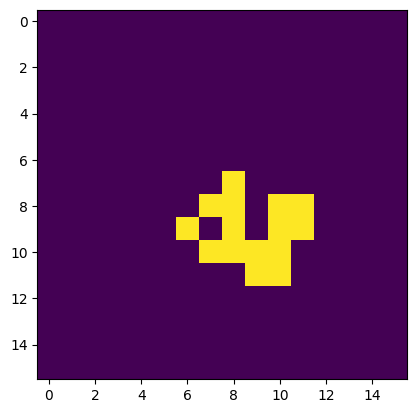

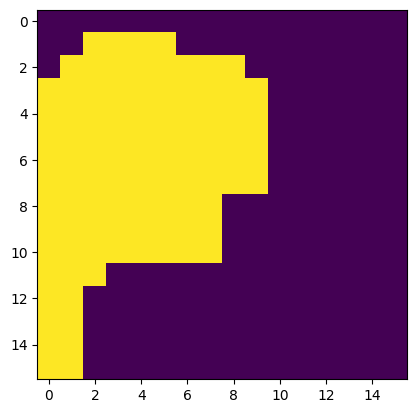

POINT (-92.98022371326097 47.486377669141994)
tensor(0.2979)


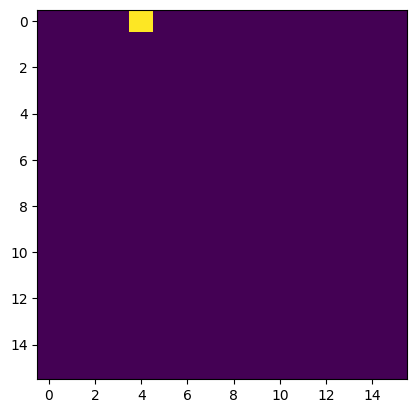

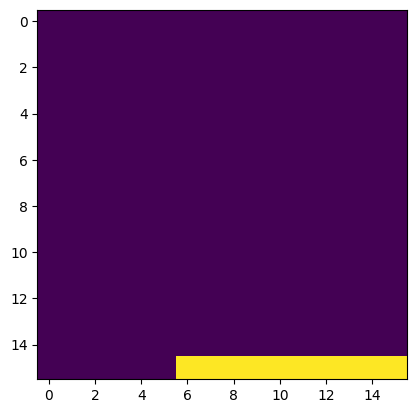

POINT (-92.83904249721536 47.511032529386895)
tensor(0.7100)


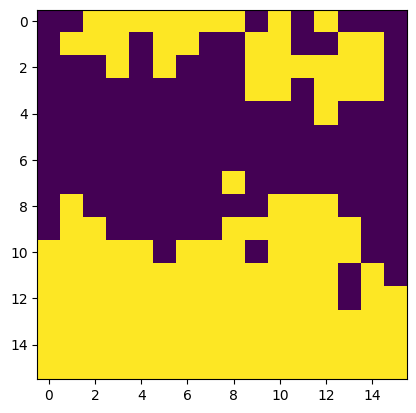

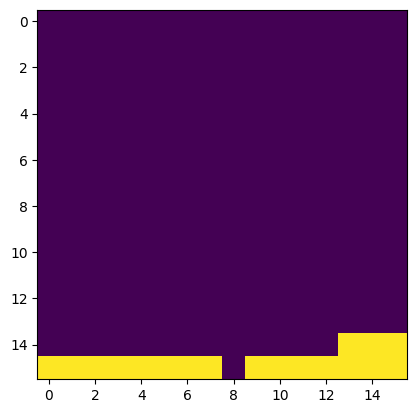

POINT (-92.80730793232244 47.511032529386895)
tensor(0.8885)


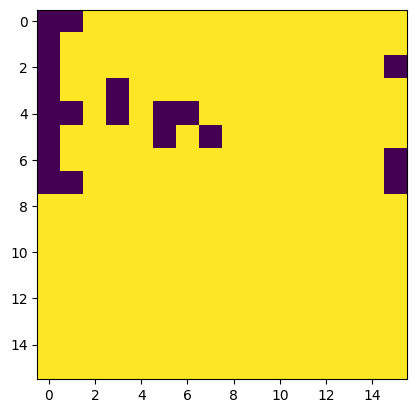

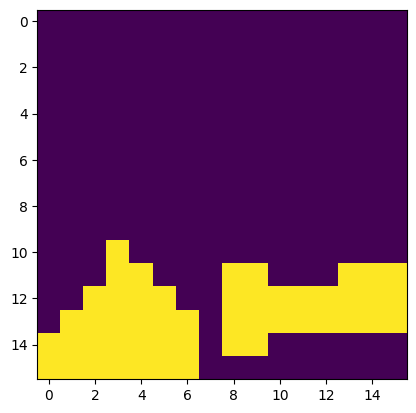

POINT (-92.77557336742956 47.511032529386895)
tensor(0.7798)


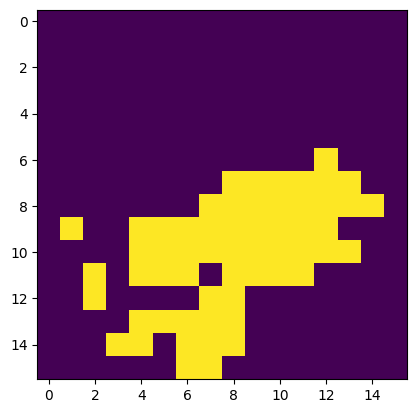

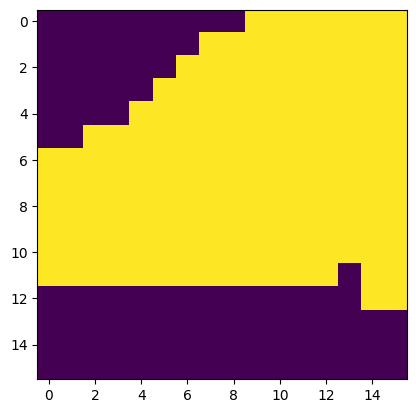

POINT (-92.6660799828024 47.535694192757674)
tensor(0.3587)


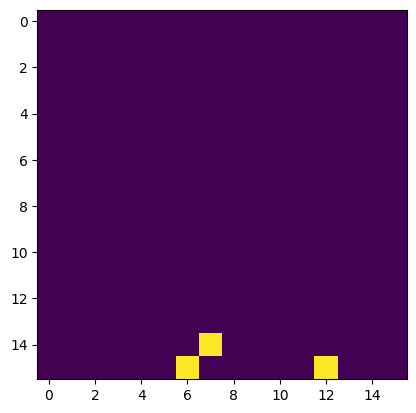

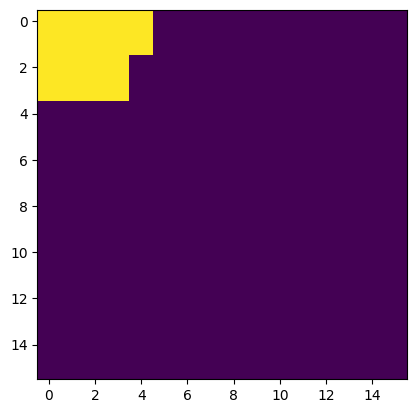

POINT (-92.18997187956485 47.535694192757674)
tensor(0.8003)


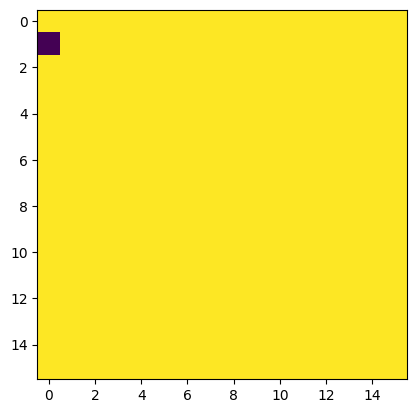

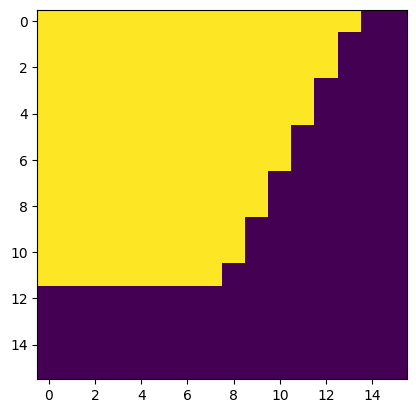

POINT (-92.14385293468649 47.56036267015913)
tensor(0.4899)


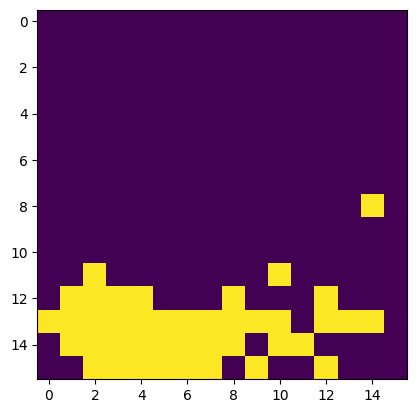

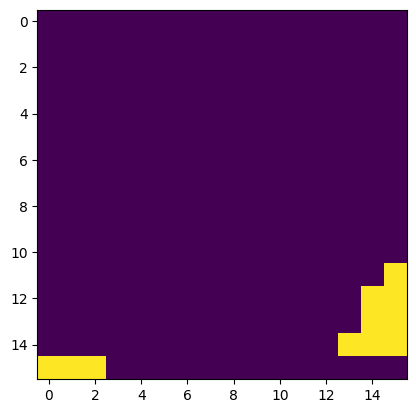

POINT (-92.1612339389115 47.58503797252221)
tensor(0.4444)


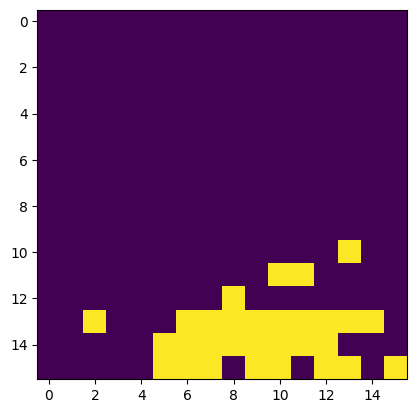

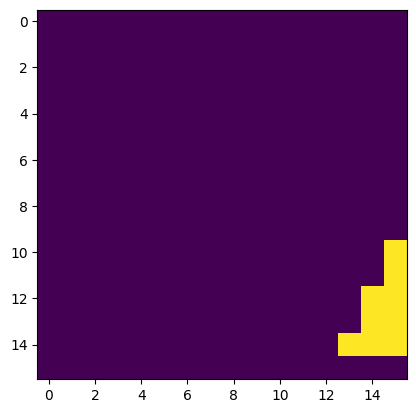

POINT (-92.1468753342686 47.60972011080401)
tensor(0.7943)


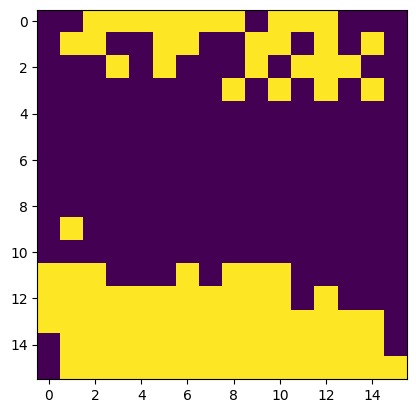

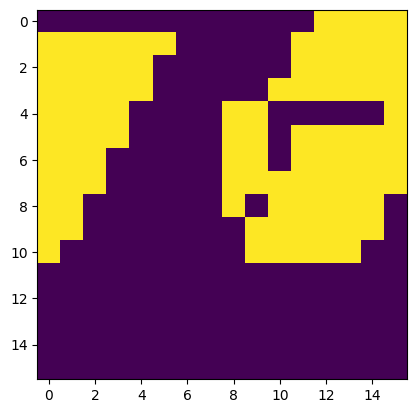

POINT (-92.0833583239268 47.60972011080401)
tensor(0.6129)


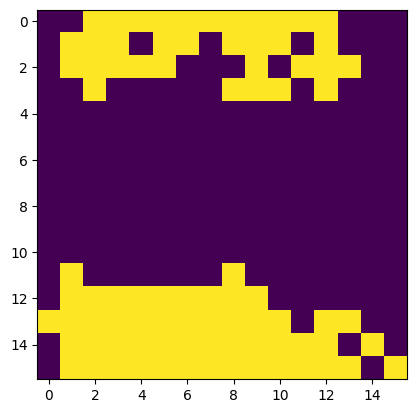

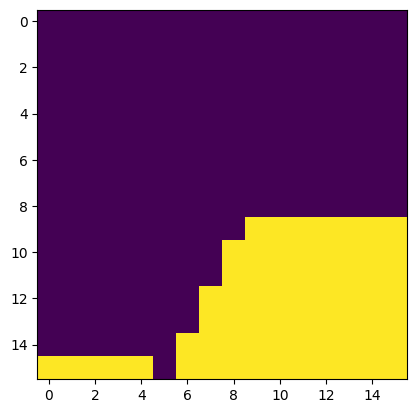

POINT (-92.0689946378951 47.6344090959879)
(15360,)
(15360,)


In [466]:
# Set the model to evaluation mode for test set
model.eval()
criterion = nn.BCEWithLogitsLoss(reduction = 'mean')
prediction_losses = []
all_ground_truths = []
all_predictions = []
test_embeddings = test_embs_us
test_rasters = test_rasters_us
test_embeddings_and_polys = test_embs_with_polys_us


for i in range(len(test_embeddings)):
    sample_embedding = torch.tensor(test_embeddings[i], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_raster = model(sample_embedding)  # Shape of predicted_raster will be [1, 1, 256, 256]
        predictions = torch.sigmoid(predicted_raster) > 0.5
        actuals = torch.tensor(test_rasters[i].reshape(1, 1, targetdim, targetdim))
        ground_truth = actuals.squeeze(1).numpy()
        loss = criterion(predicted_raster, actuals.float())
        print(loss)
        prediction_losses.append(loss)
        predictions_np = predictions.squeeze(1).numpy()

    all_predictions.extend(predictions_np)
    all_ground_truths.extend(ground_truth)

    rasterio.plot.show(np.array(predictions))
    rasterio.plot.show(test_rasters[i])

    print(test_embeddings_and_polys.to_crs(epsg=4326)['geometry'].iloc[i].centroid)

# Now `predicted_raster` is your predicted raster output
#print(predicted_raster.shape)

all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)

print(all_ground_truths.flatten().shape)
print(all_predictions.flatten().shape)

In [467]:
from sklearn.metrics import precision_score, recall_score, f1_score
flattened_ground_truths = all_ground_truths.flatten().astype(int)  # Convert to 1D and numpy
flattened_predictions = all_predictions.flatten().astype(int)  # Convert to 1D and numpy

precision = precision_score(flattened_ground_truths, flattened_predictions, average='binary')
recall = recall_score(flattened_ground_truths, flattened_predictions, average='binary')
f1 = f1_score(flattened_ground_truths, flattened_predictions, average='binary')

print(f'precision on test: {precision}')
print(f'recall on test: {recall}')
print(f'f1 on test: {f1}')

precision on test: 0.24101686629186017
recall on test: 0.5132743362831859
f1 on test: 0.32801064537591484


Mean: losses    0.356901
dtype: float32
Median: losses    0.340403
dtype: float32
       losses
0.1  0.240667
0.5  0.340403
0.9  0.539457
      losses
0   0.373022
1   0.233046
2   0.350851
3   0.315601
4   0.329286
..       ...
76  0.452280
77  0.240667
78  0.292556
79  0.260251
80  0.323407

[81 rows x 1 columns]


ValueError: autodetected range of [nan, nan] is not finite

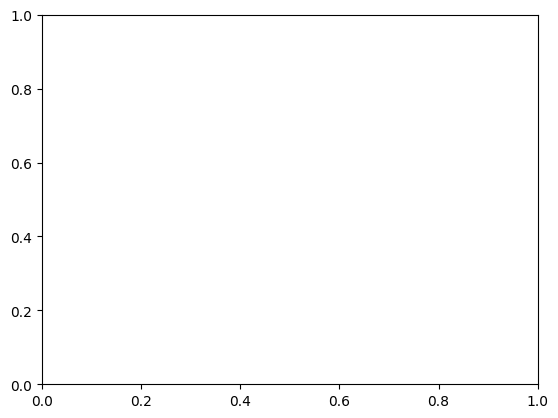

In [1030]:
prediction_losses_df = pd.DataFrame(np.array(prediction_losses), columns = ['losses'])
#plt.hist(prediction_losses_np)

mean_value = prediction_losses_df.mean()          
median_value = prediction_losses_df.median()  
percentiles = prediction_losses_df.quantile([0.1, 0.5, 0.9])

print("Mean:", mean_value)
print("Median:", median_value)
print(percentiles)

bigger_losses = prediction_losses_df[prediction_losses_df > 0.13]
print(bigger_losses)

smaller_losses = prediction_losses_df[prediction_losses_df < 0.13]
plt.hist(smaller_losses)
plt.title('90th Percentile Prediction Losses')
len(smaller_losses)

### Build classification model to predict presence of pit lakes

In [1385]:
# Mark positive samples 
import math

def MarkSamples(data, polygons, pct):
    """ Mark as positive if intersection is greater than given % of area.
    """
    # Get polygon of intersection for each chip
    positive_data = data[data['mine'] == 1]
    negative_data = data[data['mine'] == 0]
    positive_data['emb_idx'] = positive_data.index
    intersecting = gpd.overlay(positive_data, polygons, how = 'intersection') # Returns polygons of intersection
    intersecting = intersecting.dissolve(by='emb_idx') # Makes intersecting index match with data, adds areas of intersection
    intersecting['overlapping_area'] = intersecting.geometry.area

    # Merge into one dataframe 
    positive_data = positive_data.merge(intersecting['overlapping_area'], left_index = True, right_index = True, how='left')

    # Check intersection % and mark True/False
    for index, row in positive_data.iterrows():
        pct_overlap = row['overlapping_area'] / row.geometry.area
        positive_data.loc[index,'pct_pitlake'] = pct_overlap
        if pct_overlap >= pct:
            positive_data['mine'][index] = 1
        elif math.isnan(row['overlapping_area']):
            positive_data['mine'][index] = 0
        else: 
            positive_data['mine'][index]  = 0

    data = pd.concat([positive_data, negative_data])

    return data

In [1043]:
us_qa_dry_11 = qa_pits_11[qa_pits_11['category'] == 'd']
us_qa_dry_15 = qa_pits_15[qa_pits_15['category'] == 'd']
us_qa_dry_16 = qa_pits_16[qa_pits_16['category'] == 'd']
us_qa_dry_17 = qa_pits_17[qa_pits_17['category'] == 'd']


In [1386]:
def PrepClfTrainTest(data, polygons, pct = 0.005):
    # Check if intersection of each chip with a pit lake polygon is > 1%
    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = np.vstack(datamarked['embedding'].values)
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.25, train_size=0.75, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx
        

In [1383]:
# For concatenation

def PrepClfTrainTest(data, polygons, pct = 0.005):
    # Check if intersection of each chip with a pit lake polygon is > 1%
    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = np.vstack(datamarked['embedding'].values)
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.25, train_size=0.75, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx
        

In [694]:
def PrepClfTrainTestFiltered(data, negativedata, pct = 0.01):

    negativedata = negativedata.to_crs(epsg = 8857)
    data_marked = data.reset_index(drop=True)
    negativedata['pixel_pct'] = 0
    data_marked = pd.concat([data, negativedata])
    data_marked['mine'] = data.groupby('geometry')['mine'].transform('max')
    data_marked = data_marked.drop_duplicates('geometry').reset_index(drop = True)
    
    for idx in data_marked.index: # Unwrap layered arrays
        data_marked.at[idx,'embedding'] = data_marked.loc[idx,'embedding'][0]
        if data_marked.loc[idx, 'pixel_pct'] >= pct: # Mark mines
            data_marked.at[idx, 'mine'] = int(1)
        else:
            data_marked.at[idx, 'mine'] = int(0)
    
    print(f'Positive samples: {(data_marked['mine']==1).sum()}')

    print(f'Total samples: {len(data_marked)}')

    # Split into train and test
    data_marked = data_marked.reset_index(drop=True)
    train_embeddings = np.vstack(data_marked['embedding'].values)
    labels = np.int_(np.array(data_marked['mine']))
    indices = data_marked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.2, train_size=0.8, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [1757]:
#AZ NV
aznv_X_train, aznv_X_test, aznv_y_train, aznv_y_test, aznv_train_idx, aznv_test_idx = PrepClfTrainTest(dataAZNV, az_nv_qa_pits)

# GA 
ga_X_train, ga_X_test, ga_y_train, ga_y_test, ga_train_idx, ga_test_idx = PrepClfTrainTest(dataGA, ga_qa_pits)

# IL IN KY MS
ilinkyms_X_train, ilinkyms_X_test, ilinkyms_y_train, ilinkyms_y_test, ilinkyms_train_idx, ilinkyms_test_idx =  PrepClfTrainTest(dataILINKYMS, il_in_ky_ms_qa_pits)

# MN
mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = PrepClfTrainTest(dataMN, mn_qa_pits)

# MT WY
mtwy_X_train, mtwy_X_test, mtwy_y_train, mtwy_y_test, mtwy_train_idx, mtwy_test_idx = PrepClfTrainTest(dataMTWY, mt_wy_qa_pits)

# TX
tx_X_train, tx_X_test, tx_y_train, tx_y_test, tx_train_idx, tx_test_idx = PrepClfTrainTest(dataTX, tx_qa_pits)

Positive samples: 92
Total samples: 10312
(7734, 1024)
(2578, 1024)
(7734,)
(2578,)
Positive samples: 149
Total samples: 1933
(1449, 1024)
(484, 1024)
(1449,)
(484,)
Positive samples: 193
Total samples: 16297
(12222, 1024)
(4075, 1024)
(12222,)
(4075,)
Positive samples: 102
Total samples: 9288
(6966, 1024)
(2322, 1024)
(6966,)
(2322,)
Positive samples: 79
Total samples: 3985
(2988, 1024)
(997, 1024)
(2988,)
(997,)
Positive samples: 58
Total samples: 2661
(1995, 1024)
(666, 1024)
(1995,)
(666,)


In [1557]:
# Remove high probability, unconfirmed from training set

unconfirmed_idx = (dataAZNV.loc[dataAZNV['category'] == '\\N', 'score'] > 0.3).index
unconfirmed_mask = aznv_train_idx.isin(unconfirmed_idx) 
print(len(aznv_X_train))
aznv_X_train = aznv_X_train[~unconfirmed_mask]
aznv_y_train = aznv_y_train[~unconfirmed_mask]
print(len(aznv_X_train))

unconfirmed_idx = (dataGA.loc[dataGA['category'] == '\\N', 'score'] > 0.3).index
unconfirmed_mask = ga_train_idx.isin(unconfirmed_idx) 
print(len(ga_X_train))
ga_X_train = ga_X_train[~unconfirmed_mask]
ga_y_train = ga_y_train[~unconfirmed_mask]
print(len(ga_X_train))

unconfirmed_idx = (dataILINKYMS.loc[dataILINKYMS['category'] == '\\N', 'score'] > 0.3).index
unconfirmed_mask = ilinkyms_train_idx.isin(unconfirmed_idx) 
print(len(ilinkyms_X_train))
ilinkyms_X_train = ilinkyms_X_train[~unconfirmed_mask]
ilinkyms_y_train = ilinkyms_y_train[~unconfirmed_mask]
print(len(ilinkyms_X_train))

unconfirmed_idx = (dataMN.loc[dataMN['category'] == '\\N', 'score'] > 0.3).index
unconfirmed_mask = mn_train_idx.isin(unconfirmed_idx) 
print(len(mn_X_train))
mn_X_train = mn_X_train[~unconfirmed_mask]
mn_y_train = mn_y_train[~unconfirmed_mask]
print(len(mn_X_train))

unconfirmed_idx = (dataMTWY.loc[dataMTWY['category'] == '\\N', 'score'] > 0.3).index
unconfirmed_mask = mtwy_train_idx.isin(unconfirmed_idx) 
print(len(mtwy_X_train))
mtwy_X_train = mtwy_X_train[~unconfirmed_mask]
mtwy_y_train = mtwy_y_train[~unconfirmed_mask]
print(len(mtwy_X_train))

unconfirmed_idx = (dataTX.loc[dataTX['category'] == '\\N', 'score'] > 0.3).index
unconfirmed_mask = tx_train_idx.isin(unconfirmed_idx) 
print(len(tx_X_train))
tx_X_train = tx_X_train[~unconfirmed_mask]
tx_y_train = tx_y_train[~unconfirmed_mask]
print(len(tx_X_train))

7734
7507
1449
1405
12222
12035
6966
6936
2988
2918
1995
1909


In [1758]:
us_X_train = np.vstack([aznv_X_train, ga_X_train, ilinkyms_X_train, mn_X_train, mtwy_X_train, tx_X_train])
us_X_test = np.vstack([aznv_X_test, ga_X_test, ilinkyms_X_test, mn_X_test, mtwy_X_test, tx_X_test])
us_y_train = np.concatenate([aznv_y_train, ga_y_train, ilinkyms_y_train, mn_y_train, mtwy_y_train, tx_y_train], axis = 0)
us_y_test = np.concatenate([aznv_y_test, ga_y_test, ilinkyms_y_test, mn_y_test, mtwy_y_test, tx_y_test], axis = 0)

In [1759]:
print(us_X_train.shape)
print(us_X_test.shape)
print(us_y_train.shape)
print(us_y_test.shape)

(33354, 1024)
(11122, 1024)
(33354,)
(11122,)


In [1375]:
# Sample negatives out
negative_sampled_idx = []

for i in range(len(us_y_train)):
    if us_y_train[i] == 1:
        negative_sampled_idx.append(i)


print(f'Number of negatives: {len(negative_sampled_idx)}')
idx = np.array(random.sample(range(1, len(negative_sampled_idx)), 300), dtype = int)
negative_sampled_idx = np.array(negative_sampled_idx)

negatives_to_drop = negative_sampled_idx[idx]
us_y_train = np.delete(us_y_train,negatives_to_drop)
us_X_train = np.delete(us_X_train,negatives_to_drop, axis = 0)



Number of negatives: 454


In [1376]:
print(us_X_train.shape)
print(us_X_test.shape)
print(us_y_train.shape)
print(us_y_test.shape)

(33054, 1024)
(11122, 1024)
(33054,)
(11122,)


In [695]:
# FOR FILTERED TRAINING/TEST
#AZ NV
aznv_X_train, aznv_X_test, aznv_y_train, aznv_y_test, aznv_train_idx, aznv_test_idx = PrepClfTrainTestFiltered(aznv_data, dataAZNV, 0.01)

# GA 
ga_X_train, ga_X_test, ga_y_train, ga_y_test, ga_train_idx, ga_test_idx = PrepClfTrainTestFiltered(ga_data, dataGA, 0.01)

# IL IN KY MS
ilinkyms_X_train, ilinkyms_X_test, ilinkyms_y_train, ilinkyms_y_test, ilinkyms_train_idx, ilinkyms_test_idx = PrepClfTrainTestFiltered(ilinkyms_data, dataILINKYMS, 0.01)

# MN
mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = PrepClfTrainTestFiltered(mn_data, dataMN,0.01)

# MT WY
mtwy_X_train, mtwy_X_test, mtwy_y_train, mtwy_y_test, mtwy_train_idx, mtwy_test_idx = PrepClfTrainTestFiltered(mtwy_data, dataMTWY,0.01)

# TX
tx_X_train, tx_X_test, tx_y_train, tx_y_test, tx_train_idx, tx_test_idx = PrepClfTrainTestFiltered(tx_data, dataTX, 0.01)


Positive samples: 42
Total samples: 10312
(8249, 1024)
(2063, 1024)
(8249,)
(2063,)
Positive samples: 130
Total samples: 1933
(1546, 1024)
(387, 1024)
(1546,)
(387,)
Positive samples: 160
Total samples: 16297
(13037, 1024)
(3260, 1024)
(13037,)
(3260,)
Positive samples: 127
Total samples: 9288
(7430, 1024)
(1858, 1024)
(7430,)
(1858,)
Positive samples: 52
Total samples: 3985
(3188, 1024)
(797, 1024)
(3188,)
(797,)
Positive samples: 48
Total samples: 2661
(2128, 1024)
(533, 1024)
(2128,)
(533,)


#### Regression training prep

In [1121]:
def PrepRegressorTrainTest(data):

    data_marked = data.reset_index(drop=True)

    for idx in data_marked.index: # Unwrap layered arrays
        data_marked.at[idx,'embedding'] = data_marked.loc[idx,'embedding'][0]
    
    print(f'Positive samples: {(data_marked['mine']==1).sum()}')
    print(f'Total samples: {len(data_marked)}')

    # Split into train and test
    data_marked = data_marked.reset_index(drop=True)
    train_embeddings = np.vstack(data_marked['embedding'].values)
    labels = np.array(data_marked['score'])
    indices = data_marked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.25, train_size=0.75, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [1436]:
#AZ NV
aznv_X_train, aznv_X_test, aznv_y_train, aznv_y_test, aznv_train_idx, aznv_test_idx = PrepRegressorTrainTest(dataAZNV_scores)

# GA 
ga_X_train, ga_X_test, ga_y_train, ga_y_test, ga_train_idx, ga_test_idx = PrepRegressorTrainTest(dataGA_scores)

# IL IN KY MS
ilinkyms_X_train, ilinkyms_X_test, ilinkyms_y_train, ilinkyms_y_test, ilinkyms_train_idx, ilinkyms_test_idx = PrepRegressorTrainTest(dataILINKYMS_scores)

# MN
mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = PrepRegressorTrainTest(dataMN_scores)

# MT WY
mtwy_X_train, mtwy_X_test, mtwy_y_train, mtwy_y_test, mtwy_train_idx, mtwy_test_idx = PrepRegressorTrainTest(dataMTWY_scores)

# TX
tx_X_train, tx_X_test, tx_y_train, tx_y_test, tx_train_idx, tx_test_idx = PrepRegressorTrainTest(dataTX_scores)

Positive samples: 60
Total samples: 427
(320, 1024)
(107, 1024)
(320,)
(107,)
Positive samples: 159
Total samples: 231
(173, 1024)
(58, 1024)
(173,)
(58,)
Positive samples: 208
Total samples: 494
(370, 1024)
(124, 1024)
(370,)
(124,)
Positive samples: 157
Total samples: 157
(117, 1024)
(40, 1024)
(117,)
(40,)
Positive samples: 78
Total samples: 178
(133, 1024)
(45, 1024)
(133,)
(45,)
Positive samples: 65
Total samples: 180
(135, 1024)
(45, 1024)
(135,)
(45,)


In [1125]:
us_y_train = np.nan_to_num(us_y_train)
us_y_test = np.nan_to_num(us_y_test)

In [1500]:
# AZ NV
aznv_X_train, aznv_X_test, aznv_y_train, aznv_y_test, aznv_train_idx, aznv_test_idx = PrepClfTrainTest(dataAZNV, az_nv_qa_pits)

# GA 
ga_X_train, ga_X_test, ga_y_train, ga_y_test, ga_train_idx, ga_test_idx = PrepClfTrainTest(dataGA, ga_qa_pits, 0.05)

# IL IN KY MS
ilinkyms_X_train, ilinkyms_X_test, ilinkyms_y_train, ilinkyms_y_test, ilinkyms_train_idx, ilinkyms_test_idx = PrepClfTrainTest(dataILINKYMS, il_in_ky_ms_qa_pits)

# MN
mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = PrepClfTrainTest(dataMN, mn_aggregated_pits)

# MT WY
mtwy_X_train, mtwy_X_test, mtwy_y_train, mtwy_y_test, mtwy_train_idx, mtwy_test_idx = PrepClfTrainTest(dataMTWY, mt_wy_qa_pits)

# TX
tx_X_train, tx_X_test, tx_y_train, tx_y_test, tx_train_idx, tx_test_idx = PrepClfTrainTest(dataTX, tx_qa_pits)


Positive samples: 52
Total samples: 10312
(7734, 1024)
(2578, 1024)
(7734,)
(2578,)
Positive samples: 56
Total samples: 1933
(1449, 1024)
(484, 1024)
(1449,)
(484,)
Positive samples: 179
Total samples: 16297
(12222, 1024)
(4075, 1024)
(12222,)
(4075,)
Positive samples: 143
Total samples: 9288
(6966, 1024)
(2322, 1024)
(6966,)
(2322,)
Positive samples: 60
Total samples: 3985
(2988, 1024)
(997, 1024)
(2988,)
(997,)
Positive samples: 54
Total samples: 2661
(1995, 1024)
(666, 1024)
(1995,)
(666,)


In [1124]:
us_X_train = np.vstack([aznv_X_train, ga_X_train, ilinkyms_X_train, mn_X_train, mtwy_X_train, tx_X_train])
us_X_test = np.vstack([aznv_X_test, ga_X_test, ilinkyms_X_test, mn_X_test, mtwy_X_test, tx_X_test])
us_y_train = np.concatenate([aznv_y_train, ga_y_train, ilinkyms_y_train, mn_y_train, mtwy_y_train, tx_y_train], axis = 0)
us_y_test = np.concatenate([aznv_y_test, ga_y_test, ilinkyms_y_test, mn_y_test, mtwy_y_test, tx_y_test], axis = 0)

In [1126]:
print(us_X_train.shape)
print(us_X_test.shape)
print(us_y_train.shape)
print(us_y_test.shape)

(1248, 1024)
(419, 1024)
(1248,)
(419,)


#### Probabilities regression

In [969]:
class BetaRegressionModel(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256]):
        super(BetaRegressionModel, self).__init__()
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        self.alpha_layer = nn.Linear(prev_size, 1)
        self.beta_layer = nn.Linear(prev_size, 1)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        alpha = F.softplus(self.alpha_layer(x)) + 1.5
        beta = F.softplus(self.beta_layer(x)) + 1.5


        return alpha, beta

In [1127]:
class BetaRegressionModel(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256, 128]):
        super(BetaRegressionModel, self).__init__()
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(0.3))  # Dropout for regularization
            prev_size = hidden_size
        
        self.alpha_layer = nn.Linear(prev_size, 1)
        self.beta_layer = nn.Linear(prev_size, 1)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
        nn.init.xavier_uniform_(self.alpha_layer.weight)
        nn.init.xavier_uniform_(self.beta_layer.weight)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        
        alpha = F.softplus(self.alpha_layer(x)) + 1e-2  # Softplus ensures positivity
        beta = F.softplus(self.beta_layer(x)) + 1e-2  # Softplus ensures positivity
        return alpha, beta

In [973]:
class RegressorDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (torch.Tensor): Input embeddings with shape (num_samples, 1024).
            labels (torch.Tensor): Labels with shape (num_samples,).
        """
        self.data = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


Epoch 1/100, Train Loss: 0.8048, Validation Loss: 0.1145
Epoch 2/100, Train Loss: 0.6293, Validation Loss: 0.0879
Epoch 3/100, Train Loss: 0.5686, Validation Loss: 0.0712
Epoch 4/100, Train Loss: 0.4903, Validation Loss: 0.0656
Epoch 5/100, Train Loss: 0.4369, Validation Loss: 0.0412
Epoch 6/100, Train Loss: 0.3983, Validation Loss: 0.0276
Epoch 7/100, Train Loss: 0.3662, Validation Loss: 0.0366
No improvement in validation loss for 1 epoch(s).
Epoch 8/100, Train Loss: 0.3744, Validation Loss: 0.0156
Epoch 9/100, Train Loss: 0.3076, Validation Loss: 0.0162
No improvement in validation loss for 1 epoch(s).
Epoch 10/100, Train Loss: 0.3228, Validation Loss: 0.0188
No improvement in validation loss for 2 epoch(s).
Epoch 11/100, Train Loss: 0.2989, Validation Loss: 0.0284
No improvement in validation loss for 3 epoch(s).
Early stopping at epoch 11. Best Validation Loss: 0.0156


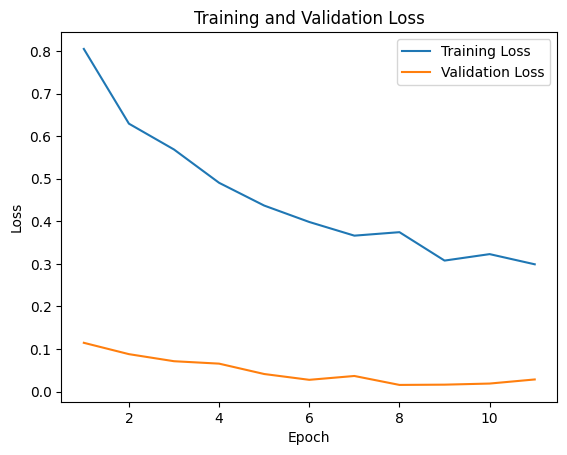

In [1128]:
# Define model, dataset, and dataloaders
model = BetaRegressionModel()
train_dataset = RegressorDataset(us_X_train, us_y_train)
val_dataset = RegressorDataset(us_X_test, us_y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

from torch.distributions.kl import kl_divergence

def beta_nll_loss(alpha, beta, labels):
    #labels = torch.clamp(labels, 1e-4, 1 - 1e-4) # must be within range 0,1
    dist = Beta(alpha, beta)
    prior_alpha = torch.ones_like(alpha) * 2  
    prior_beta = torch.ones_like(beta) * 2 
    prior_dist = Beta(prior_alpha, prior_beta) 
    kl_div = kl_divergence(prior_dist, dist).mean()
    return -dist.log_prob(labels).mean() + 0.5 * kl_div

# Training settings
num_epochs = 100
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        labels = torch.clamp(labels, 1e-4, 1 - 1e-4) # must be within range 0,1
        #print(f"Alpha min: {alpha.min().item()}, max: {alpha.max().item()}")
        #print(f"Beta min: {beta.min().item()}, max: {beta.max().item()}")
        #log_probs = Beta(alpha, beta).log_prob(labels)
        #print(f"log_prob min: {log_probs.min().item()}, max: {log_probs.max().item()}")

        # Forward pass
        alpha, beta = model(inputs)

        loss = beta_nll_loss(alpha, beta, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            labels = torch.clamp(labels, 1e-4, 1 - 1e-4) # must be within range 0,1

            # Forward pass
            alpha, beta = model(inputs)
            torch.clamp(alpha, min=1.01, max=10)
            torch.clamp(beta, min=1.01, max=10)
            #print(f"Alpha min: {alpha.min().item()}, max: {alpha.max().item()}")
            #print(f"Beta min: {beta.min().item()}, max: {beta.max().item()}")
            #log_probs = Beta(alpha, beta).log_prob(labels)
            #print(f"log_prob min: {log_probs.min().item()}, max: {log_probs.max().item()}")

            loss = beta_nll_loss(alpha, beta, labels)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < 0:
        print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
        break
    if train_loss < 0:
        print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
        break
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation improves
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

# Plot training and validation losses
epochs_x = range(1, len(train_losses) + 1)
plt.plot(epochs_x, train_losses, label="Training Loss")
plt.plot(epochs_x, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [1129]:
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluation
model.eval()
prediction_losses = []
all_ground_truths = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        alpha, beta = model(inputs)
        dist = Beta(alpha, beta)
        predicted_mean = dist.mean  # Use mean of Beta distribution as prediction
        
        # Compute loss
        loss = beta_nll_loss(alpha, beta, labels)
        prediction_losses.append(loss.item())
        
        # Collect results
        all_predictions.append(predicted_mean.cpu().numpy())
        all_ground_truths.append(labels.cpu().numpy())

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions).flatten()
all_ground_truths = np.array(all_ground_truths).flatten()

# Compute metrics
mae = mean_absolute_error(all_ground_truths, all_predictions)
mse = mean_squared_error(all_ground_truths, all_predictions)

print(f"Mean Absolute Error on test set: {mae:.4f}")
print(f"Mean Squared Error on test set: {mse:.4f}")


Mean Absolute Error on test set: 0.2843
Mean Squared Error on test set: 0.1016


(array([ 24.,  58.,  69.,  42.,  39.,  26.,  36.,  41.,  48., 121.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

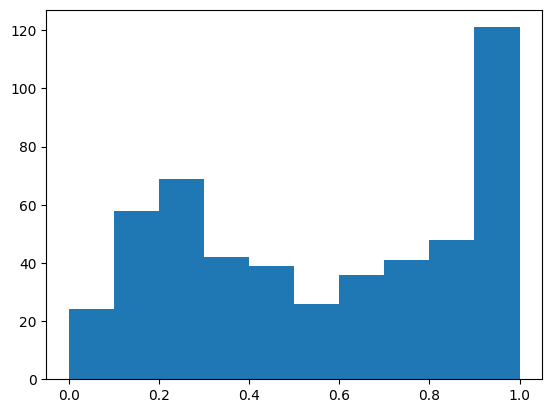

In [1100]:
plt.hist(all_ground_truths)

(array([  3.,  12.,  49.,  97., 137., 101.,  67.,  24.,  10.,   4.]),
 array([0.4122602 , 0.43321282, 0.4541654 , 0.47511798, 0.49607059,
        0.51702321, 0.53797579, 0.55892837, 0.57988095, 0.60083359,
        0.62178618]),
 <BarContainer object of 10 artists>)

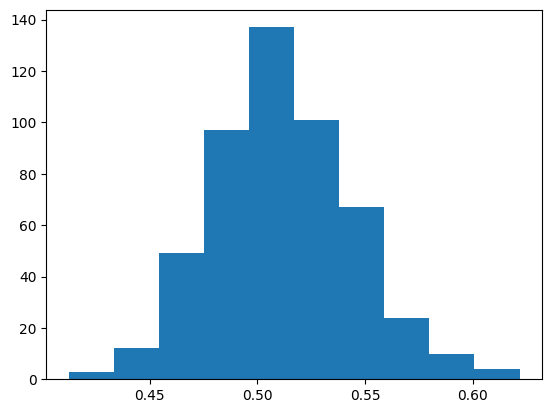

In [1099]:
plt.hist(all_predictions)

#### Chip classifier

In [1166]:
# Larger US

# Get 16 and 17
usdata1617 = pd.concat([data15R, data15S, data15T, data15U])
usdata1617 = usdata1617.drop_duplicates('geometry')

us_qa_pits_1617 = pd.concat([us_qa_pits_16, us_qa_pits_17]).drop_duplicates('geometry')
us_qa_pits1617 = us_qa_pits_15

#us_qa_pits1617 = pd.concat([us_qa_pits_1617, us_qa_dry_11, us_qa_dry_15, us_qa_dry_16, us_qa_dry_17])
print(len(us_qa_pits_1617))

# Check if intersection of each chip with a pit lake polygon is > 0.03%
usdata1617marked = MarkSamples(usdata1617, us_qa_pits_1617, 0.0001)
print((usdata1617marked['mine']==1).sum())
print(len(usdata1617marked))

# Split into train and test
usdata1617marked = usdata1617marked.reset_index(drop=True)
us1617_train_embeddings = np.vstack(usdata1617marked['embeddings'].values)
us1617_labels = np.array(usdata1617marked['mine'])
us1617_indices = usdata1617marked.index

us1617_X_train, us1617_X_test, us1617_y_train, us1617_y_test, us1617_train_idx, us1617_test_idx = sklearn.model_selection.train_test_split(us1617_train_embeddings, us1617_labels, us1617_indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

print(np.shape(us1617_X_train))
print(np.shape(us1617_X_test))
print(np.shape(us1617_y_train))
print(np.shape(us1617_y_test))

1162
183
253
(189, 1024)
(64, 1024)
(189,)
(64,)


In [167]:
# Larger US

# Get 16 and 17
usdata1617 = pd.concat([data11S, data11T, data11U, data15R, data15S, data15T, data15U, data16R, data16S, data16T, data17R, data17S, data17T])
usdata1617 = usdata1617.drop_duplicates('geometry')

print(len(us_qa_pits_16)+len(us_qa_pits_17))
us_qa_pits_1617 = pd.concat([us_qa_pits_11, us_qa_pits_15, us_qa_pits_16, us_qa_pits_17]).drop_duplicates('geometry')

#us_qa_pits1617 = pd.concat([us_qa_pits_1617, us_qa_dry_11, us_qa_dry_15, us_qa_dry_16, us_qa_dry_17])
print(len(us_qa_pits_1617))

# Check if intersection of each chip with a pit lake polygon is > 0.03%
usdata1617marked = MarkSamples(usdata1617, us_qa_pits_1617, 0.001)
print((usdata1617marked['mine']==1).sum())
print(len(usdata1617marked))

# Split into train and test
usdata1617marked = usdata1617marked.reset_index(drop=True)
us1617_train_embeddings = np.vstack(usdata1617marked['embeddings'].values)
us1617_labels = np.array(usdata1617marked['mine'])
us1617_indices = usdata1617marked.index

us1617_X_train, us1617_X_test, us1617_y_train, us1617_y_test, us1617_train_idx, us1617_test_idx = sklearn.model_selection.train_test_split(us1617_train_embeddings, us1617_labels, us1617_indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

print(np.shape(us1617_X_train))
print(np.shape(us1617_X_test))
print(np.shape(us1617_y_train))
print(np.shape(us1617_y_test))

NameError: name 'data11S' is not defined

In [1556]:
# Drop out samples for ablation study

# Indexing from training embeddings, holding test embeddings constant
index = sorted(random.sample(range(0, len(us1617_X_train)), 612))
us1617_X_train = us1617_X_train[index]
us1617_y_train = us1617_y_train[index]

print(us1617_X_train.shape)
print(us1617_y_train.shape)

(612, 1024)
(612,)


In [700]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256], output_size=1):
        super(MLPBinaryClassifier, self).__init__()
        
        # Define the layers of the MLP
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        # Output layer
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # Pass through the output layer and apply sigmoid for binary classification
        x = torch.sigmoid(self.output_layer(x))
        return x

In [631]:
class MLPDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (torch.Tensor): Input embeddings with shape (num_samples, 1024).
            labels (torch.Tensor): Labels with shape (num_samples,).
        """
        self.data = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


10.851106639839033
Epoch 1/100, Train Loss: 0.3650, Validation Loss: 0.2530
Epoch 2/100, Train Loss: 0.2209, Validation Loss: 0.2433
Epoch 3/100, Train Loss: 0.1817, Validation Loss: 0.2006
Epoch 4/100, Train Loss: 0.1679, Validation Loss: 0.1985
Epoch 5/100, Train Loss: 0.1573, Validation Loss: 0.1951
Epoch 6/100, Train Loss: 0.1470, Validation Loss: 0.1918
Epoch 7/100, Train Loss: 0.1414, Validation Loss: 0.1822
Epoch 8/100, Train Loss: 0.1334, Validation Loss: 0.1900
No improvement in validation loss for 1 epoch(s).
Epoch 9/100, Train Loss: 0.1328, Validation Loss: 0.1963
No improvement in validation loss for 2 epoch(s).
Epoch 10/100, Train Loss: 0.1230, Validation Loss: 0.2118
No improvement in validation loss for 3 epoch(s).
Early stopping at epoch 10. Best Validation Loss: 0.1822


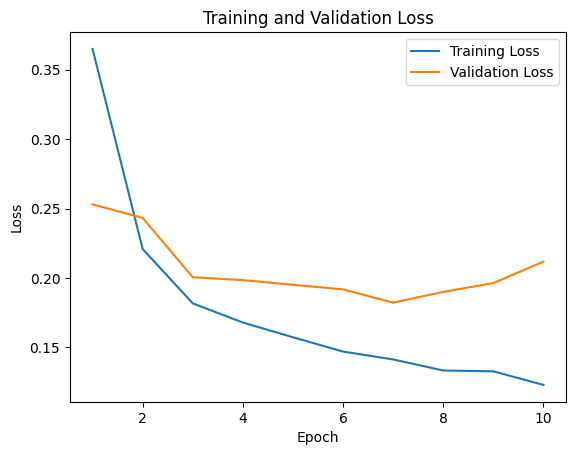

In [1764]:
# Define model, dataset, and dataloaders
model = MLPBinaryClassifier()
train_dataset = MLPDataset(us_X_train, us_y_train)
val_dataset = MLPDataset(us_X_test, us_y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer
num_positives = us_y_train.sum()
num_negatives = len(us_y_train) - num_positives
weight2 = num_negatives / num_positives / 6
print(weight2)
class_weights = torch.tensor([1, weight2])  # Example class weights
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training settings
num_epochs = 100
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        weights = class_weights[labels.long()]  # Apply class weights
        loss = (loss * weights).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            weights = class_weights[labels.long()]  # Apply class weights
            loss = (loss * weights).mean()

            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation improves
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

# Plot training and validation losses
import matplotlib.pyplot as plt
epochs_x = range(1, len(train_losses) + 1)
plt.plot(epochs_x, train_losses, label="Training Loss")
plt.plot(epochs_x, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Evaluation

In [1765]:
# Set the model to evaluation mode for test set
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(us_X_test, us_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f"F1 score on test set: {f1:.4f}")

Precision on test set: 0.2108
Recall on test set: 0.8409
F1 score on test set: 0.3371


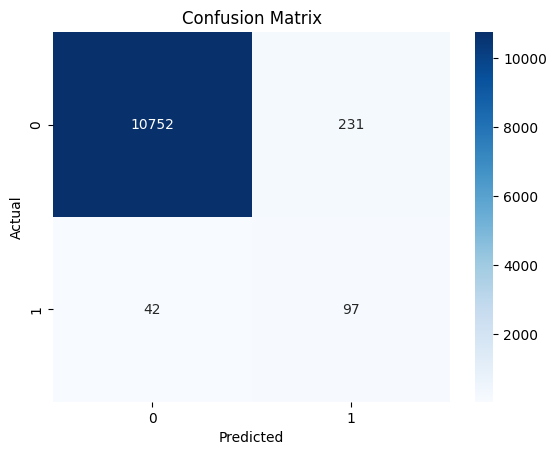

In [1742]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [1762]:
# Set the model to evaluation mode for train set
model.eval()
criterion = nn.BCELoss(reduction='mean') 
train_eval_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in train_eval_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
prediction_losses = np.array(prediction_losses)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on train set: {precision:.4f}")
print(f"Recall on train set: {recall:.4f}")
print(f"F1 score on train set: {f1:.4f}")

Precision on train set: 0.3534
Recall on train set: 0.7907
F1 score on train set: 0.4885


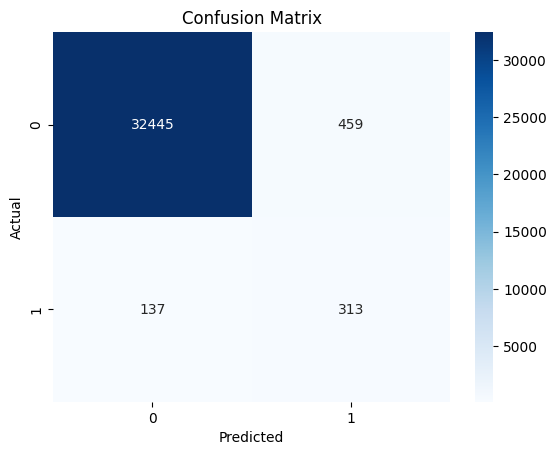

In [1638]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [1717]:
print(np.median(prediction_losses))
print(np.mean(prediction_losses))
print(np.min(prediction_losses))
print(np.max(prediction_losses))

len(prediction_losses[prediction_losses > 1])

0.009958826936781406
0.1201363804211716
8.683043120072398e-07
4.862499713897705


1101

In [1677]:
# For training predictions, find negatives that are high loss
negatives_idx = []
high_loss_negs_idx = []
for i in range(len(all_predictions)):
    if all_predictions[i] == 0:
        negatives_idx.append(i)

for i in range(len(negatives_idx)):
    if prediction_losses[negatives_idx[i]] > 1.2:
        high_loss_negs_idx.append(negatives_idx[i])

# Drop high_loss_negs_idx from us_X_train and us_y_train
print(len(us_X_train))
us_X_train = np.delete(us_X_train, high_loss_negs_idx, axis = 0)
print(len(us_X_train))

print(len(us_y_train))
us_y_train = np.delete(us_y_train, high_loss_negs_idx, axis = 0)
print(len(us_y_train))


33354
33320
33354
33320


In [1763]:
# For training predictions, find positives that are high loss

# high loss positives are where model is certain it's positive but it's negative, bc it was told this was positive
positives_idx = []
high_loss_pos_idx = []
for i in range(len(all_predictions)):
    if all_predictions[i] == 1:
        positives_idx.append(i)

for i in range(len(positives_idx)):
    if prediction_losses[positives_idx[i]] > 1:
        high_loss_pos_idx.append(positives_idx[i])

# Drop high_loss_negs_idx from us_X_train and us_y_train
print(len(us_X_train))
us_X_train = np.delete(us_X_train, high_loss_pos_idx, axis = 0)
print(len(us_X_train))

print(len(us_y_train))
us_y_train = np.delete(us_y_train, high_loss_pos_idx, axis = 0)
print(len(us_y_train))

33354
32855
33354
32855


In [ ]:
# Set the model to evaluation mode for test set
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(us_X_test, us_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f"F1 score on test set: {f1:.4f}")

Precision on test set: 0.3383
Recall on test set: 0.6975
F1 score on test set: 0.4556


In [ ]:
# Set the model to evaluation mode for test set
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(us_X_test, us_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f"F1 score on test set: {f1:.4f}")

KeyboardInterrupt: 

In [ ]:
# Set the model to evaluation mode for test set
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(us_X_test, us_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f"F1 score on test set: {f1:.4f}")

KeyboardInterrupt: 

In [628]:
# Train neural network model for IN and MN
#from sklearn.utils.class_weight import compute_class_weight

#class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=mn_y_train)

# Convert the class weights to a dictionary
#class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

us_clf = sklearn.neural_network.MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16, 16, 16), max_iter = 1000, 
                    random_state=1)

us_clf.fit(us_X_train, us_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(16, 16, 16), max_iter=1000,
              random_state=1, solver='lbfgs')

In [703]:
# Run predictions on test set and get F1 scores and probabilities
def PredictClf(model, X_test, y_test):
    predictions = model.predict(X_test) 
    print(f'Number of positive predictions: {predictions.sum()}')
    print(f'Number of positive samples: {y_test.sum()}')
    print(f'Number of test samples: {len(X_test)}')

    f1 = sklearn.metrics.f1_score(y_test, predictions)
    print(f'F1: {f1}')

    precision = sklearn.metrics.precision_score(y_test, predictions)
    print(f'precision: {precision}')

    recall = sklearn.metrics.recall_score(y_test, predictions)
    print(f'recall: {recall}')

    probabilities = model.predict_proba(X_test)
    print(f'Classes for probability: {model.classes_}')

    us_probabilities[:,1] # Probability of pit lake presence
    return predictions, probabilities

In [630]:
us_preds, us_probs = PredictClf(us_clf, us_X_test, us_y_test)

Number of positive predictions: 66
Number of positive samples: 78
Number of test samples: 5384
F1: 0.4722222222222222
precision: 0.5151515151515151
recall: 0.4358974358974359
Classes for probability: [0 1]


In [318]:
aznv_preds, aznv_probs = PredictClf(us_clf, aznv_X_test, aznv_y_test)
ga_preds, ga_probs = PredictClf(us_clf, ga_X_test, ga_y_test)
mn_preds, mn_probs = PredictClf(us_clf, mn_X_test, mn_y_test)

Number of positive predictions: 18
Number of positive samples: 11
Number of test samples: 2578
F1: 0.4827586206896552
precision: 0.3888888888888889
recall: 0.6363636363636364
Classes for probability: [0 1]
Number of positive predictions: 11
Number of positive samples: 15
Number of test samples: 484
F1: 0.6153846153846154
precision: 0.7272727272727273
recall: 0.5333333333333333
Classes for probability: [0 1]
Number of positive predictions: 26
Number of positive samples: 29
Number of test samples: 2322
F1: 0.509090909090909
precision: 0.5384615384615384
recall: 0.4827586206896552
Classes for probability: [0 1]


In [319]:
# Write predictions and probabilities to shapefiles
dataAZNV = dataAZNV.reset_index(drop = True)
dataGA = dataGA.reset_index(drop = True)
dataMN = dataMN.reset_index(drop = True)

aznv_geom = dataAZNV.loc[aznv_test_idx].geometry.reset_index(drop = True)
ga_geom = dataGA.loc[ga_test_idx].geometry.reset_index(drop = True)
mn_geom = dataMN.loc[mn_test_idx].geometry.reset_index(drop = True)

#aznv_pred = gpd.GeoDataFrame(in_mn_predictions, columns = ['mines'], geometry=in_mn_pits_geom, crs = 'EPSG:4326')
aznv_probs = gpd.GeoDataFrame(aznv_probs[:,1], columns = ['mine_prob'], geometry=aznv_geom, crs = 'EPSG:4326')
ga_probs =  gpd.GeoDataFrame(ga_probs[:,1], columns = ['mine_prob'], geometry=ga_geom, crs = 'EPSG:4326')
mn_probs =  gpd.GeoDataFrame(mn_probs[:,1], columns = ['mine_prob'], geometry=mn_geom, crs = 'EPSG:4326')

aznv_probs.to_file('aznv_probs_0128')
ga_probs.to_file('ga_probs_0128')
mn_probs.to_file('mn_probs_0128')


In [ ]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256], output_size=1):
        super(MLPBinaryClassifier, self).__init__()
        
        # Define the layers of the MLP
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        # Output layer
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # Pass through the output layer and apply sigmoid for binary classification
        x = torch.sigmoid(self.output_layer(x))
        return x

In [337]:
usdata1617marked['pct_pitlake'].fillna(0, inplace=True)
usdata1617marked['pct_pitlake']

0      0.033201
1      0.012111
2      0.027292
3      0.015862
4      0.008875
         ...   
722    0.000000
723    0.000000
724    0.000000
725    0.000000
726    0.000000
Name: pct_pitlake, Length: 727, dtype: float64

In [338]:
# Larger US REGRESSOR

# Split into train and test
usdata1617marked = usdata1617marked.reset_index(drop=True)
us1617_train_embeddings = np.vstack(usdata1617marked['embeddings'].values)
us1617_labels = np.array(usdata1617marked['pct_pitlake'])
us1617_indices = usdata1617marked.index

us1617_X_train, us1617_X_test, us1617_y_train, us1617_y_test, us1617_train_idx, us1617_test_idx = sklearn.model_selection.train_test_split(us1617_train_embeddings, us1617_labels, us1617_indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

print(np.shape(us1617_X_train))
print(np.shape(us1617_X_test))
print(np.shape(us1617_y_train))
print(np.shape(us1617_y_test))

(545, 1024)
(182, 1024)
(545,)
(182,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create and train the RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=1)
regressor.fit(us1617_X_train, us1617_y_train)

# Make predictions
y_pred = regressor.predict(us1617_X_test)

# Evaluate the model
mse = mean_squared_error(us1617_y_test, y_pred)
print(f"Mean Squared Error: {mse}")
math.sqrt(mse)

In [ ]:
fig, ax = plt.subplots()

plt.xlim(0,0.08)
plt.ylim(0,0.08)
ax.scatter(regressor.predict(us1617_X_train), us1617_y_train, color = 'grey')
ax.scatter(y_pred, us1617_y_test, color = 'blue')
x = np.linspace(0,1)
y = np.linspace(0,1)
ax.plot(x, y, linestyle = ':')
ax.legend(['train', 'test'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

plt.show()

In [1169]:
f1 = 0.6590909090909091
p1 = 0.6904761904761905
r1 = 0.6304347826086957

f2 = 0.7422680412371134
p2 = 0.75
r2 = 0.7346938775510204

f3 = 0.7551020408163265
p3 = 0.6851851851851852
r3 = 0.8409090909090909

f1avg = (f1 + f2 + f3)/3
precisionavg = (p1 + p2 + p3) / 3
recallavg = (r1 + r2 + r3) / 3

print(f1avg)
print(precisionavg)
print(recallavg)

0.7188203303814497
0.7085537918871253
0.7353459170229356
